In [3]:
# !pip install tensorflow==2.3.1
# !pip install q keras==2.4.3
# !pip install numpy==1.18.1
# !pip install pandas==1.0.1
!pip install -q esprima

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report, confusion_matrix
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Conv1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping,Callback,CSVLogger
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from keras.layers import Activation, Dense, Reshape, Input
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, load_model
from keras.preprocessing.text import Tokenizer
from keras.models import Model , clone_model
from keras.losses import BinaryCrossentropy
from keras.backend import clear_session
from keras.initializers import Constant
from nltk.tokenize import word_tokenize
from threading import current_thread
from keras.utils import plot_model
from sklearn.utils import shuffle
from keras.optimizers import Adam
from keras.utils import Sequence
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from keras import backend as K
from functools import partial
from numpy import asarray
import concurrent.futures
from keras import layers
import matplotlib as mpl
from keras import Model
from numpy import save
from numpy import load
import seaborn as sns
import esprima as esp
from time import time
import pandas as pd
import numpy as np
import tempfile
import logging
import urllib
import random
import pickle
import pydot
import torch
import math
import html
import nltk
import os
import re
import gc
np.random.seed(123)
plt.style.use('ggplot')
# mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
model_info_path = "/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Results_for_Entre_Static_Word_Embedding/Model info"
results_path = "/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Results_for_Entre_Static_Word_Embedding"
data_path = "/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/DataSets"

In [7]:
class GarbageCollectorCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [8]:
def print_result(y_pred, y_test , title ,color):
    if len(y_test) < len(y_pred):
        y_pred = y_pred[: len(y_test)]
    elif len(y_test) > len(y_pred):
        y_test = y_test[: len(y_pred)]
    accuracy = accuracy_score(y_pred, y_test)
    classification_rep = classification_report(y_test, y_pred)
    con_matrix = confusion_matrix(y_test, y_pred)
    if len(con_matrix)==1:
        if len(con_matrix[0])==1:
            con_matrix = list(con_matrix)
            con_matrix[0] = list(con_matrix[0])
            con_matrix[0].append(0)
            con_matrix = np.array([con_matrix[0],[0,0]])
    plt.figure(figsize=(25,15))
    plt.subplot(2,1,1)
    group_names =['Not one']

    if y_test is np.ndarray:
      T1 = np.count_nonzero(y_test == 0) if np.count_nonzero(y_test == 0) !=0 else 1
      T2 = np.count_nonzero(y_test == 1)  if np.count_nonzero(y_test == 1) !=0 else 1
    else:
      T1 = y_test.count(0) if y_test.count(0)!=0 else 1
      T2 = y_test.count(1) if y_test.count(1)!=0 else 1
    group_counts = con_matrix
    group_percentages = np.round(con_matrix / np.array([[T1 , T1],[T2 , T2]]),3)
    t = 0.5
    plt.text(x=0.0 , y = 2.6, s =  "confusion_matrix :",fontsize=15)
    plt.text(x=0.0 , y = 3.3-t, s =  'Not one ',fontsize=15)
    plt.text(x=0.0 , y = 3.4-t, s =  'One ',fontsize=15)
    plt.text(x=0.3 , y = 3.2-t, s =  'Not one ',fontsize=15)
    plt.text(x=0.6 , y = 3.2-t, s =  'One',fontsize=15)
    plt.text(x=0.3 , y = 3.3-t, s =  "{}".format(con_matrix[0][0]),fontsize=15)
    plt.text(x=0.6 , y = 3.3-t, s =  "{}".format(con_matrix[0][1]),fontsize=15)
    plt.text(x=0.3 , y = 3.4-t, s =  "{}".format(con_matrix[1][0]),fontsize=15)
    plt.text(x=0.6 , y = 3.4-t, s =  "{}".format(con_matrix[1][1]),fontsize=15)
    sns.heatmap(group_percentages,xticklabels= ['Not one' , 'One'], yticklabels=['Not one' , 'One']  , annot=True, annot_kws={"size": 16},fmt='g', cmap=color)
    plt.title(title ,  fontsize = 18)
    plt.text(x =0,y = 2.3 , s = "accuracy  score on test : {}".format(accuracy),fontsize=15)
    plt.text(x=0 , y = 3.9, s =  "classification_report :\n {}".format(classification_rep),fontsize=15)
    plt.xlabel("Predicted value")
    plt.ylabel("Real value")
    plt.savefig("{} .png".format(os.path.join(os.path.join(results_path,"Image"),title)))
    # plt.show()

In [9]:
def _replaceitem(x):
    if type(x) is list:
        if x[0]<0.5:
            return 0.0
    else:
        x = float(x)
        if x<0.5:
            return 0.0
    return 1.0

In [10]:
def save_object(obj, filename,path):
    """
    _ INPUT (obj) THE OBJECT WE NEED SAVW IT (filename) THE NAME OF OBJECT
    """
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    outp.close()

In [11]:
def load_object(filename,path):
    """
    _ INPUT THE NAME OF OBJECT WE NEED LOAD IT
    """
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'rb') as outp:
        loaded_object = pickle.load(outp)
    outp.close()
    return loaded_object

In [12]:
def plot_history(history,title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.savefig("{} .png".format(os.path.join(os.path.join(results_path,"Image"),"history "+title)))
    plt.legend()

In [13]:
def Pad_Sequences(scripts,fit = True,creat=True):
    if fit:
        tokenizer = Tokenizer(num_words=num_words)
        tokenizer.fit_on_texts(scripts)
        save_object(tokenizer, "Pad_Sequences_tokenizer",results_path)
    else :
        tokenizer = load_object("Pad_Sequences_tokenizer",results_path)
    X = tokenizer.texts_to_sequences(scripts)
    X = pad_sequences(X, padding='post', maxlen=maxlen)
    return X

In [14]:
metric_functions = {'accuracy': accuracy_score, 'precision': precision_score,
                        'recall': recall_score, 'f1_score': f1_score}
def cummulative_metrics(y_true, y_pred, step_size, metric):
    metric_score = []
    for i in range(step_size, len(y_true) - step_size, step_size):
        metric_score.append(metric_functions[metric](y_true[:i], y_pred[:i]))
    return metric_score

In [15]:
def time_series_plot(df,  metric, step_size=40, title=" ", method_names=None, drift_data_path=None):
    fig = plt.figure(figsize=(20, 12))
    colors = ['r', 'g', 'b', 'm', 'c']
    y_true, y_pred = None,None
    for d in range(df.shape[0]):
        if y_true is None:
            y_true, y_pred = df['y_test'][d] , np.concatenate(df['y_predict'])
            y_true = list(map(_replaceitem, y_true))
            y_pred = list(map(_replaceitem, y_pred))
        else:
            y_true = y_true + df['y_test'][d]
            y_pred = y_pred + list(np.concatenate(df['y_predict'][d]))
            y_true = list(map(_replaceitem, y_true))
            y_pred = list(map(_replaceitem, y_pred))
    metric_score = cummulative_metrics(y_true, y_pred, step_size, metric)
    X = np.linspace(0, 16000, len(metric_score))
    plt.plot(X, metric_score, label='{}'.format(title))
    plt.xlabel("Time Series")
    plt.ylabel("{}".format(metric))
    plt.title(title)
    plt.legend()
    plt.savefig(os.path.join(os.path.join(results_path,"Image"),"{}_{}.png".format(title, metric)))
    # plt.show()

In [16]:
def create_model(): # shape=None,without_first_layer=False
    """
    _INPUT (without_first_layer) IF WE WANT TO CREAT MODEL WITHOUT FIRST LSTM LAYER (shape) IF THE PREVIOS PAREMETER IS TRUE WE NEED DIFINE THE SHAPE FOR INPUT LAYER
    _OUTPUT THE MODEL
    """
    clear_session()
    model = Sequential()
    # if without_first_layer:
    #     name_model = 'without_biLSTM_layers_weights.best.hdf5'
    #     model.add(layers.InputLayer(input_shape=shape))
    #     # model.add(Bidirectional(LSTM(units=50, input_shape=(None, 50), return_sequences=True)))
    # else:
    #     name_model = 'with_biLSTM_layers_weights.best.hdf5'
    #     model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    #     model.add(Bidirectional(LSTM(units=50, input_shape=(None, 50), return_sequences=True)))
    #     model.add(Bidirectional(LSTM(units=50, input_shape=(None, 50), return_sequences=True)))

    name_model = 'Model_for_Static_Word_Embedding.best.hdf5'
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    # TextCNN with 4 conv layers
    model.add(Conv1D(128, 7, activation='tanh', input_shape=(None, 32)))
    model.add(Conv1D(128, 15, activation='tanh'))
    model.add(Conv1D(128, 25, activation='tanh'))
    model.add(Conv1D(128, 35, activation='tanh'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    # model.load_weights(os.path.join(model_info_path,name_model))
    plot_model(model, to_file=os.path.join(model_info_path,name_model[:-10]+'.png'), show_shapes=True, show_layer_names=True)
    # model.summary()
    return model

In [17]:
def creat_metrics():
    model_comparison_table = {}
    model_comparison_table['chunk_number'] = []
    model_comparison_table['y_test'] = []
    model_comparison_table['y_predict'] = []
    return model_comparison_table

In [18]:
def evaluate_result(model_comparison_table,y_predict,y_test,title,chunk_number,mytype):
    c = 'Blues'
    if mytype == 1:
      c = 'Accent'
    y_predict[y_predict>0.5] = 1
    y_test = list(map(_replaceitem, y_test))
    y_predict = list(map(_replaceitem, y_predict))
    model_comparison_table['y_test'].append(y_test)
    model_comparison_table['y_predict'].append(y_predict)
    model_comparison_table['chunk_number'].append(title+"chunk_number_"+str(chunk_number))
    print_result(y_predict, y_test , title+"chunk_number_"+str(chunk_number),color=c)

In [19]:
def chunking_data(Data,test_size=0.20):
    """
    _INPUT (Data) CHUNK OF DATASET (test_size=0.20) SIZE OF SPLITNG
    _OUTPUT (X_train , y_train , X_test , y_test)
    """
    train_data, test_data = train_test_split(Data, test_size=0.2,random_state=42,shuffle=False)
    X_test = test_data[test_data.columns[-2]]
    y_test = test_data[test_data.columns[-1]]
    X_train = train_data[train_data.columns[-2]]
    y_train = train_data[train_data.columns[-1]]
    return X_train , y_train , X_test , y_test

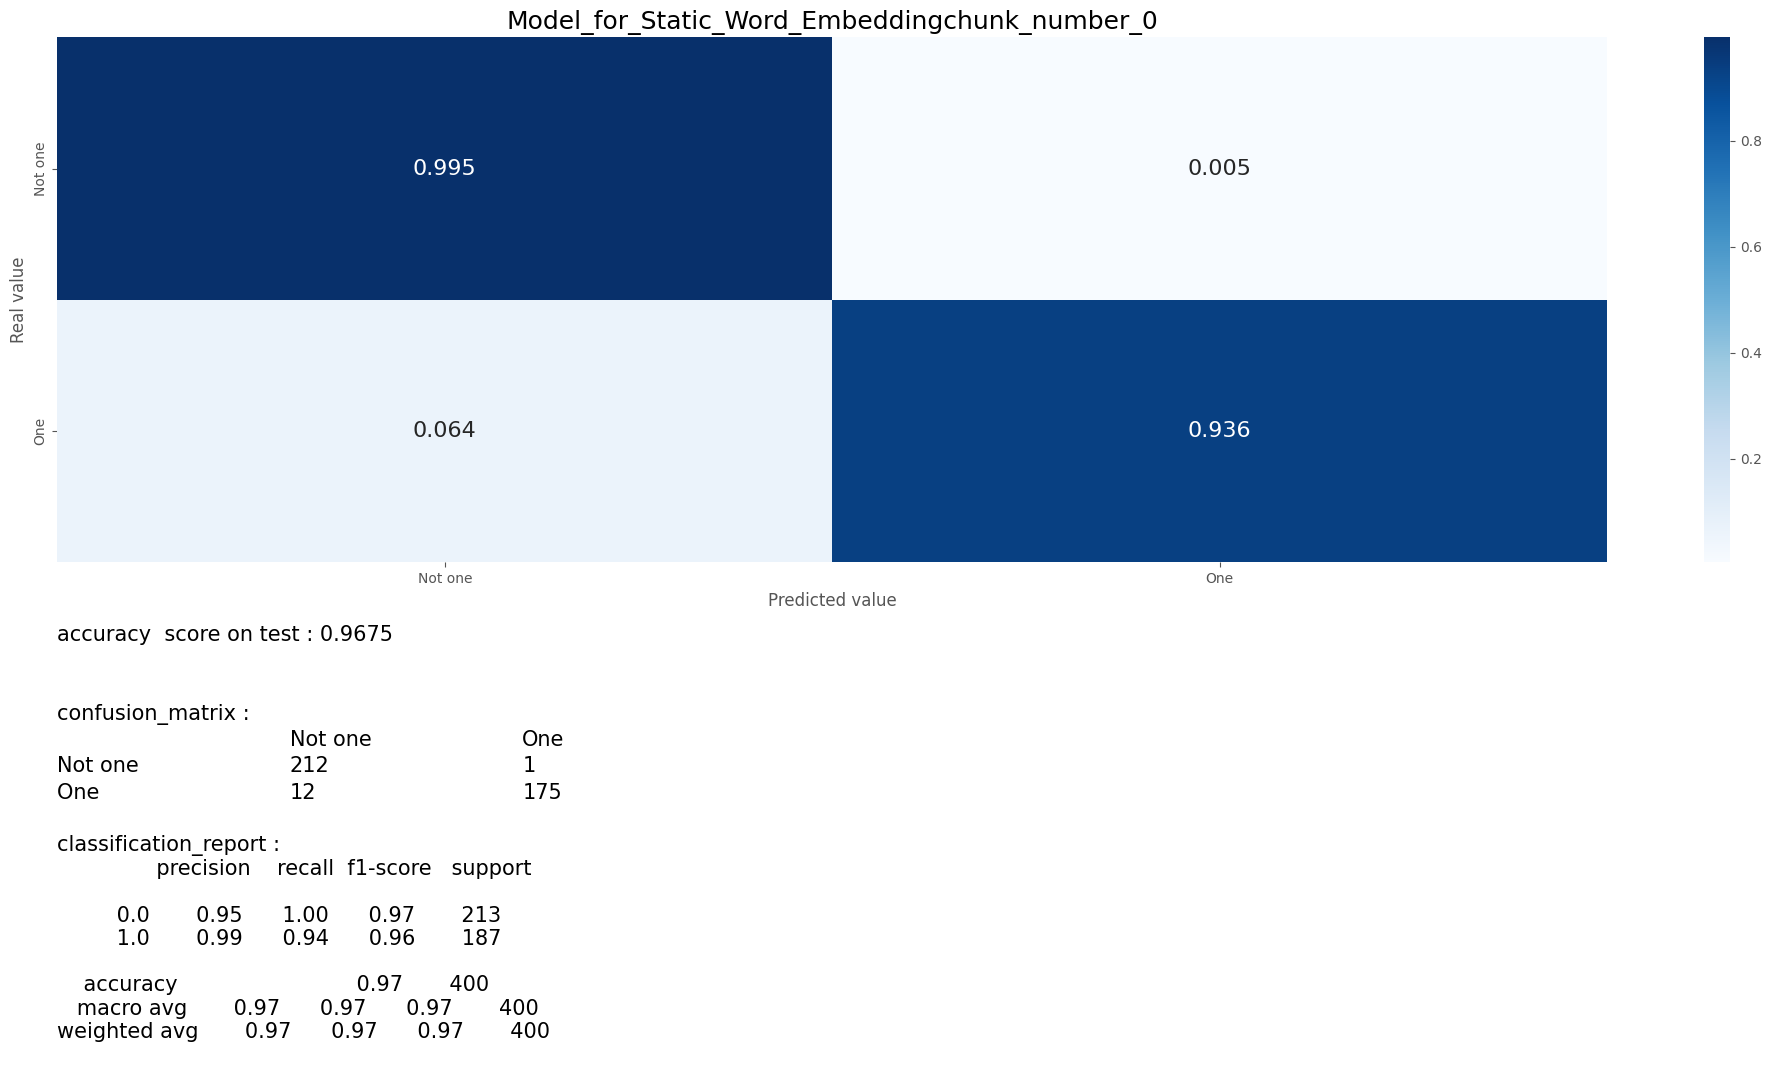

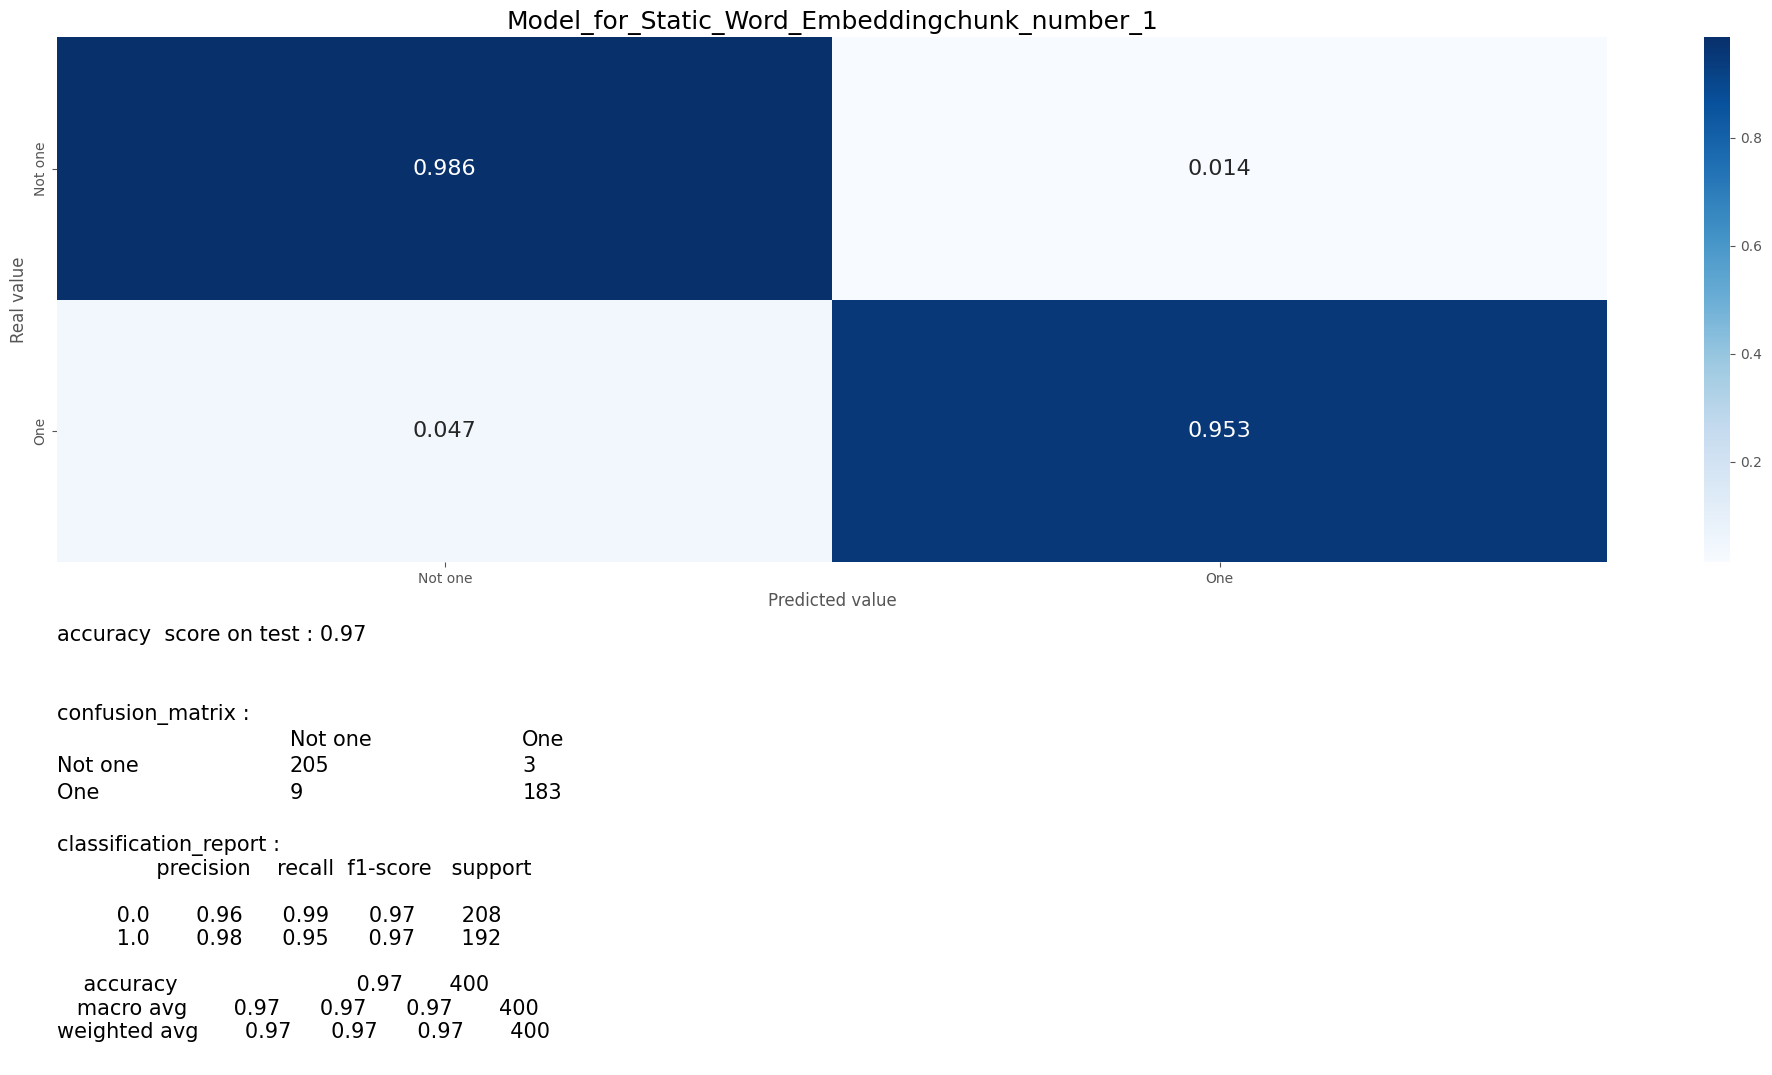

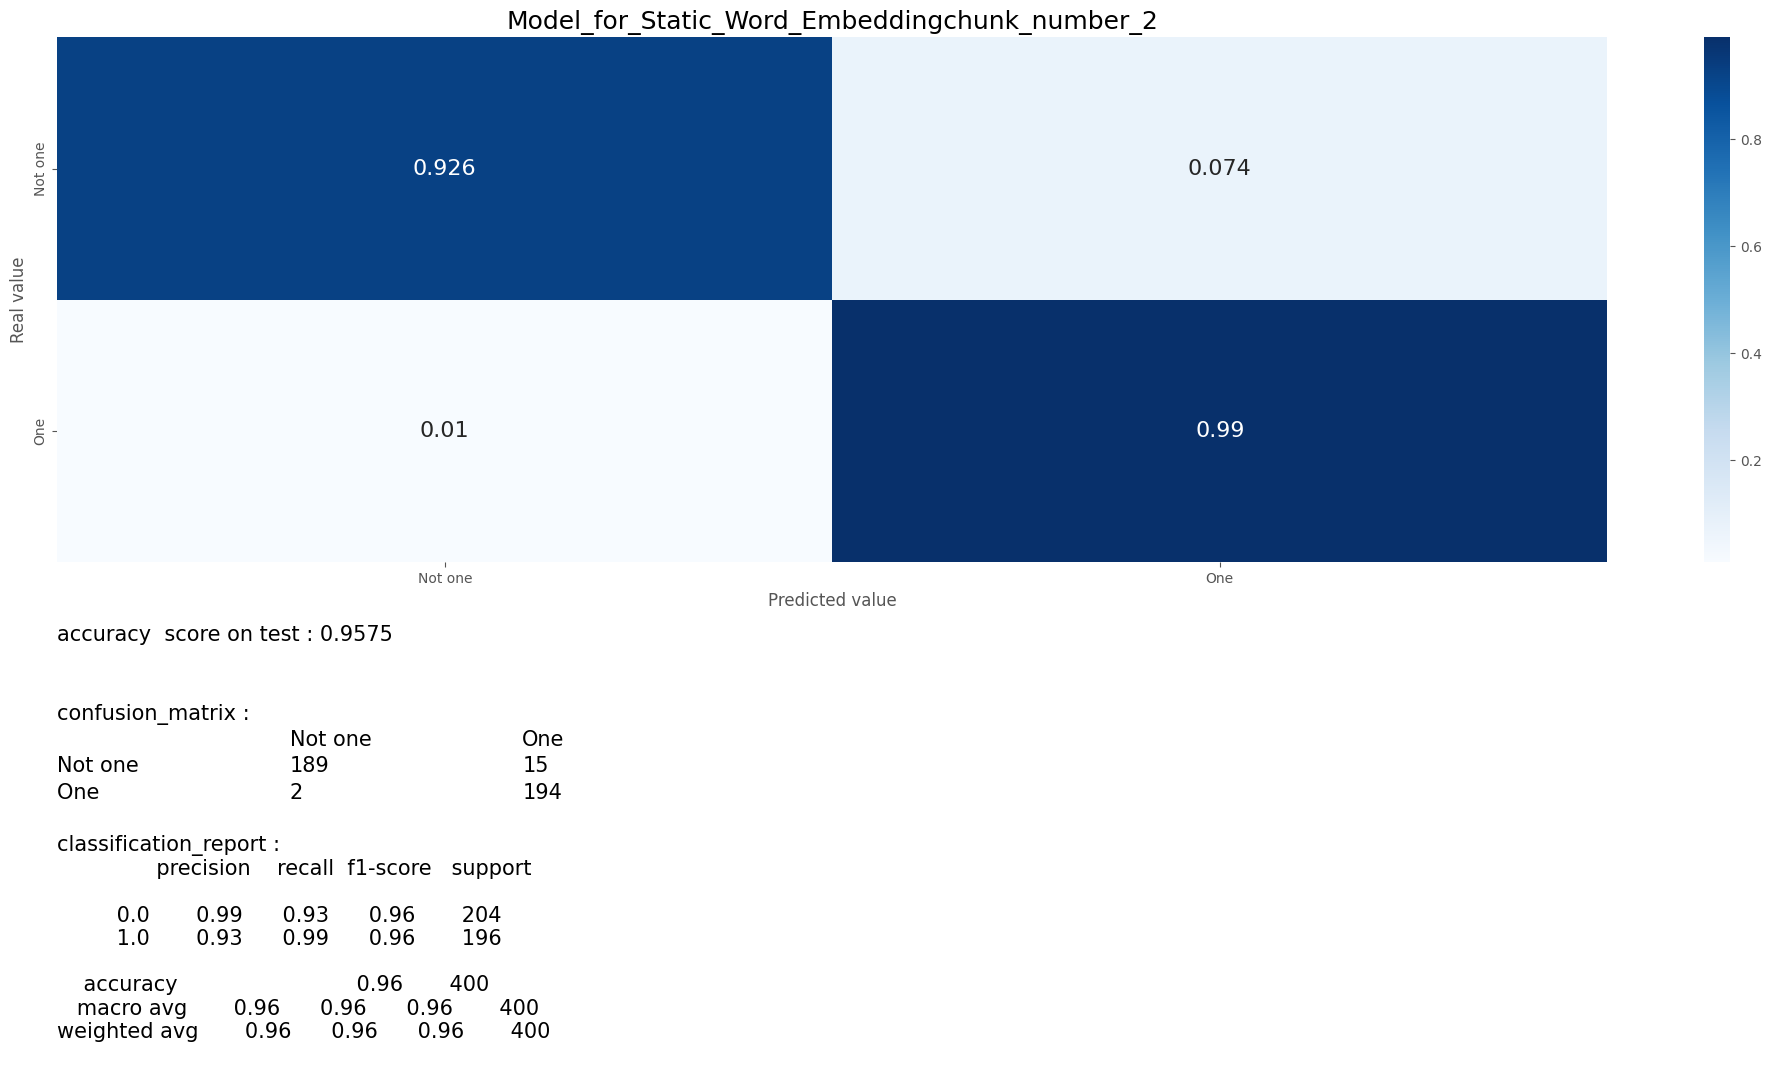

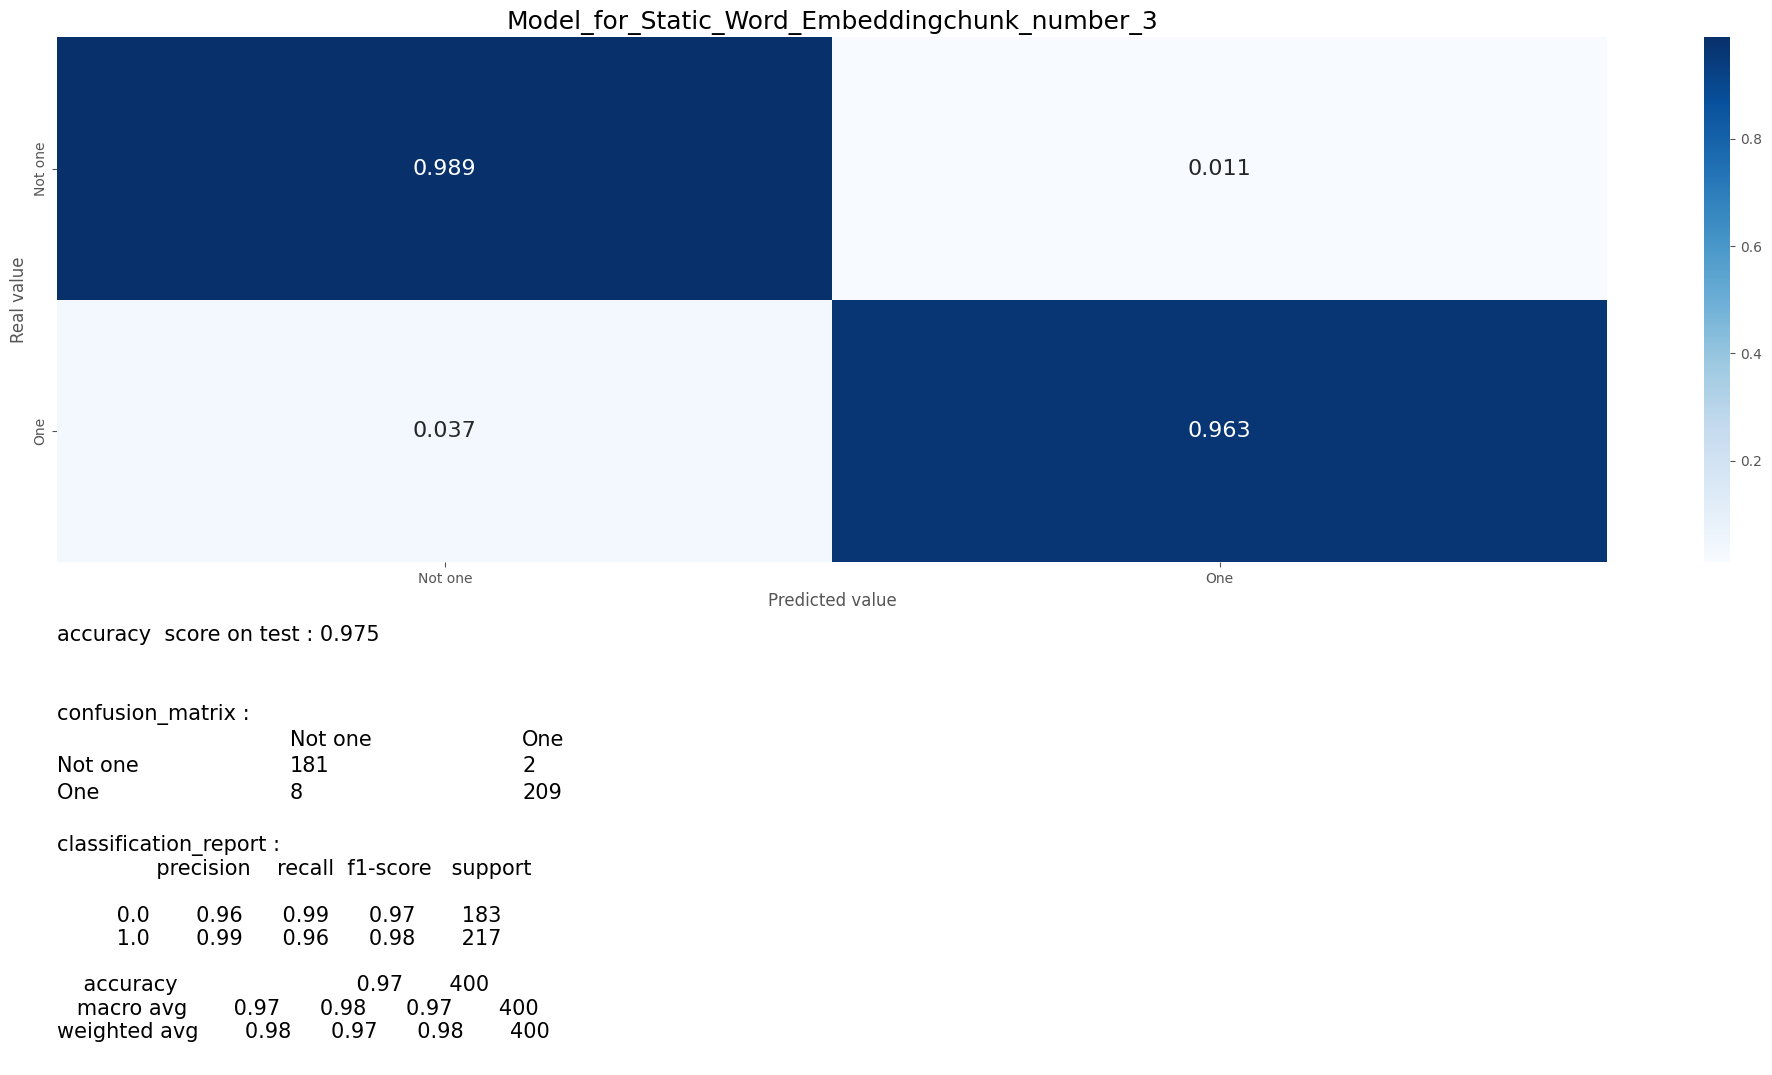

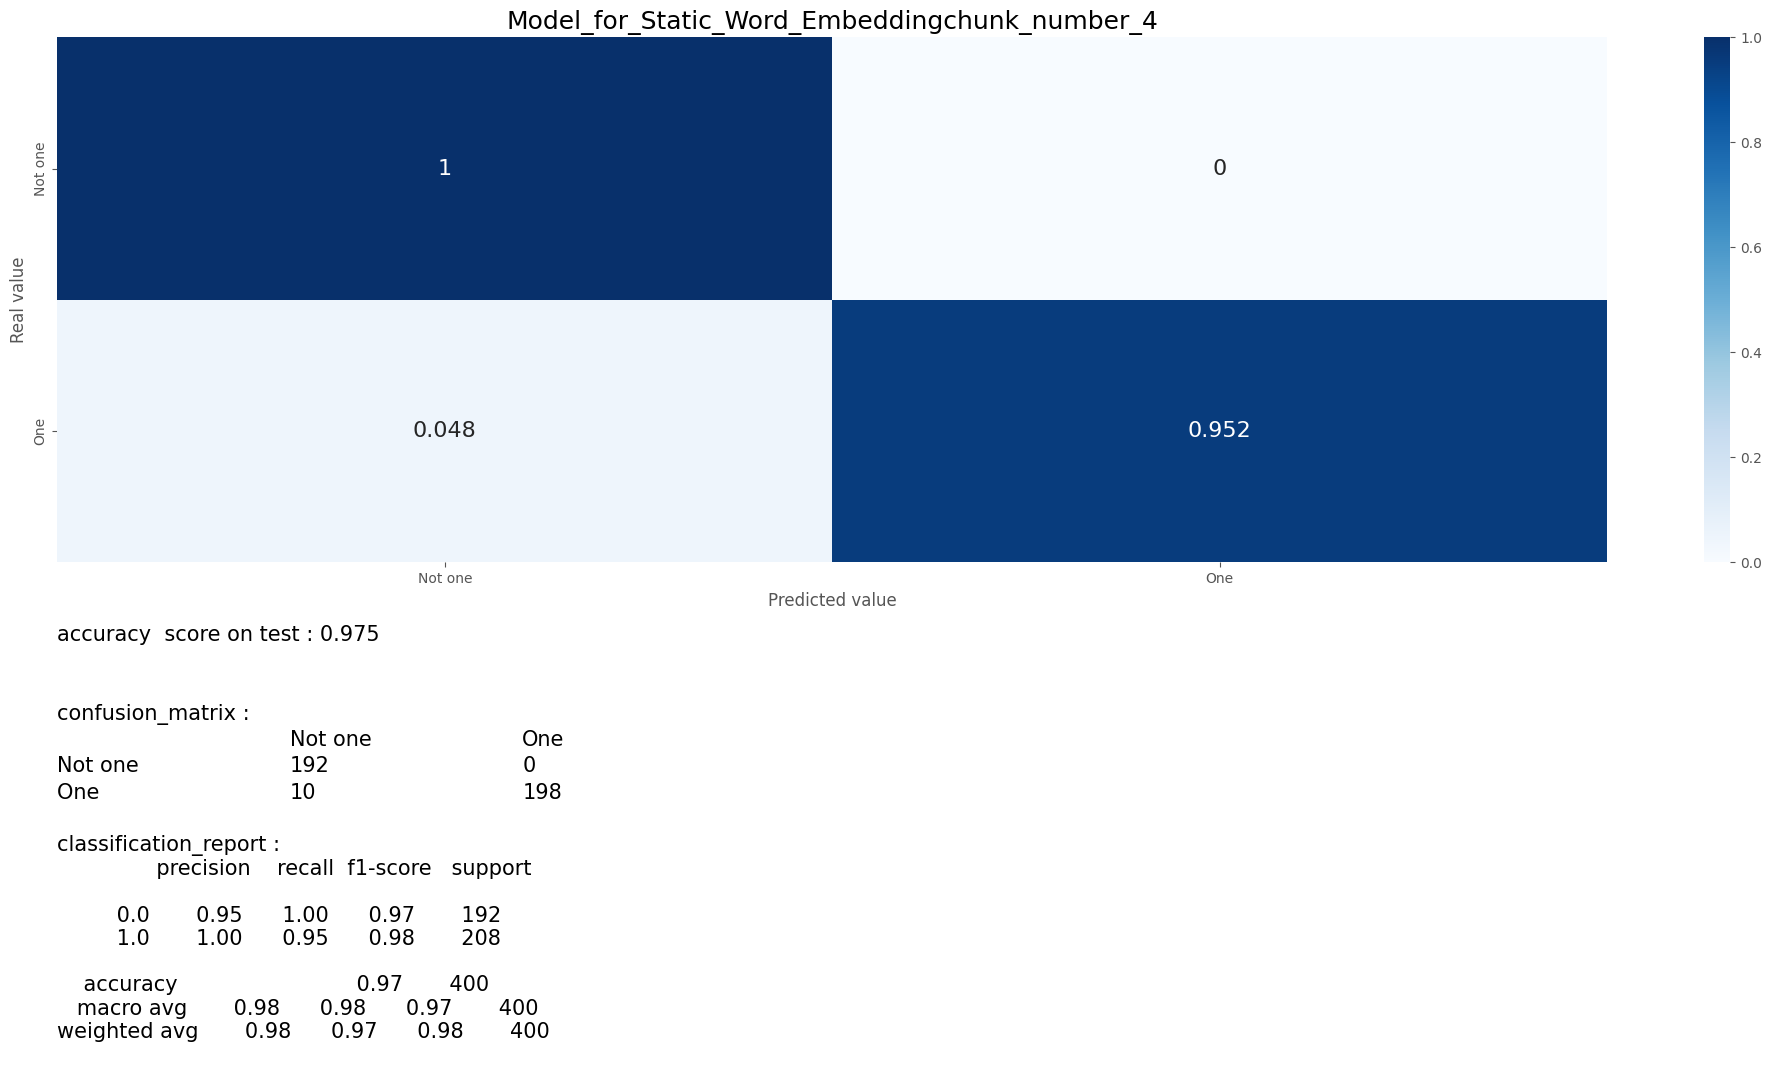

In [22]:
par_path = "/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Hiden"
methods = ['y_predicte_tabu_search_model_','y_predicte_softmax_model_','y_predicte_single_agent_model_','y_predicte_average_model_','y_predicte_js_contana_text_cnn_','y_predicte_js_contana_']
for i in range(5):
  y_true = load_object('y_test_hiden_for_chunk_'+str(i),par_path)
  y_pred = np.squeeze(load_object('y_predicte_js_contana_text_cnn_'+str(i),"/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Results_TabuSearch"))
  y_true = list(map(_replaceitem, y_true))
  y_pred = list(map(_replaceitem, y_pred))
  print_result(y_pred, y_true , "Model_for_Static_Word_Embeddingchunk_number_"+str(i),color='Blues')

In [ ]:
model_result_table_1 = creat_metrics()

vocab_size = 500000
num_words = 400000
maxlen = 2048
embedding_dim = 512

model_is_not_created = True

filepath_1 = os.path.join(model_info_path,'Model_for_Static_Word_Embedding.best.hdf5')
history_logger_1 = CSVLogger(os.path.join(model_info_path,'history1.csv'), separator=",", append=True)
checkpoint_1 = ModelCheckpoint(filepath_1, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
es_1 = EarlyStopping(monitor='val_loss', patience=5)
callbacks_list_1 = [GarbageCollectorCallback(),checkpoint_1, es_1,history_logger_1]

model1 = create_model()

0it [00:00, ?it/s]

13/13 [==============================] - 0s 26ms/step


<ipython-input-6-3ac03204d767>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(25,15))


7/7 [==============================] - 1s 110ms/step


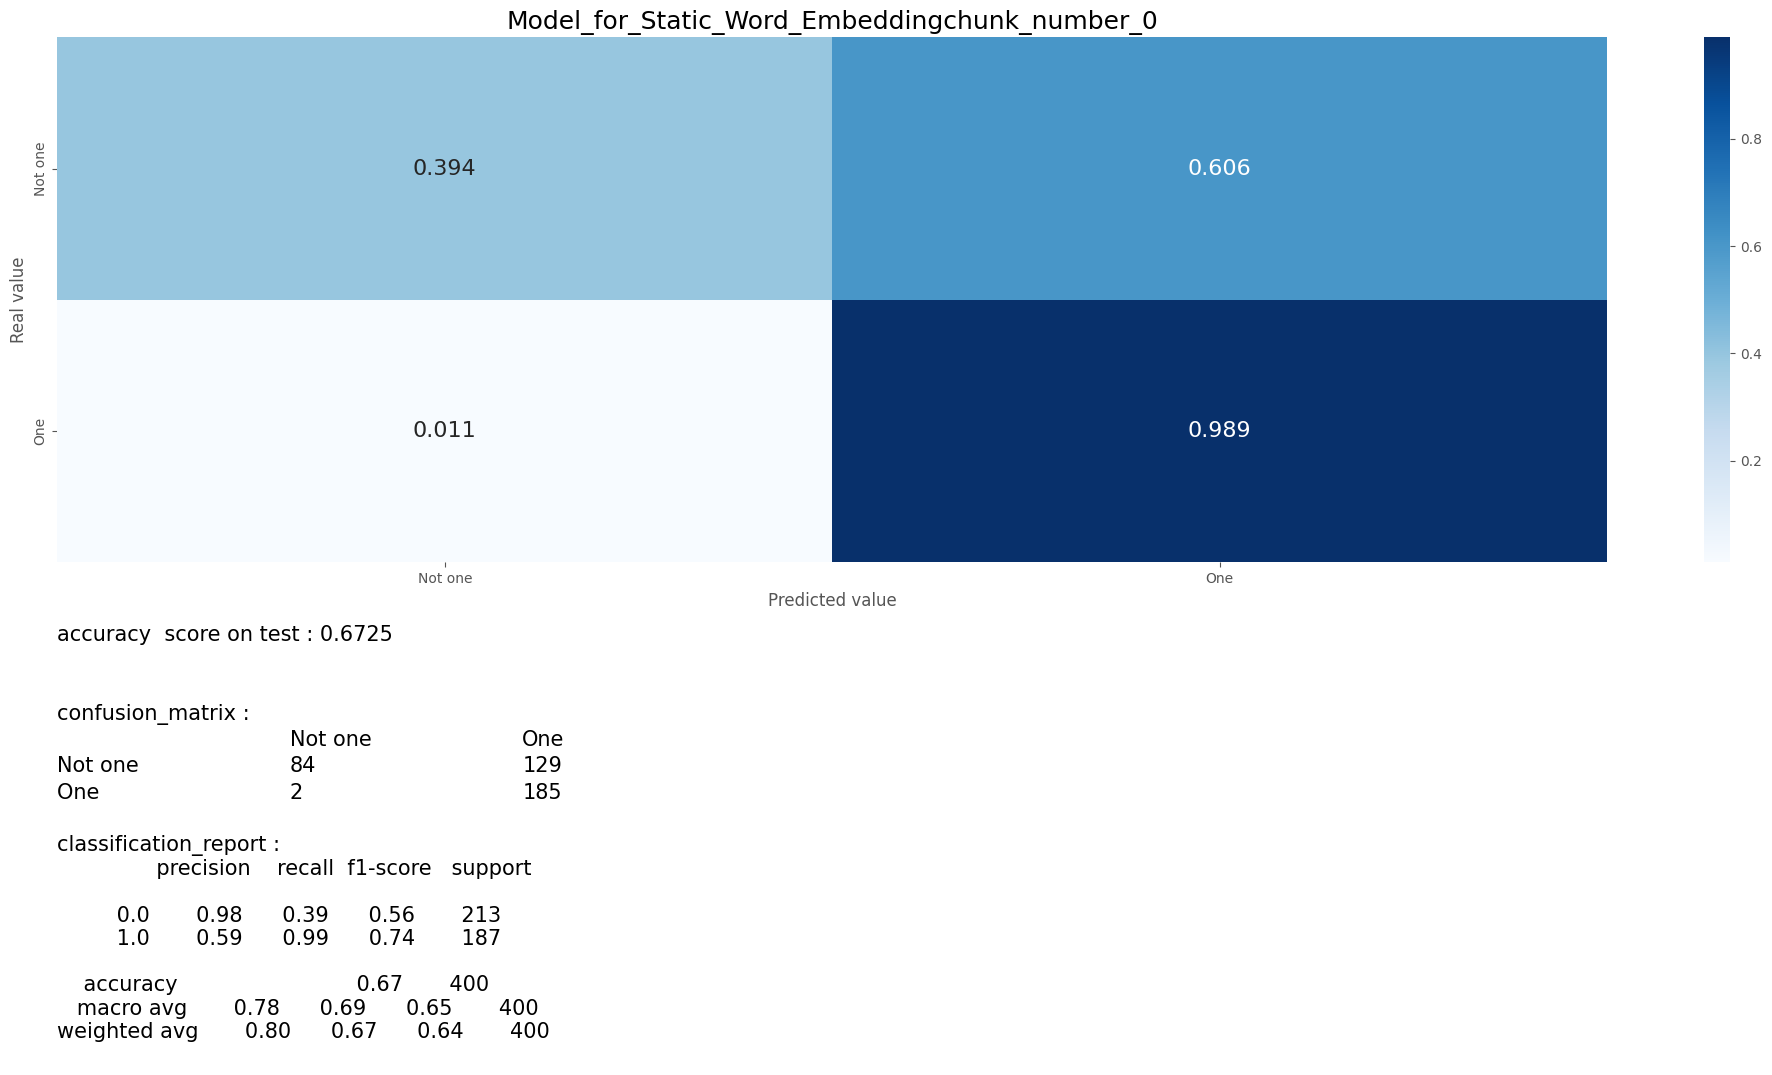

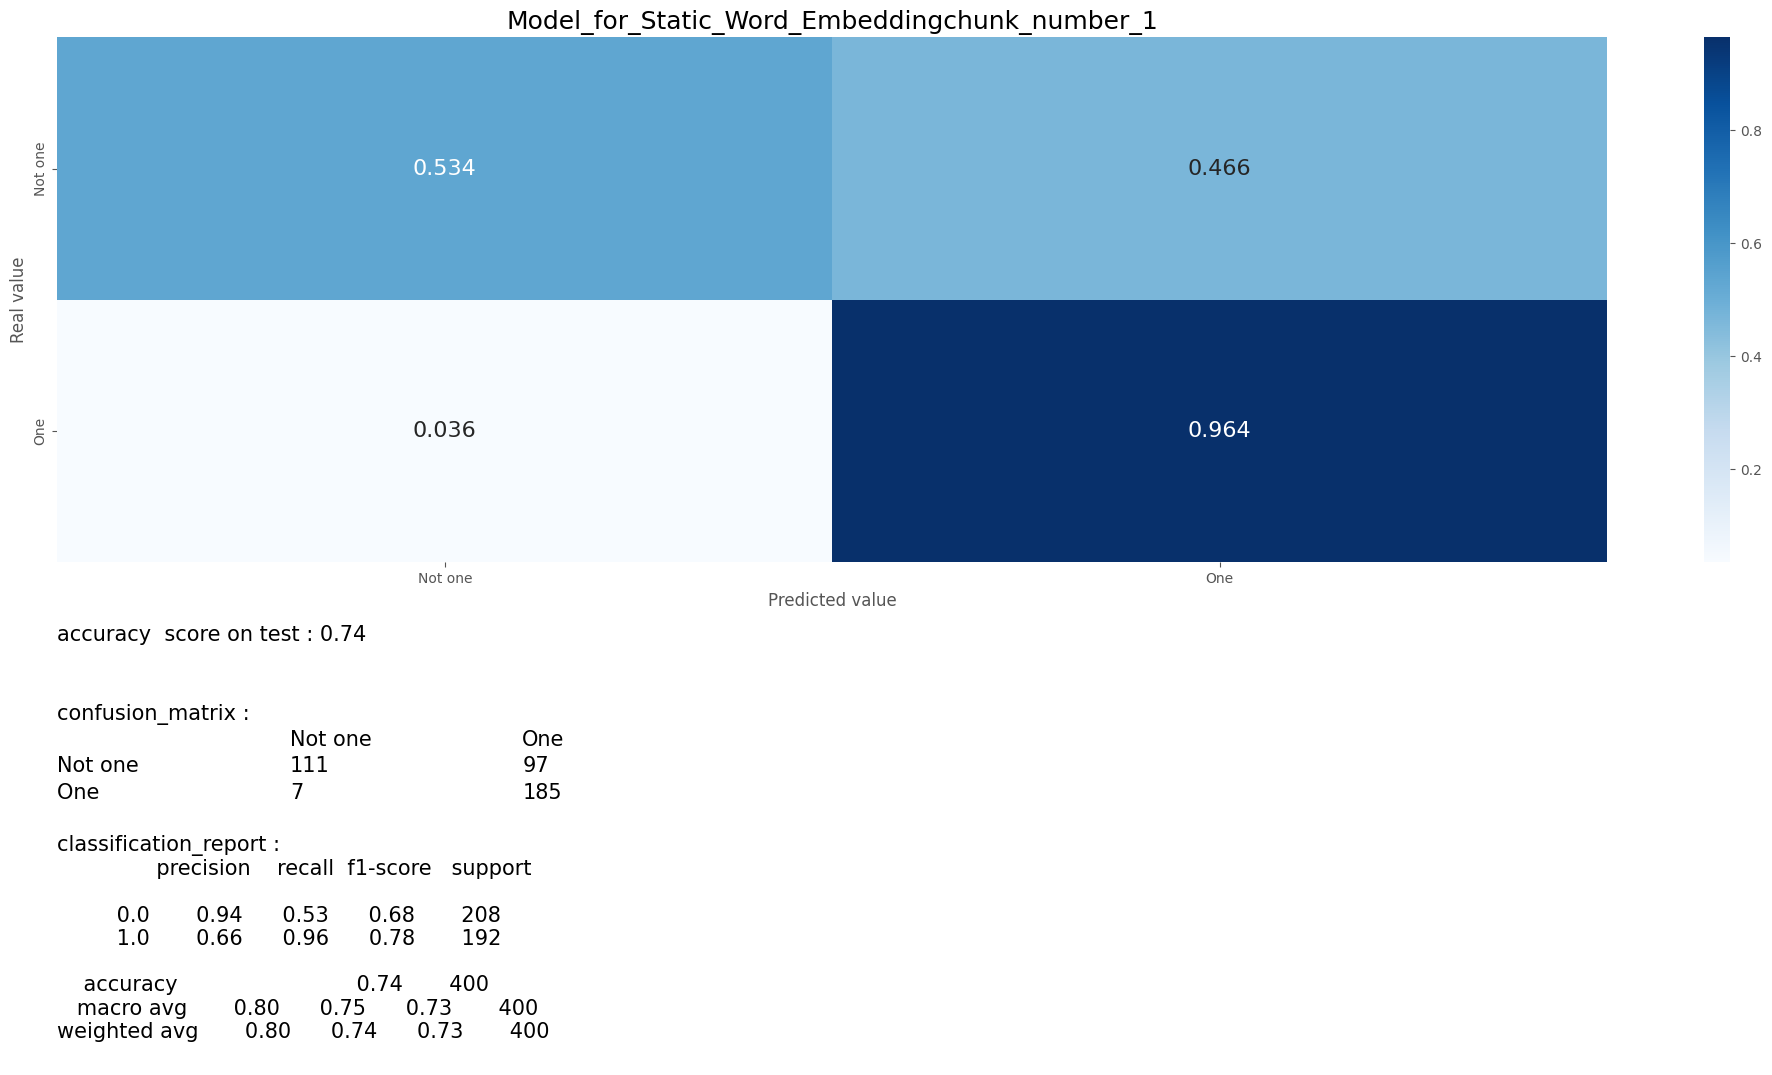

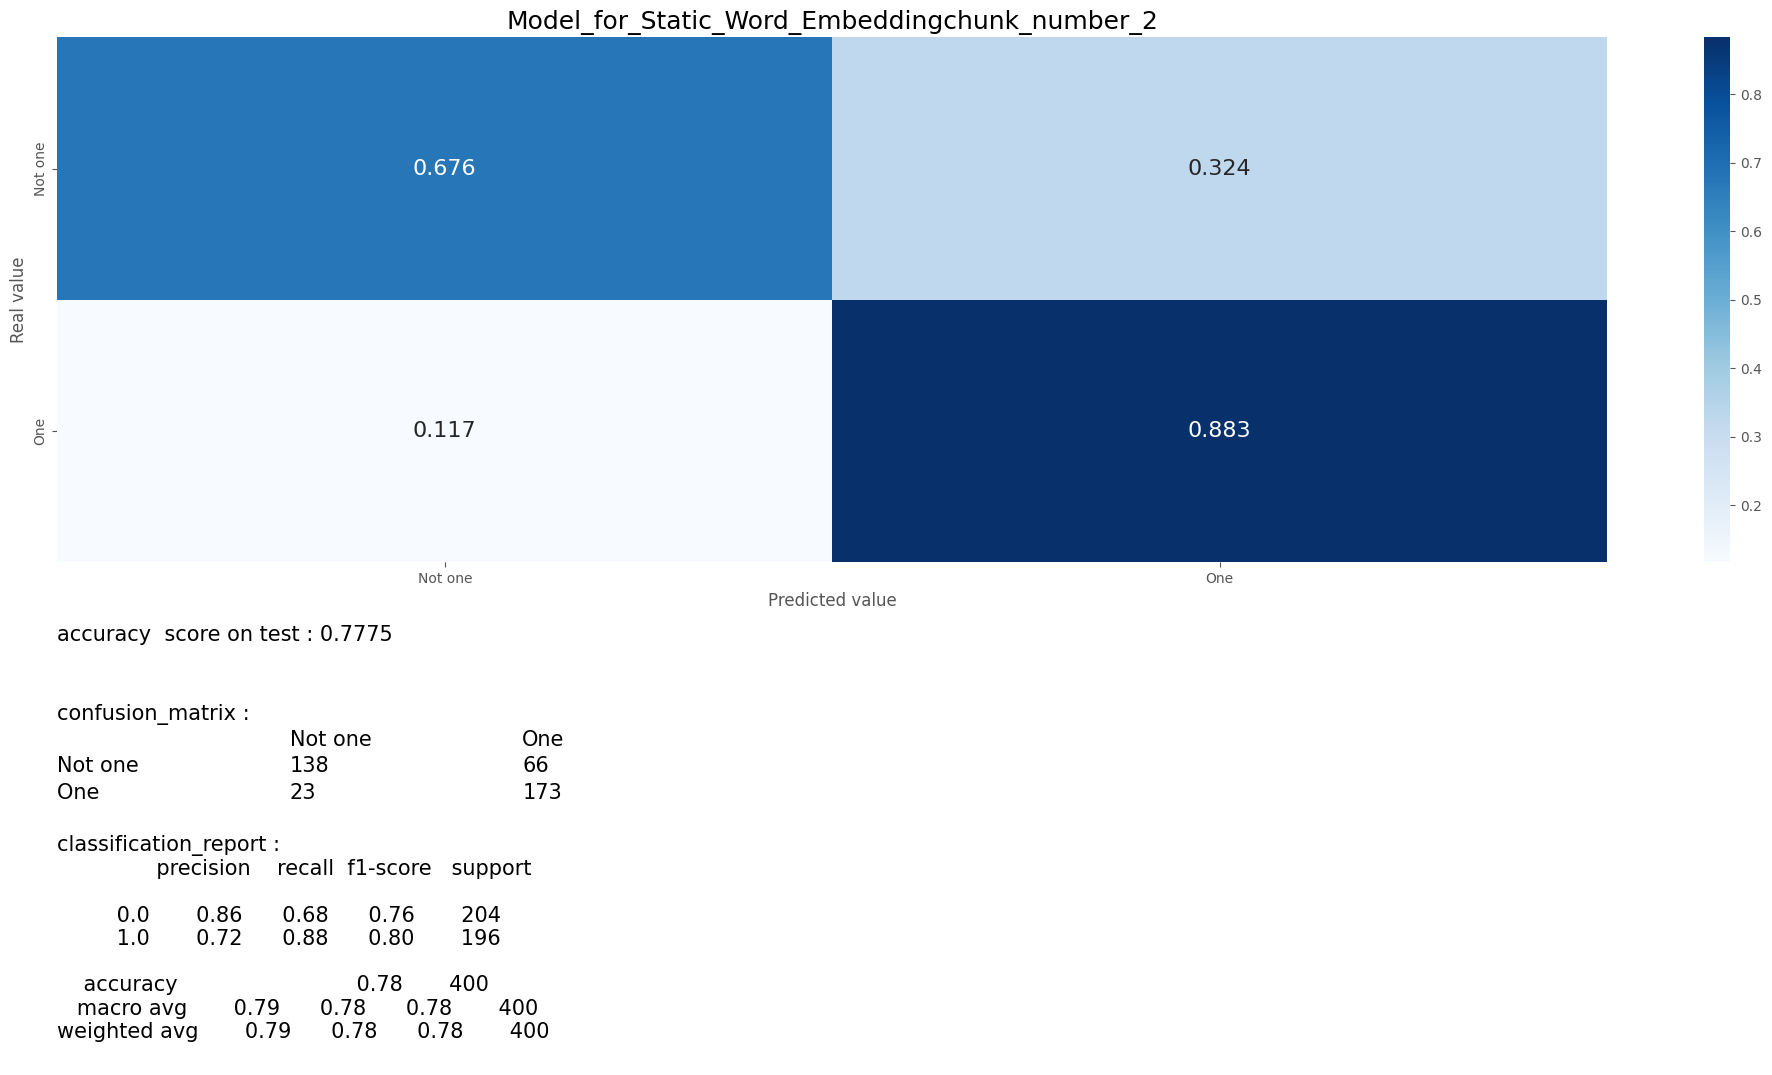

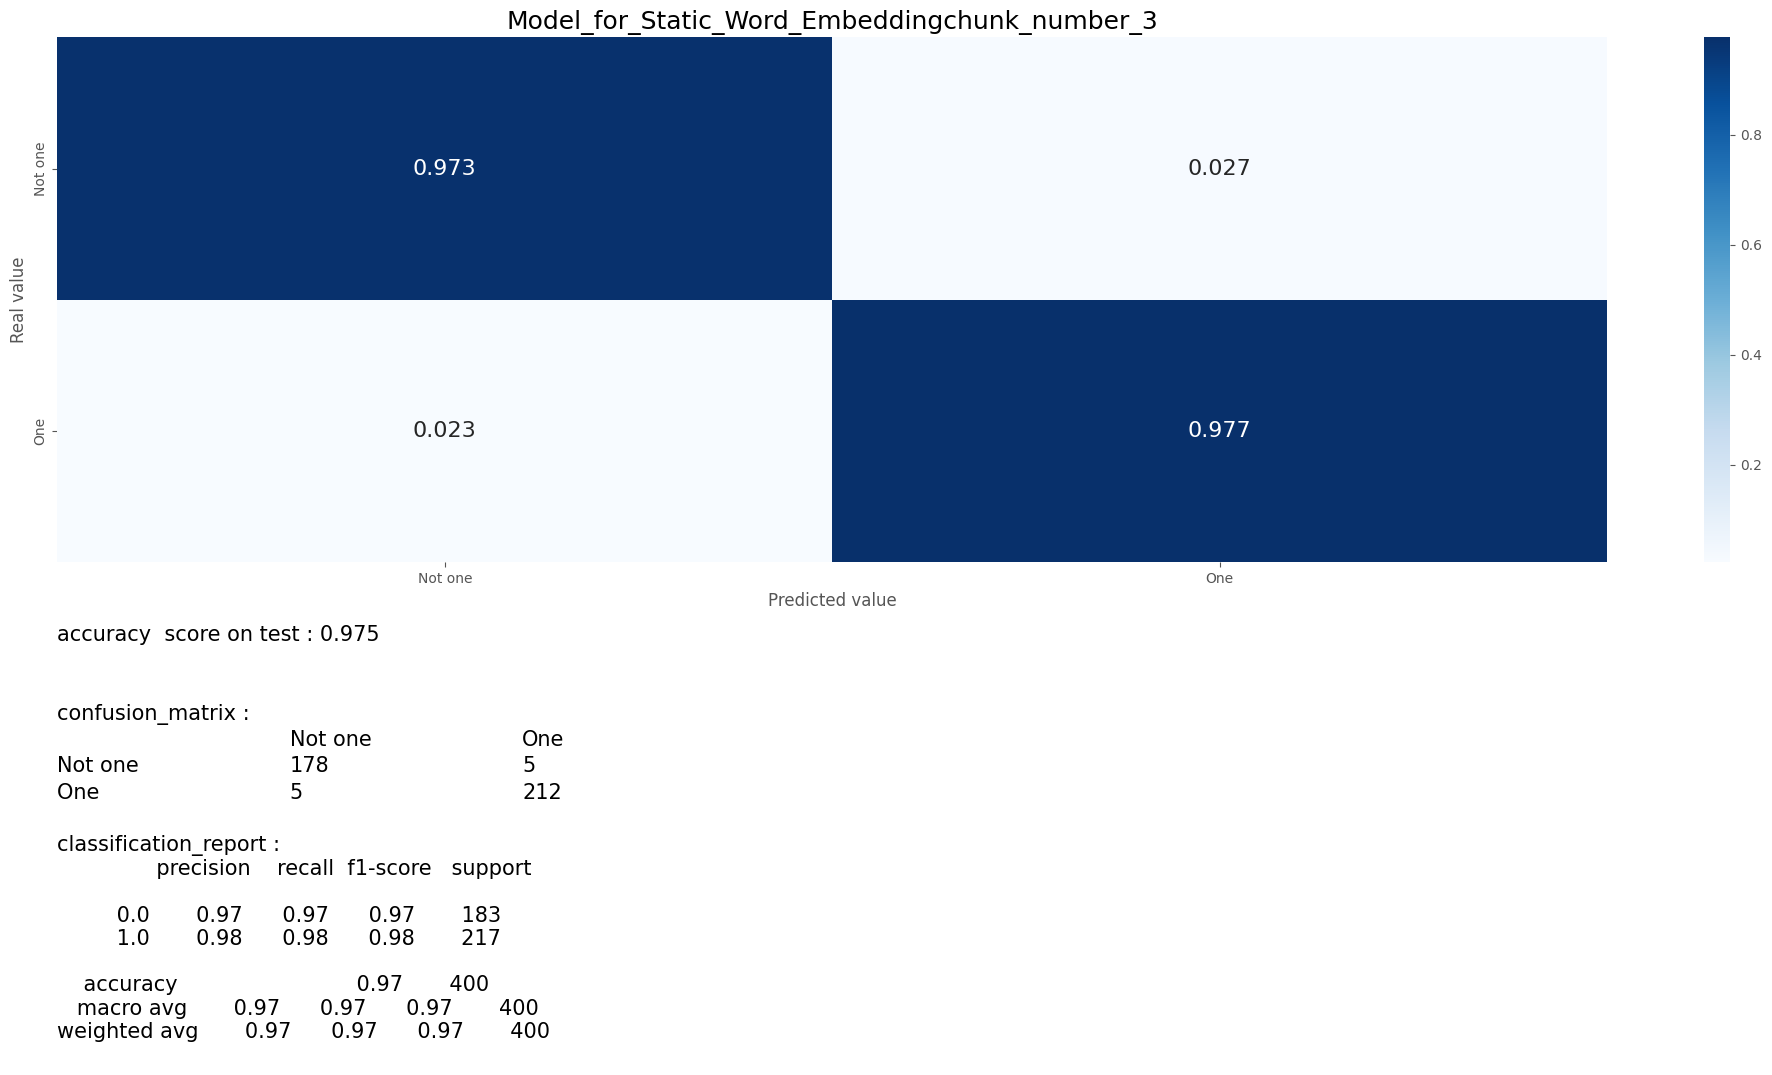

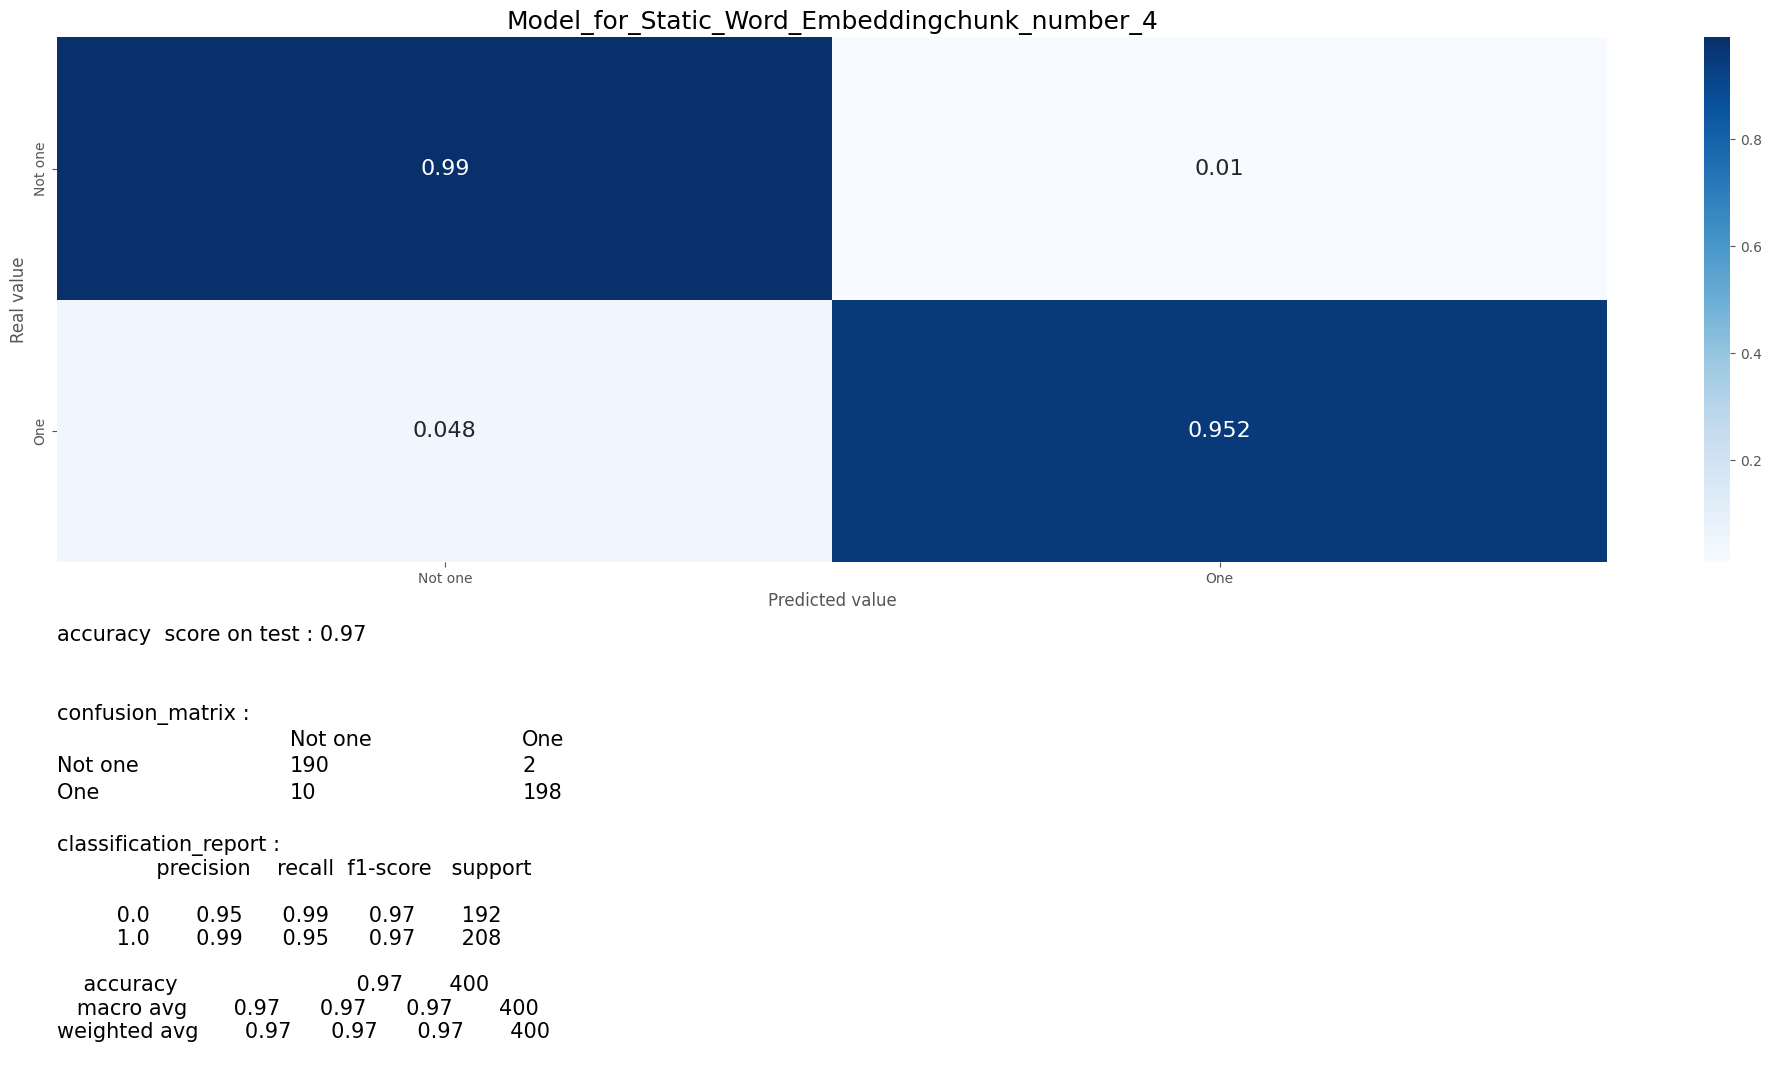

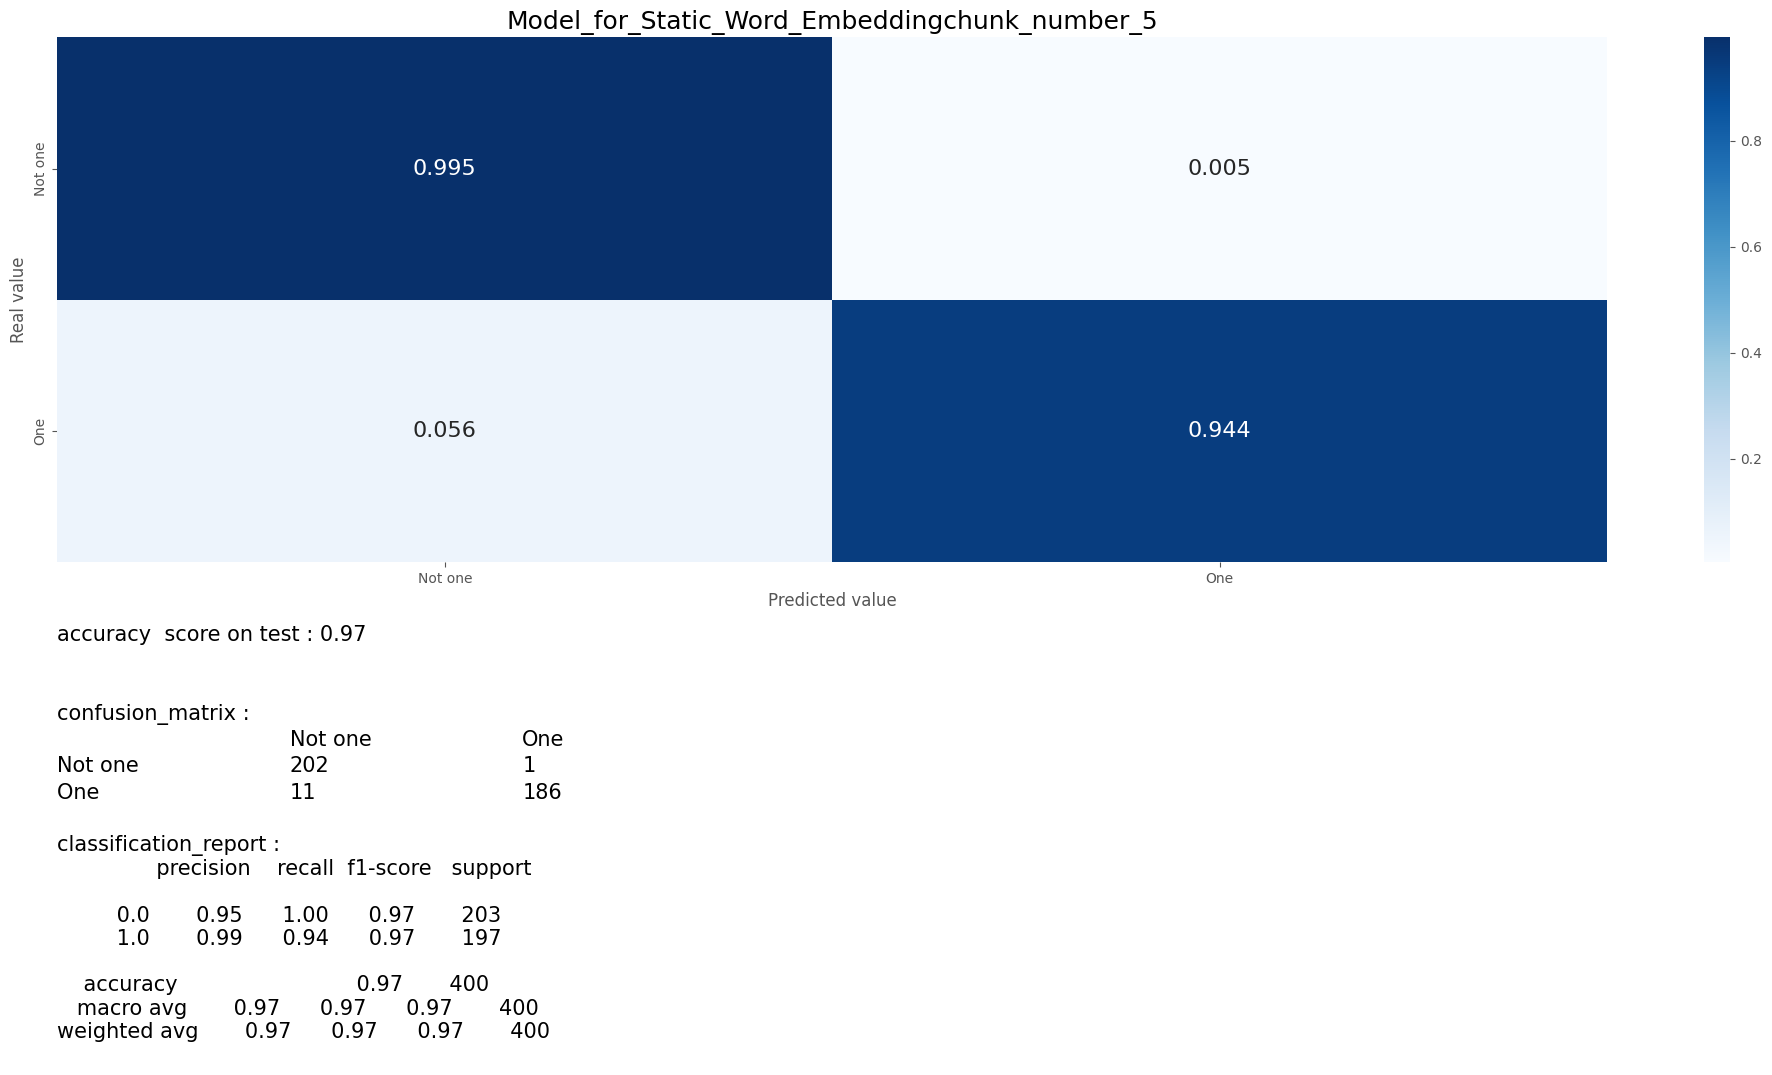

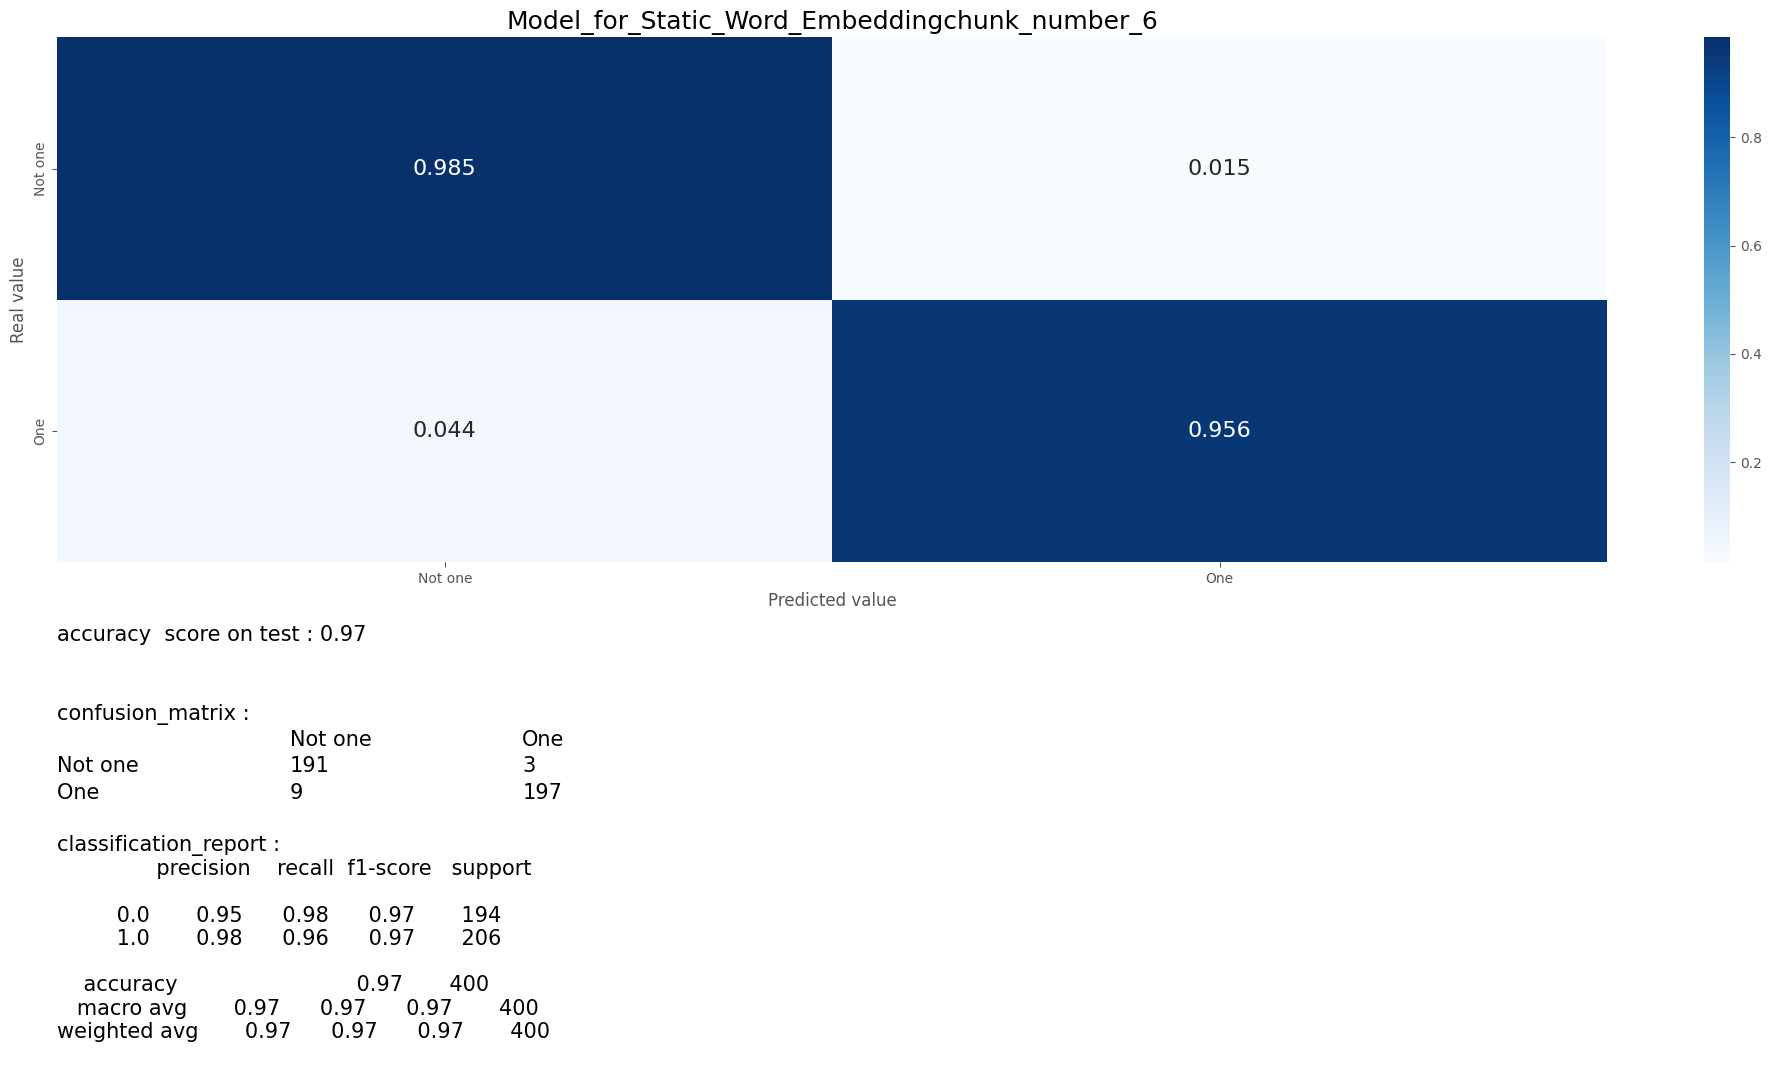

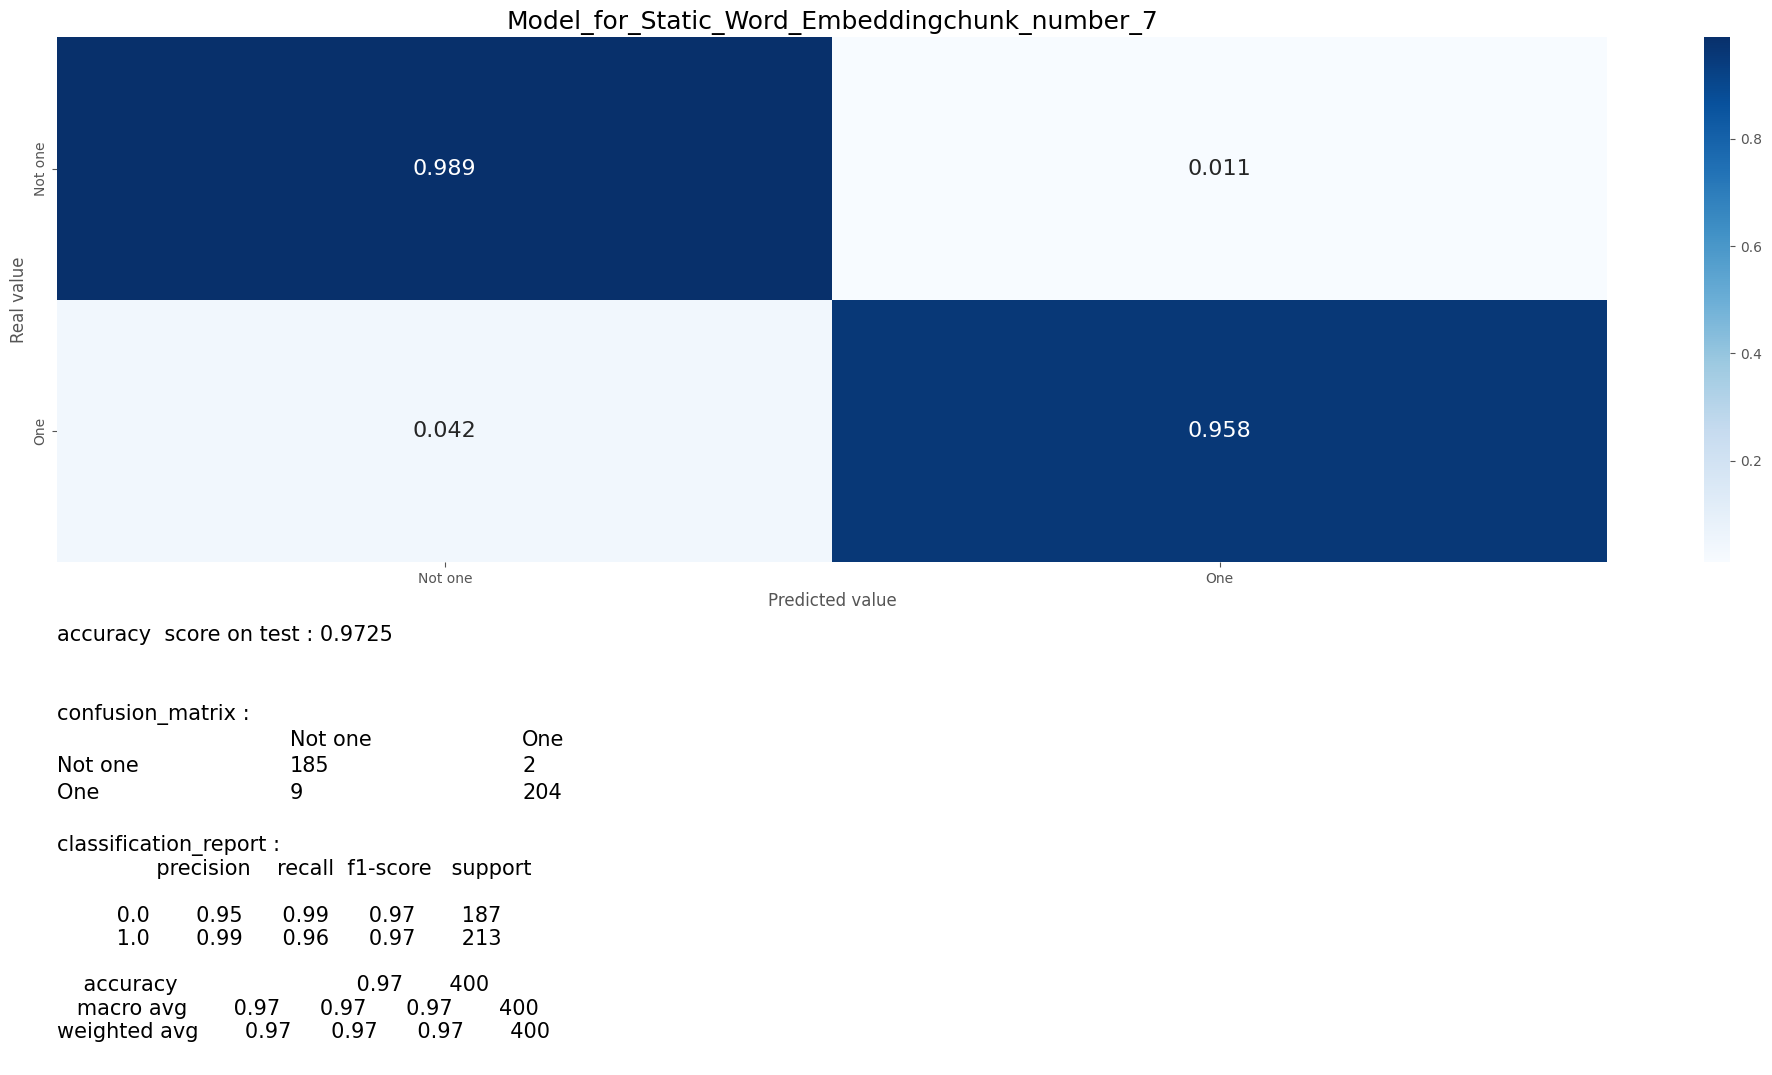

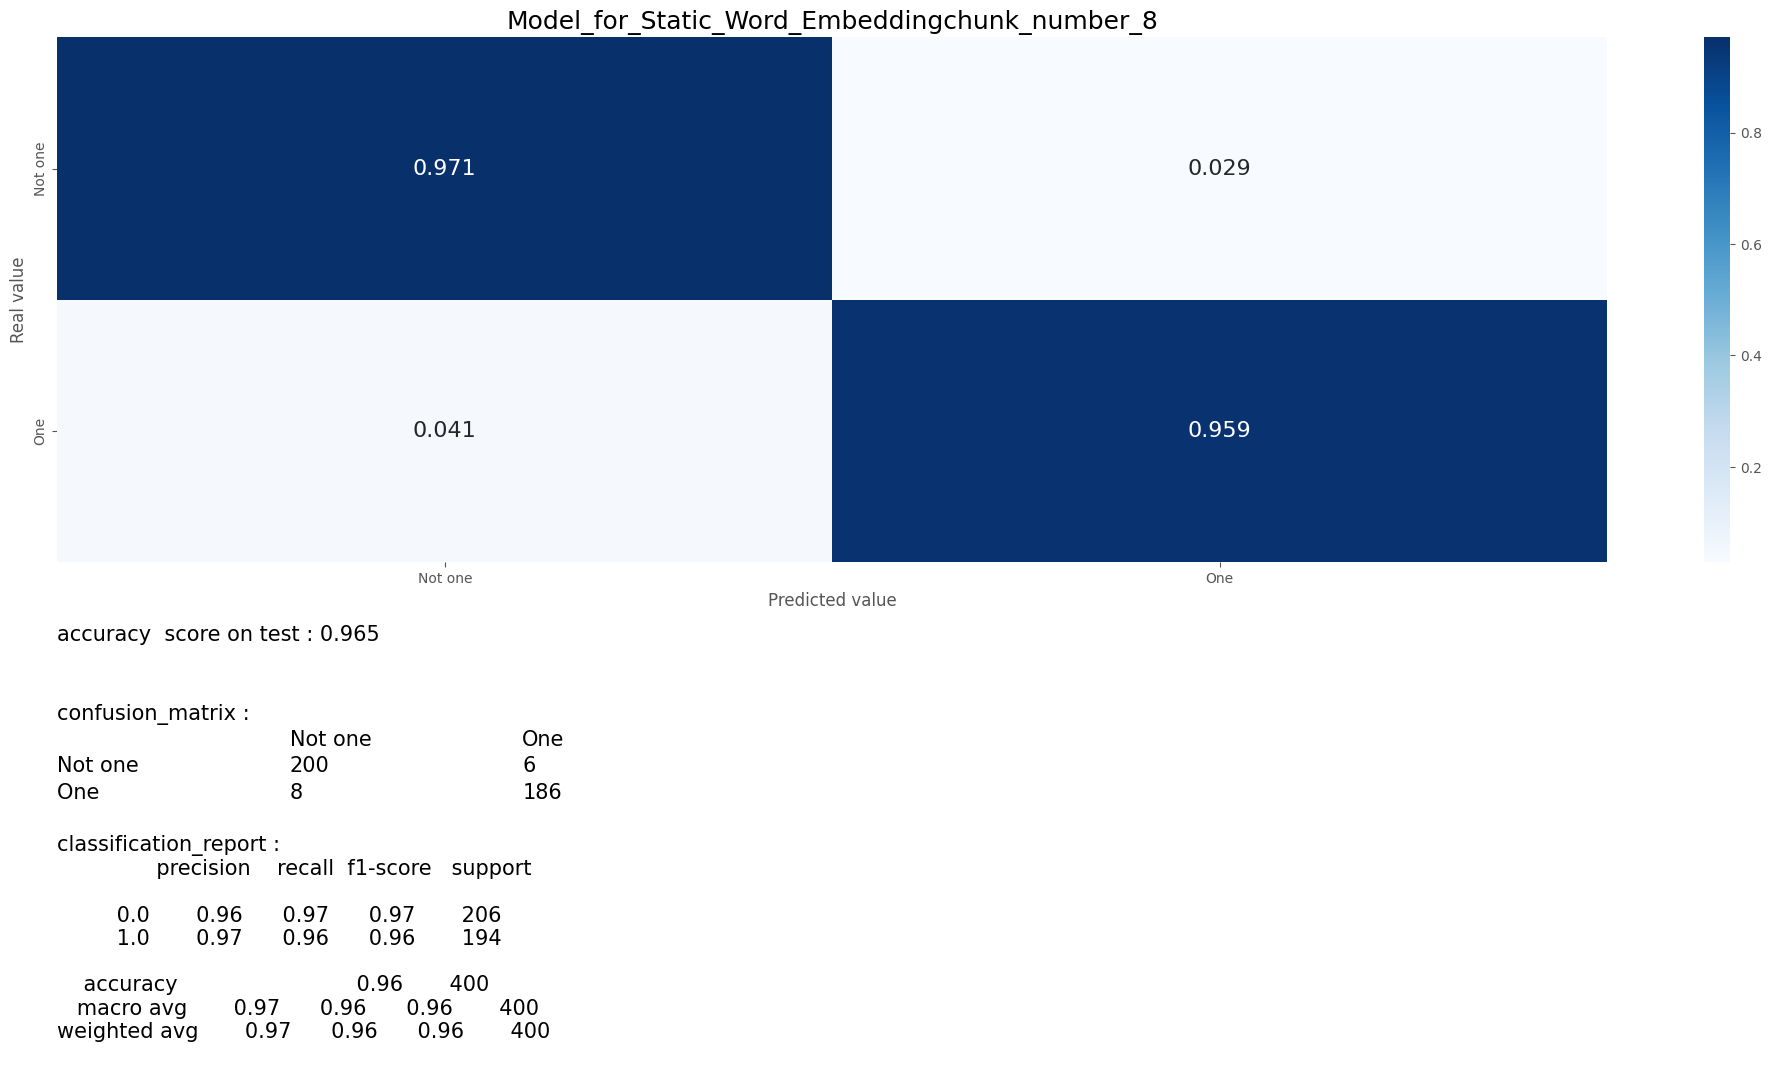

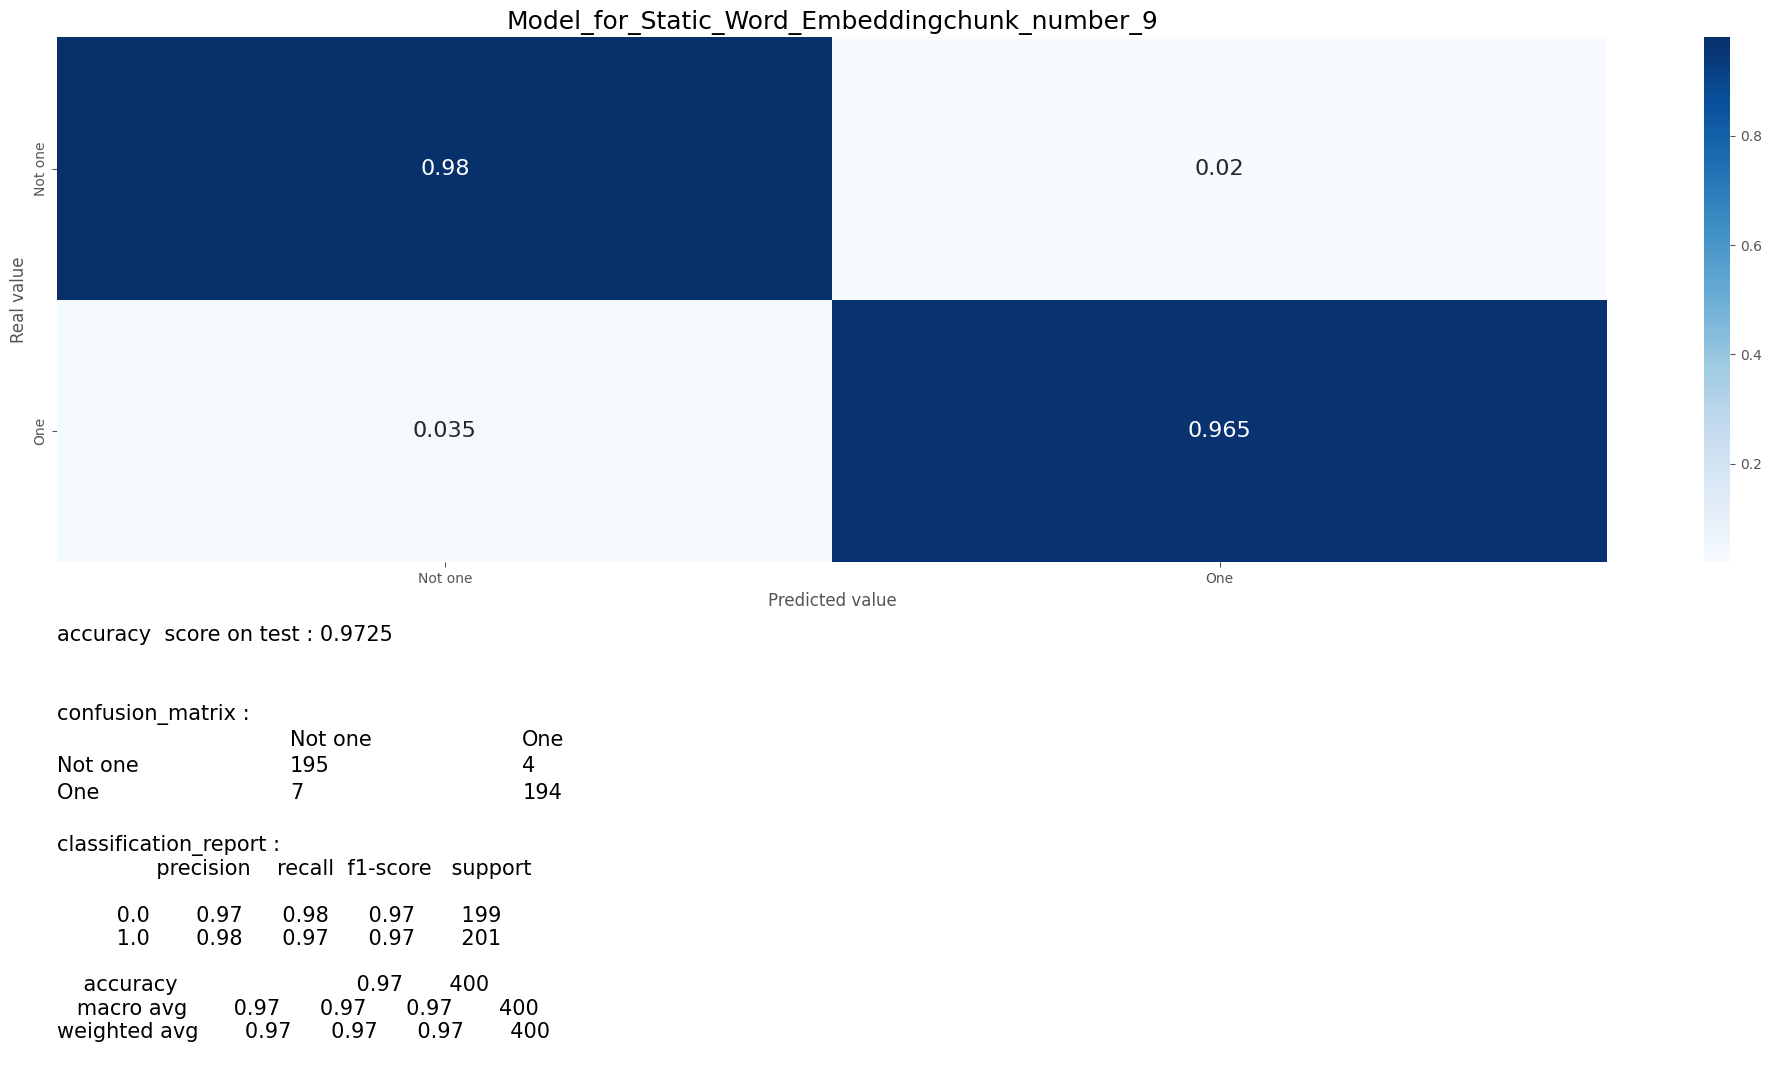

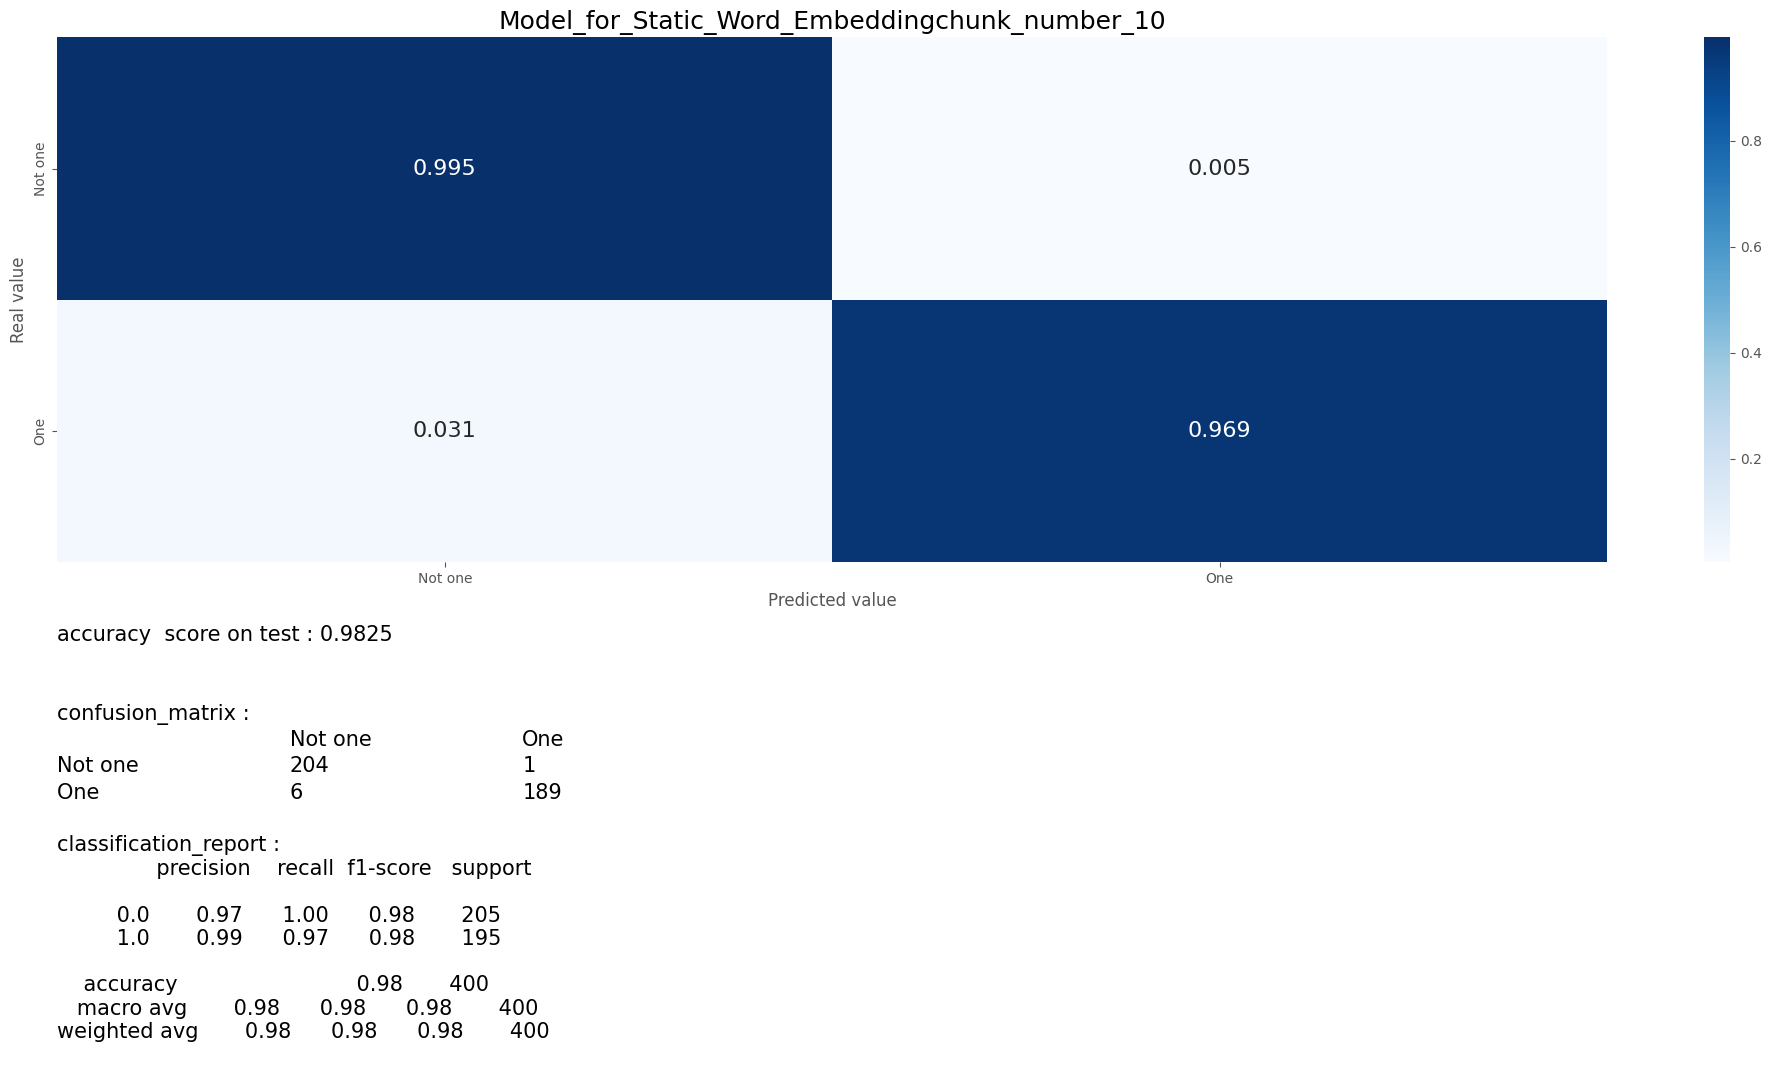

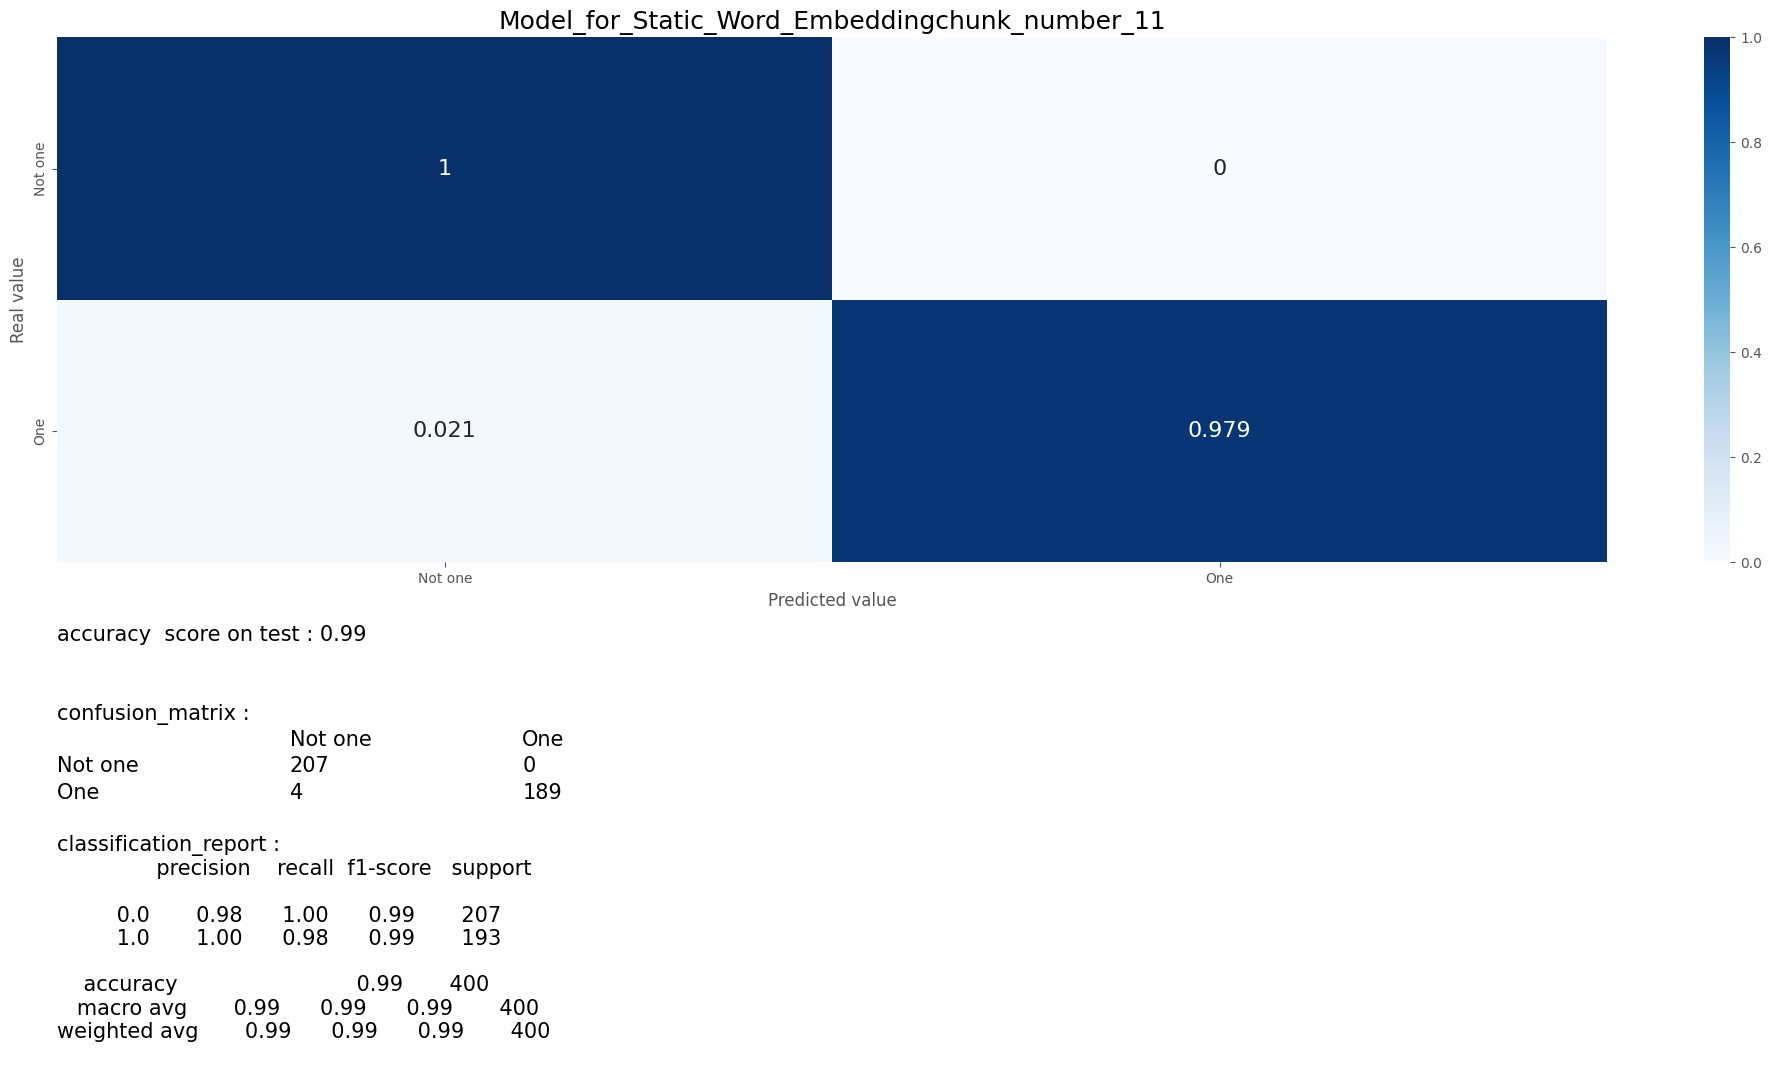

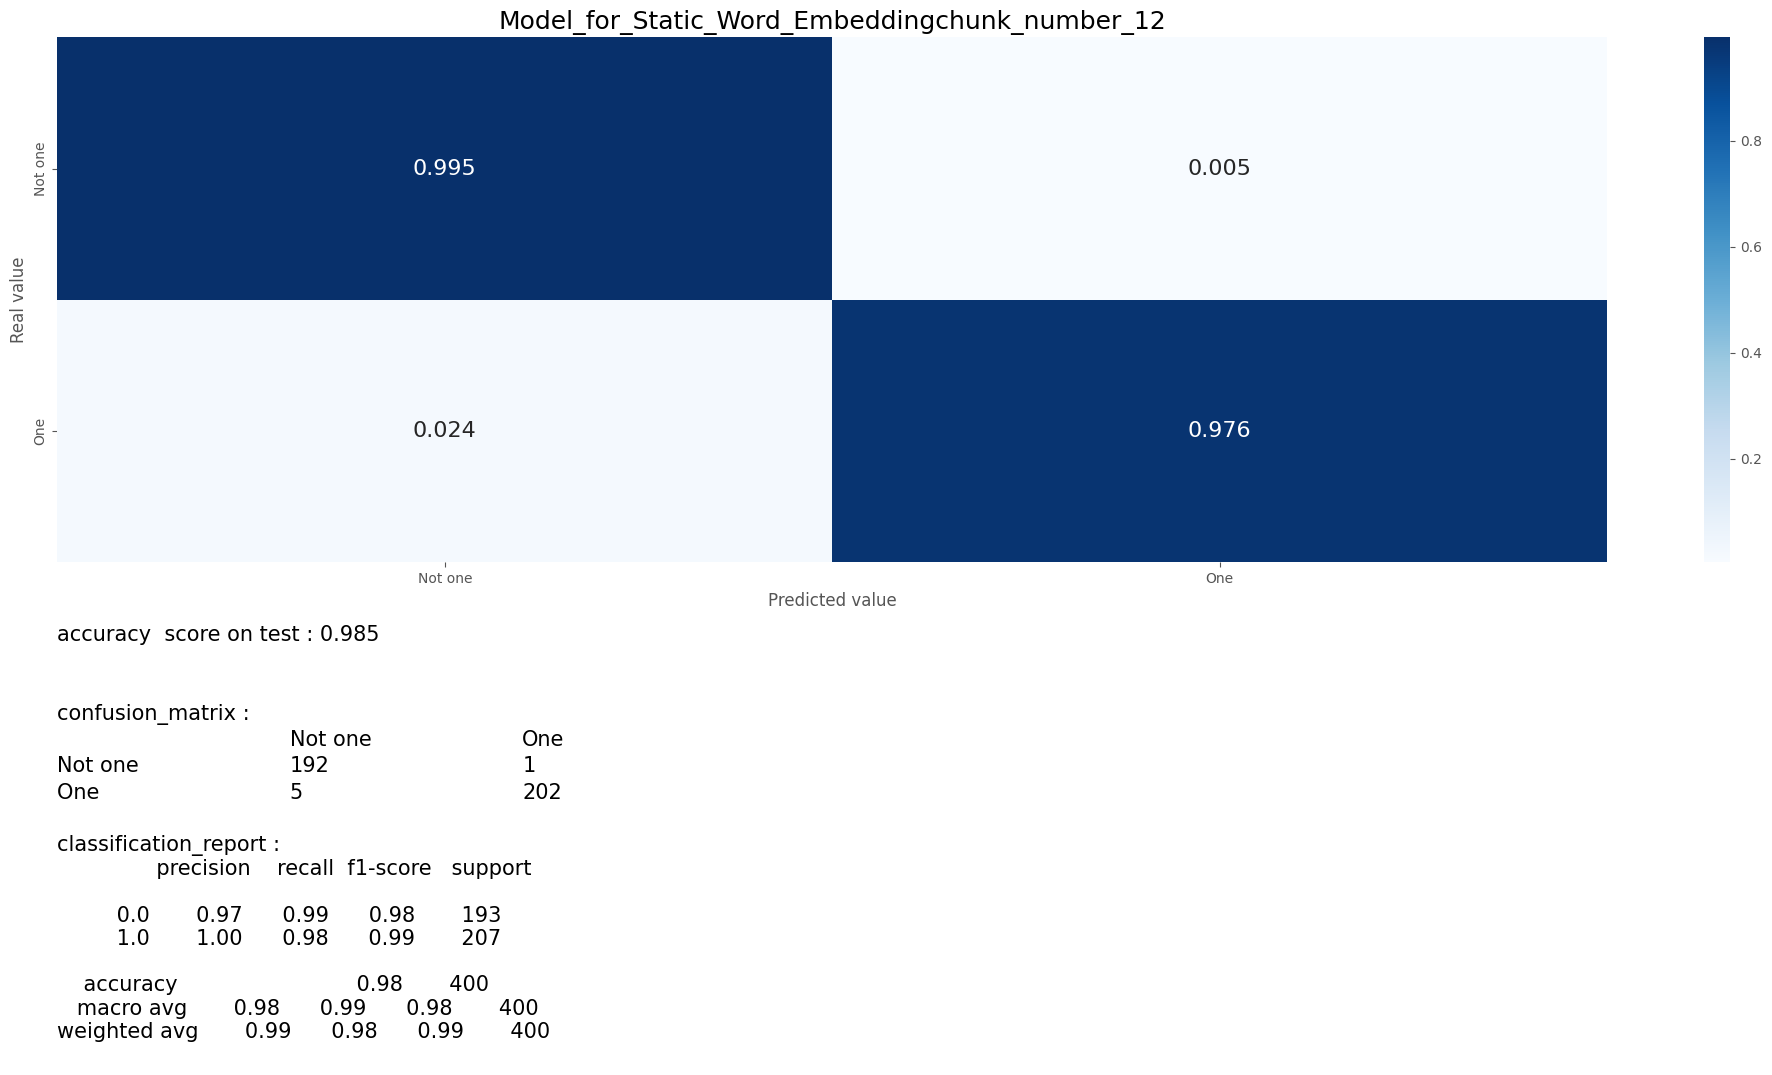

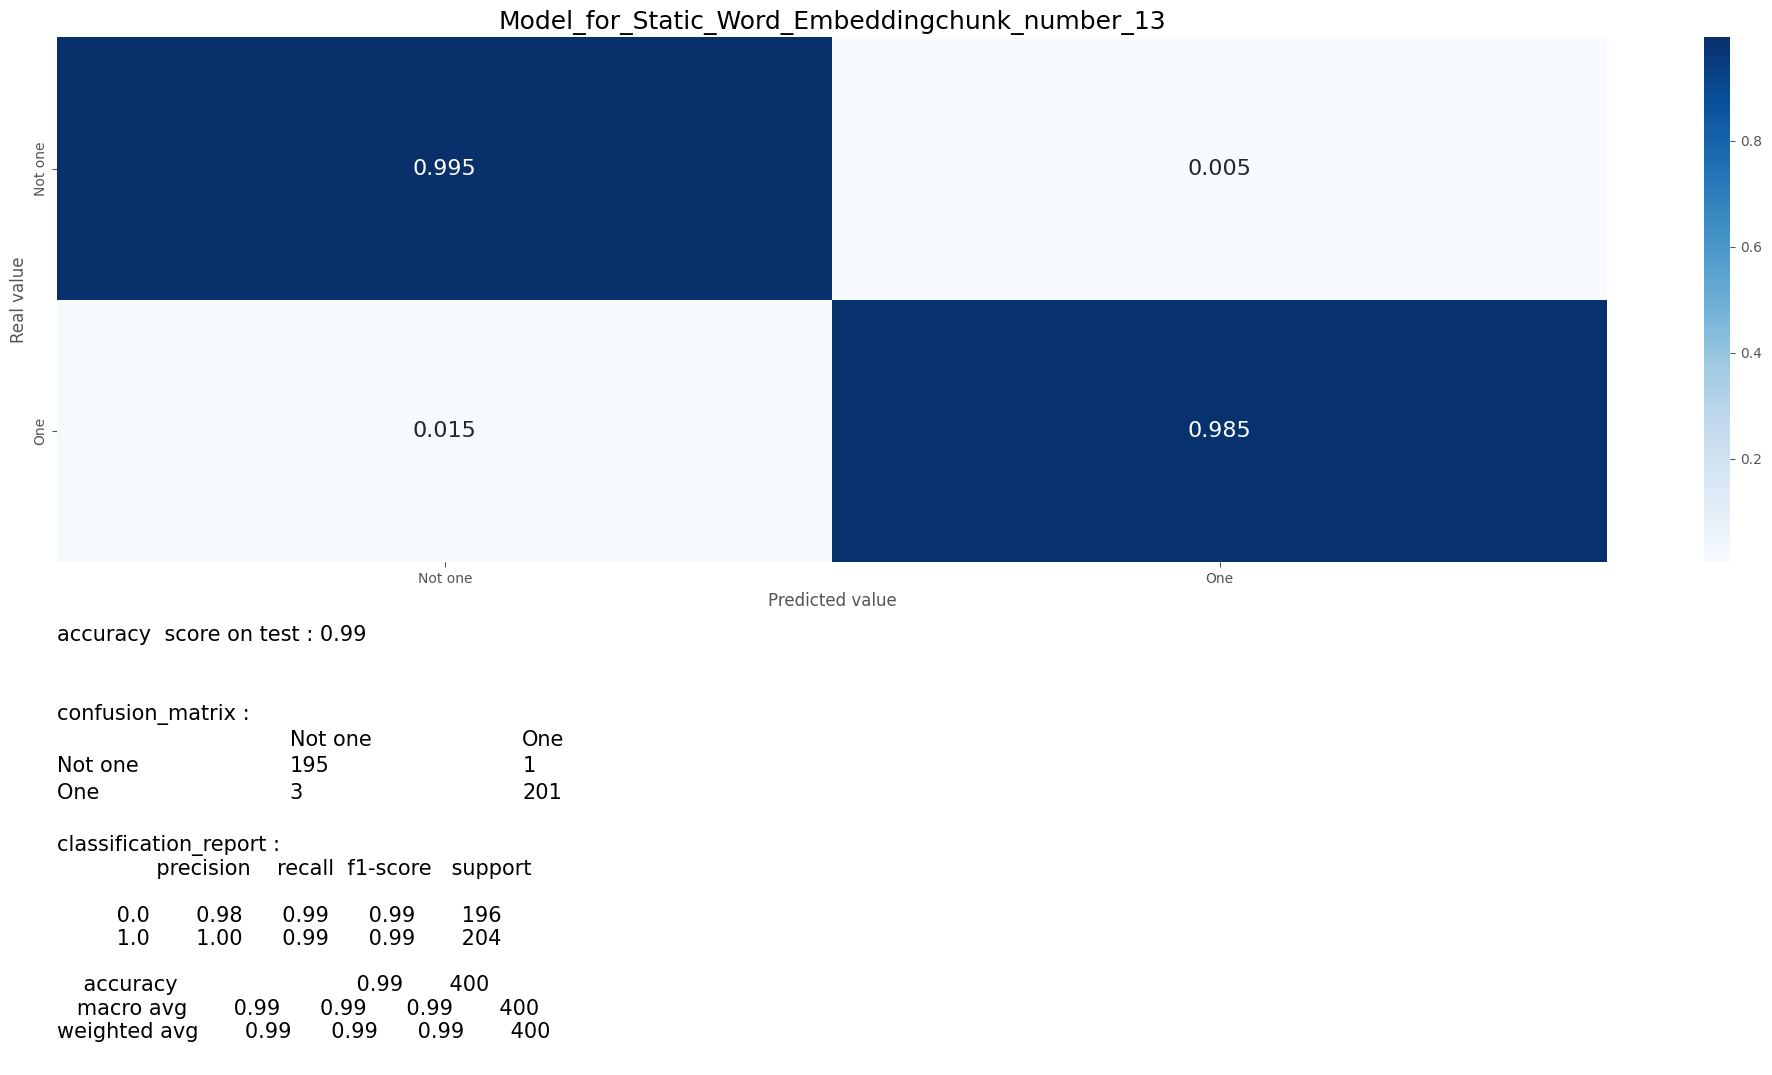

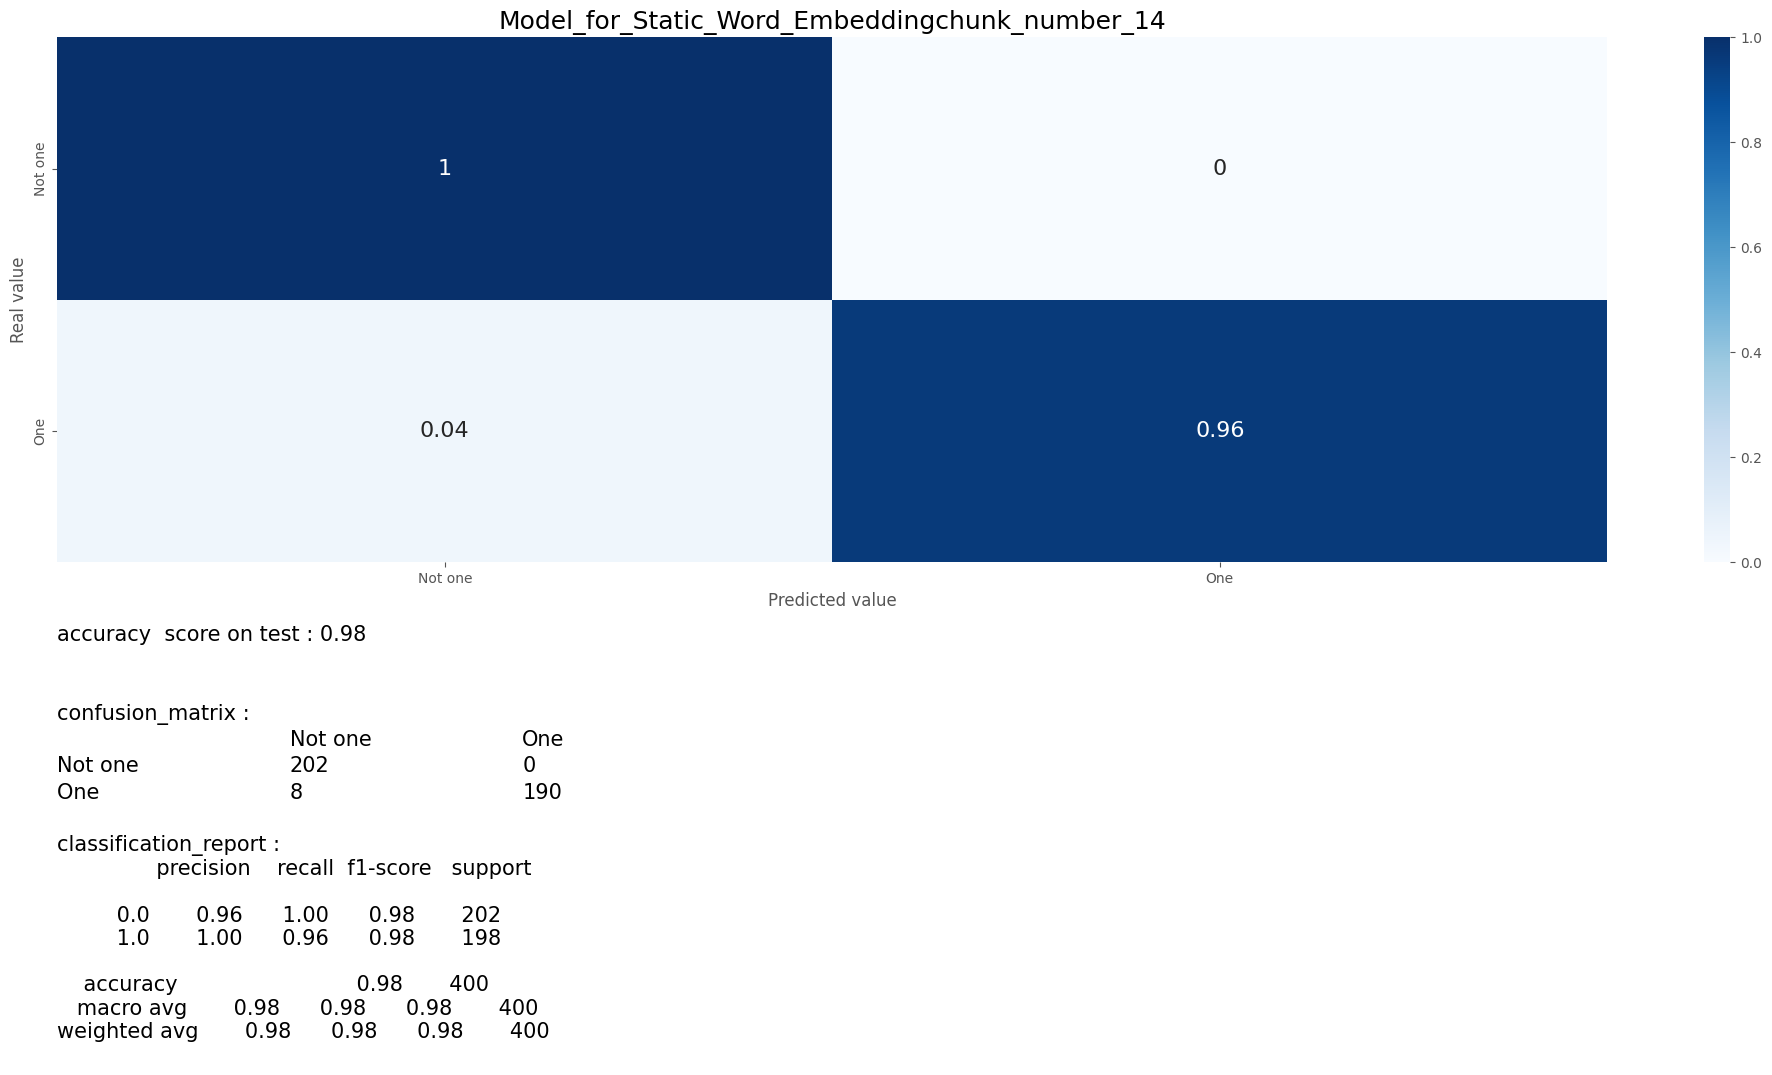

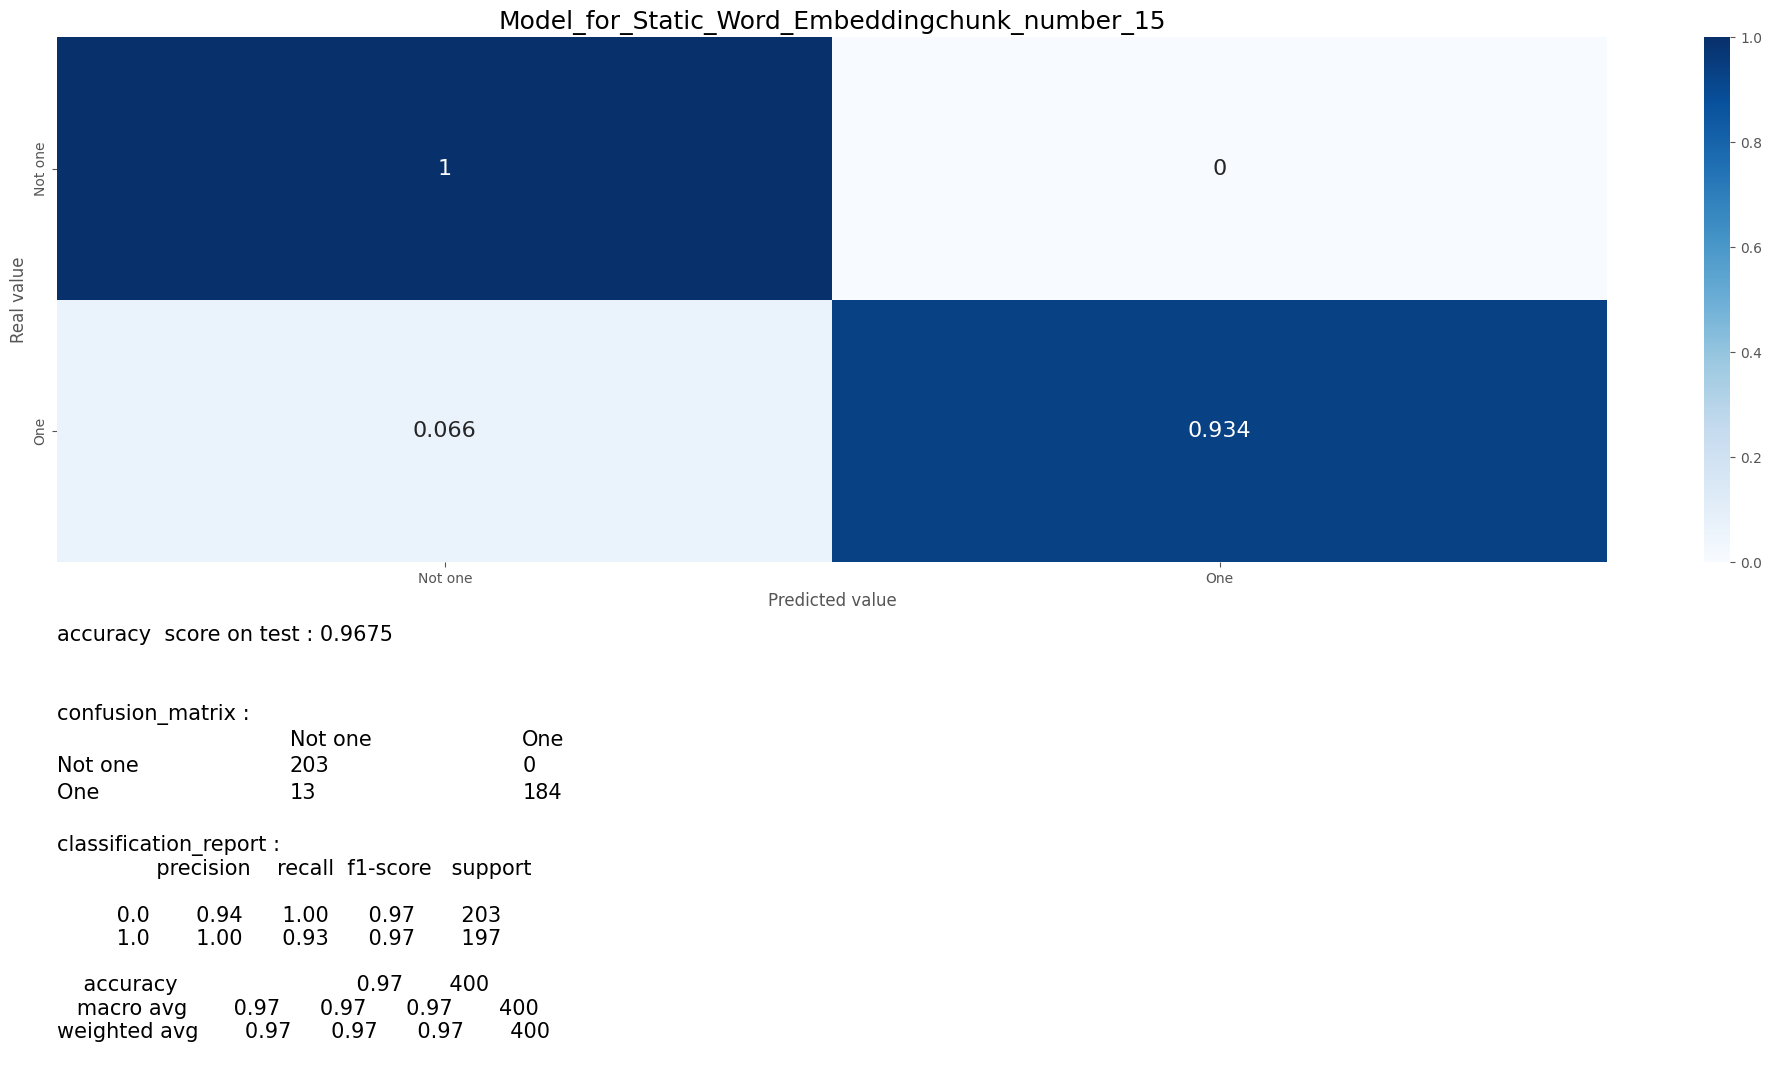

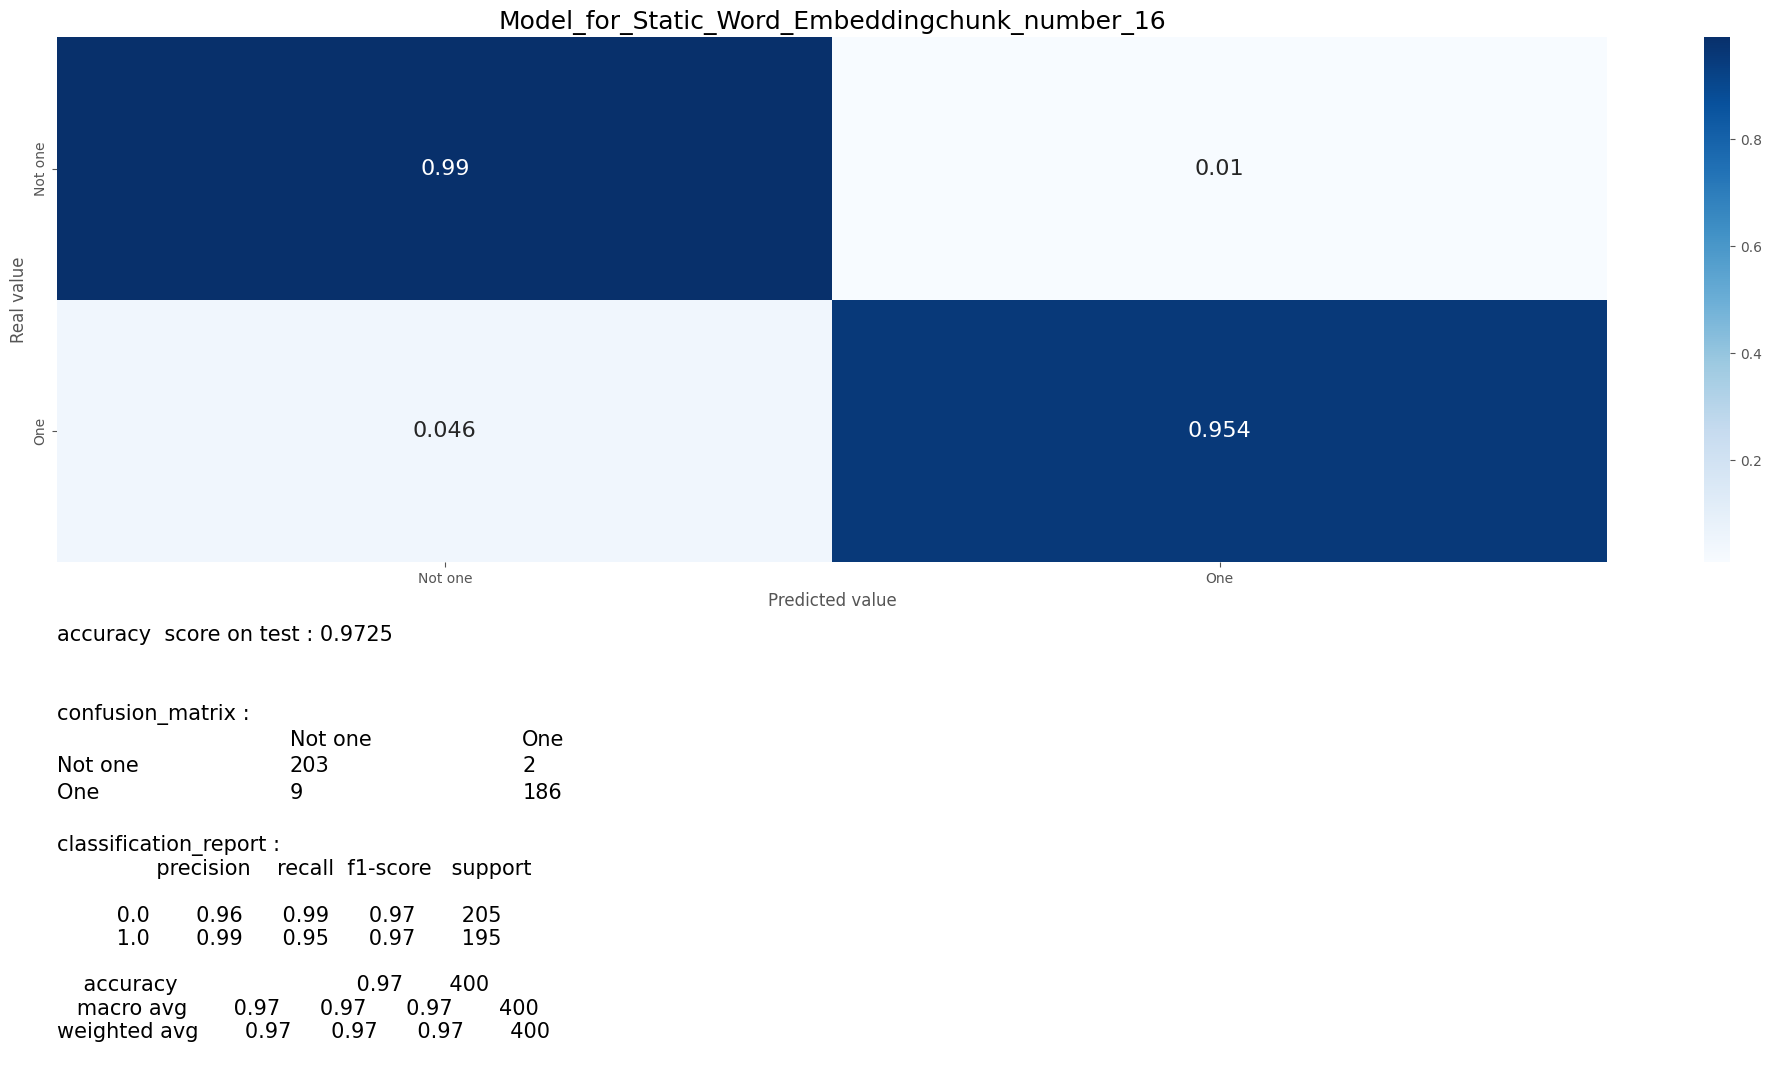

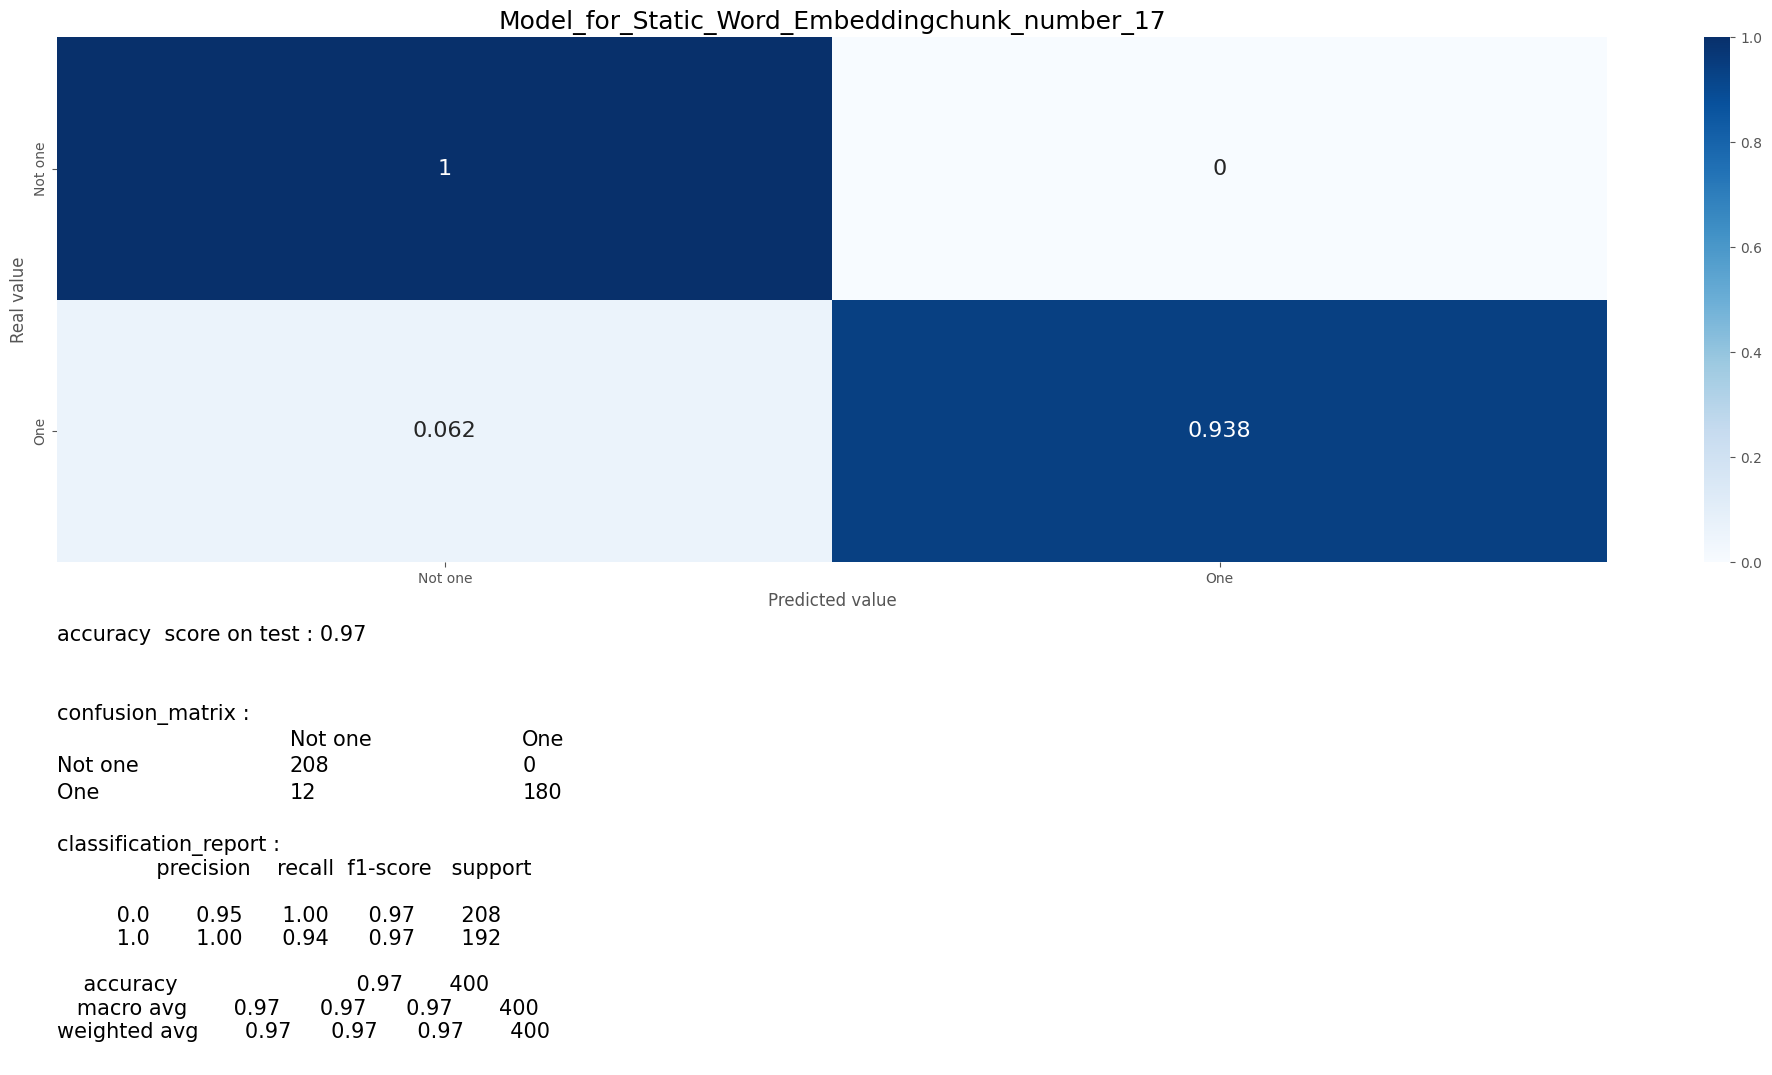

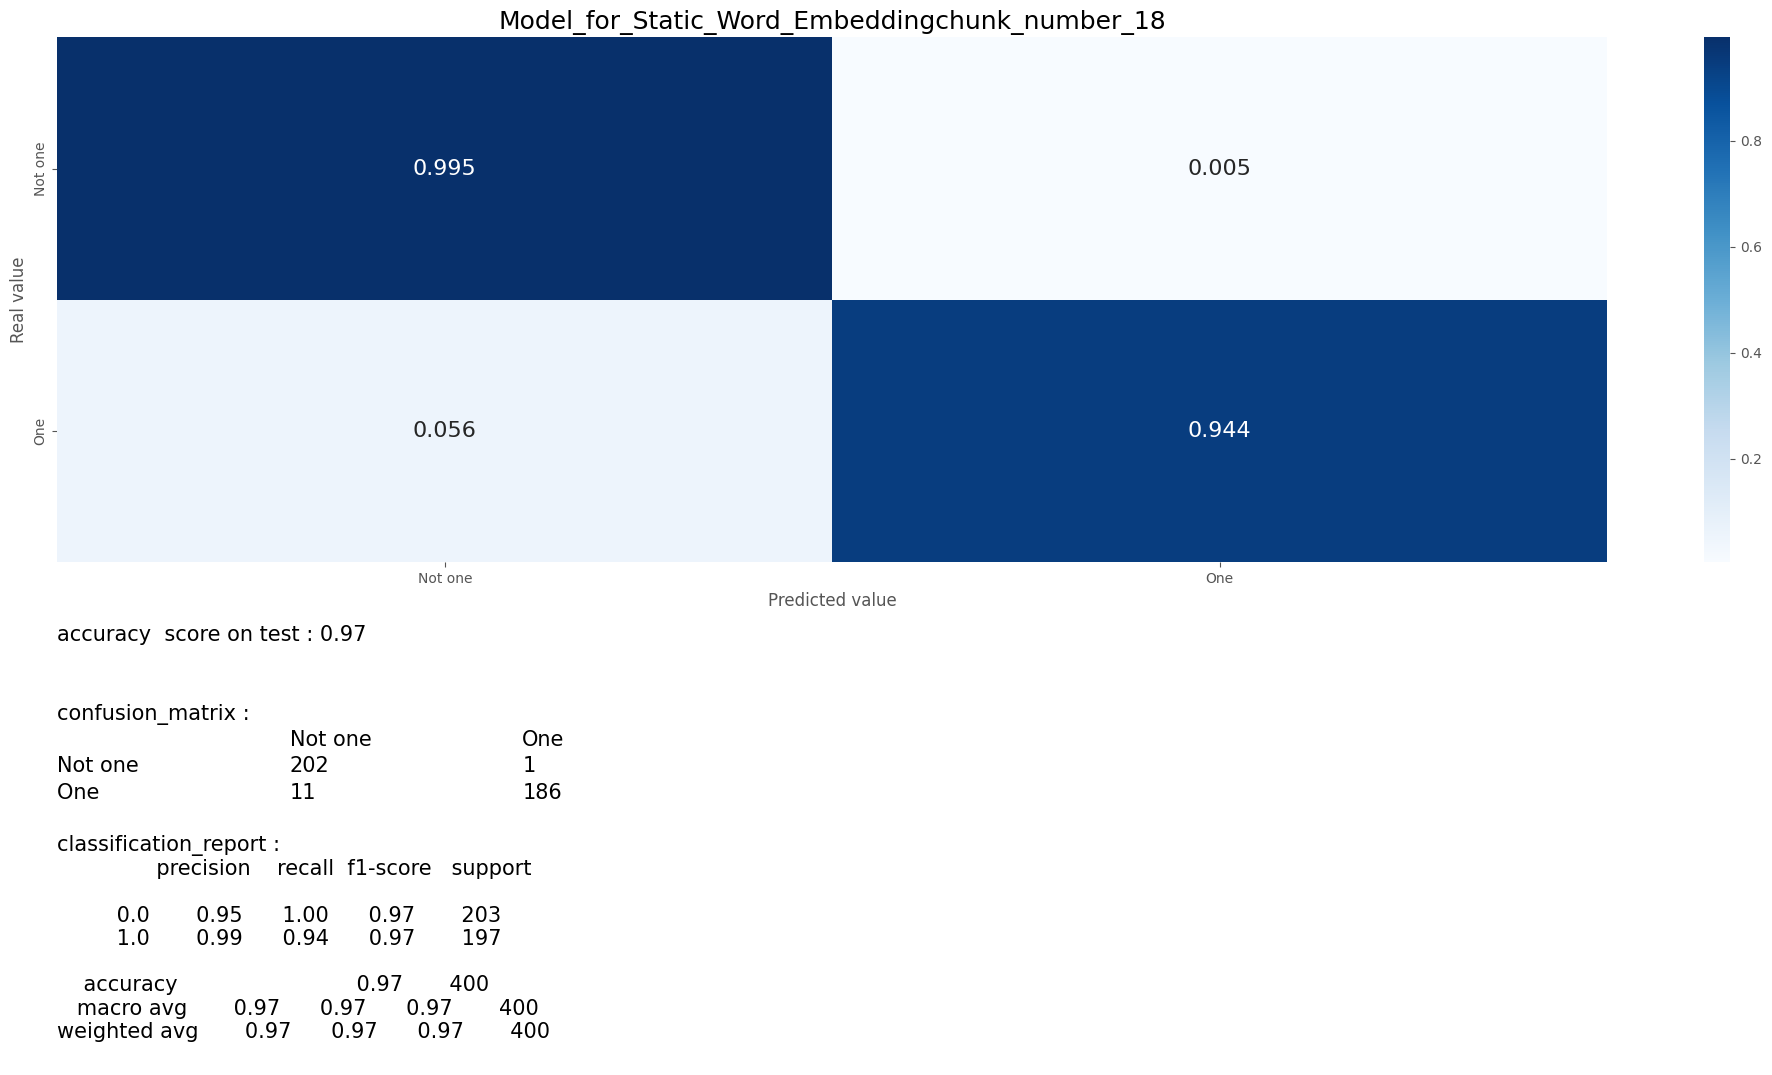

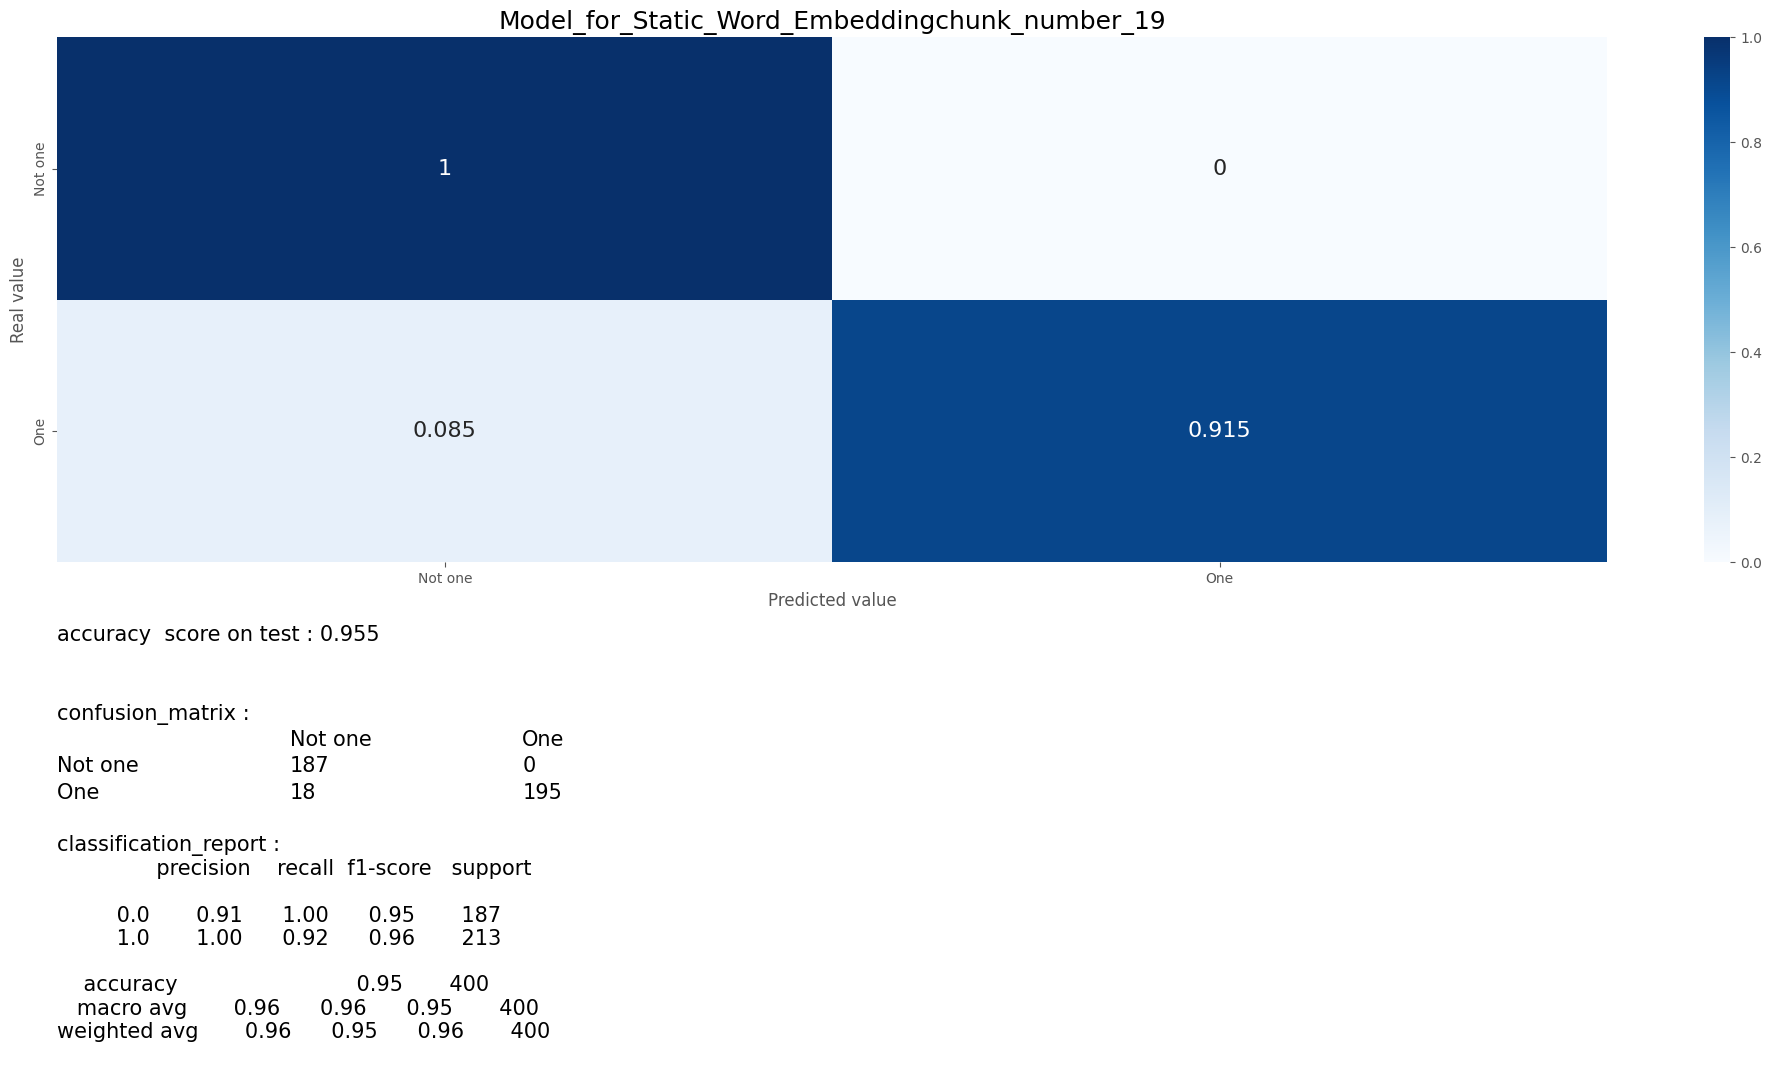

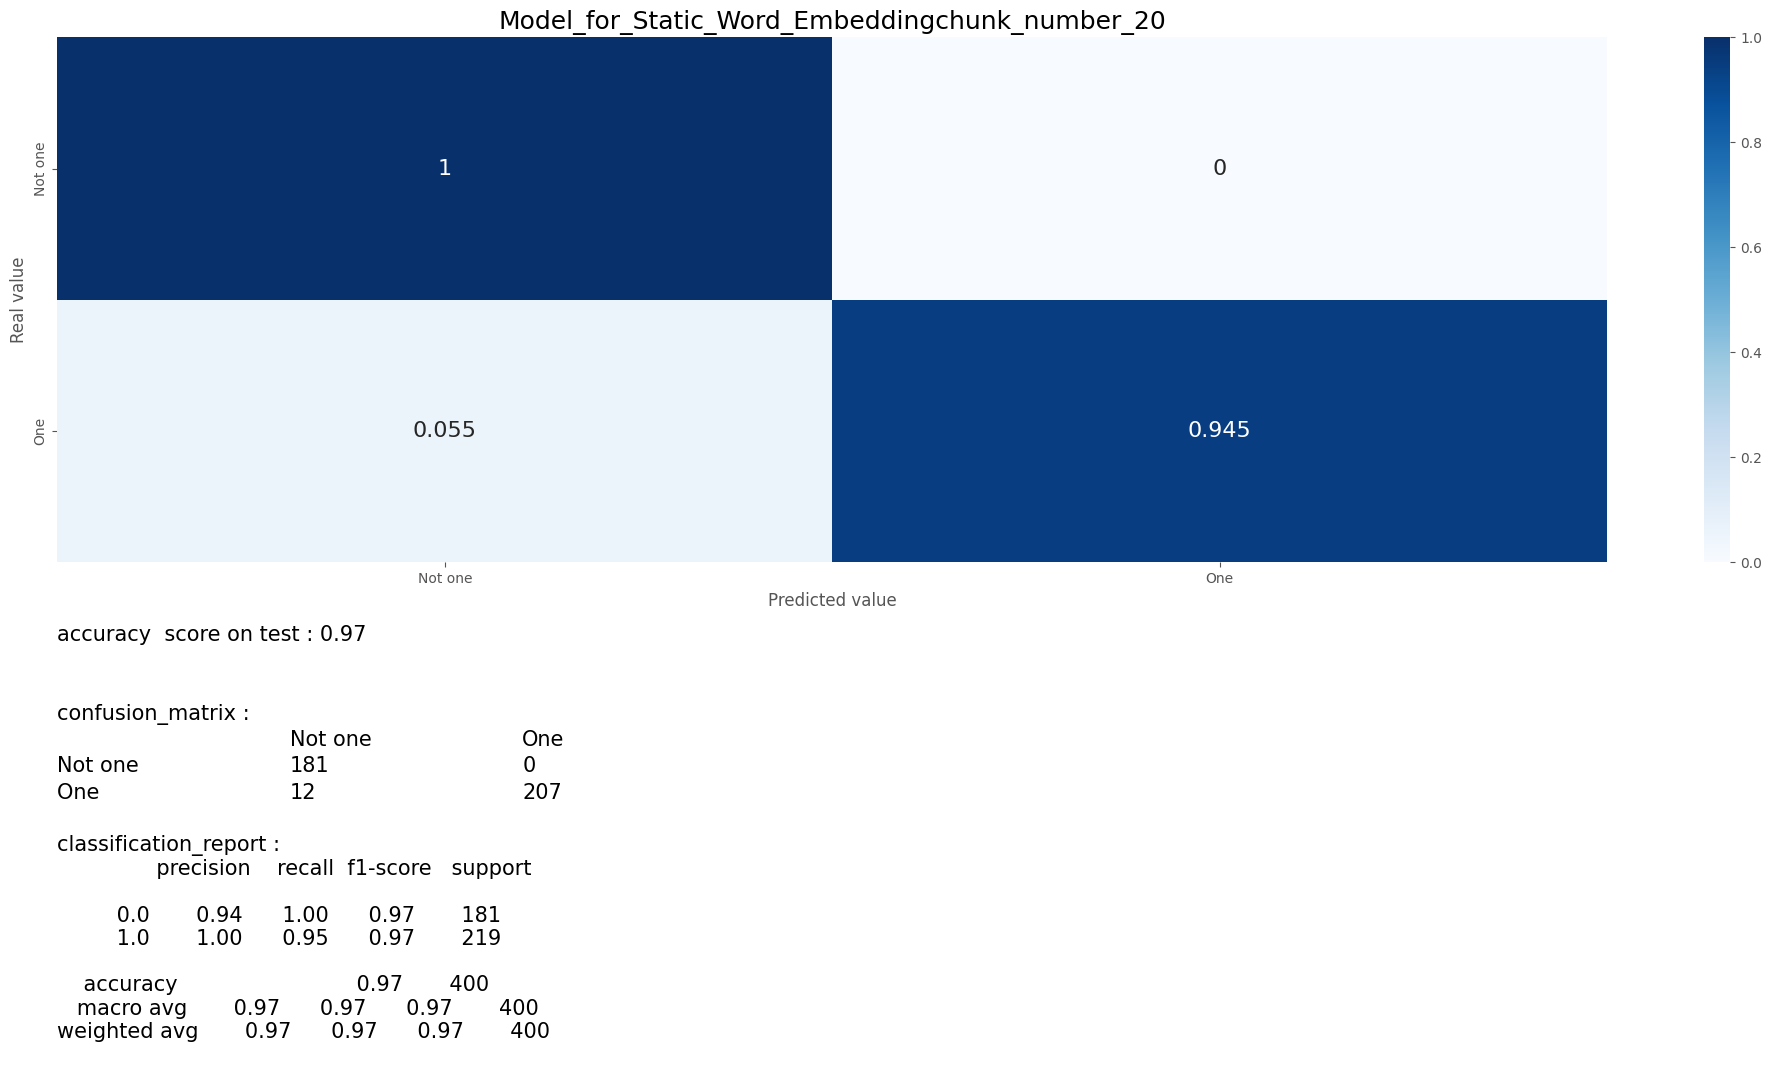

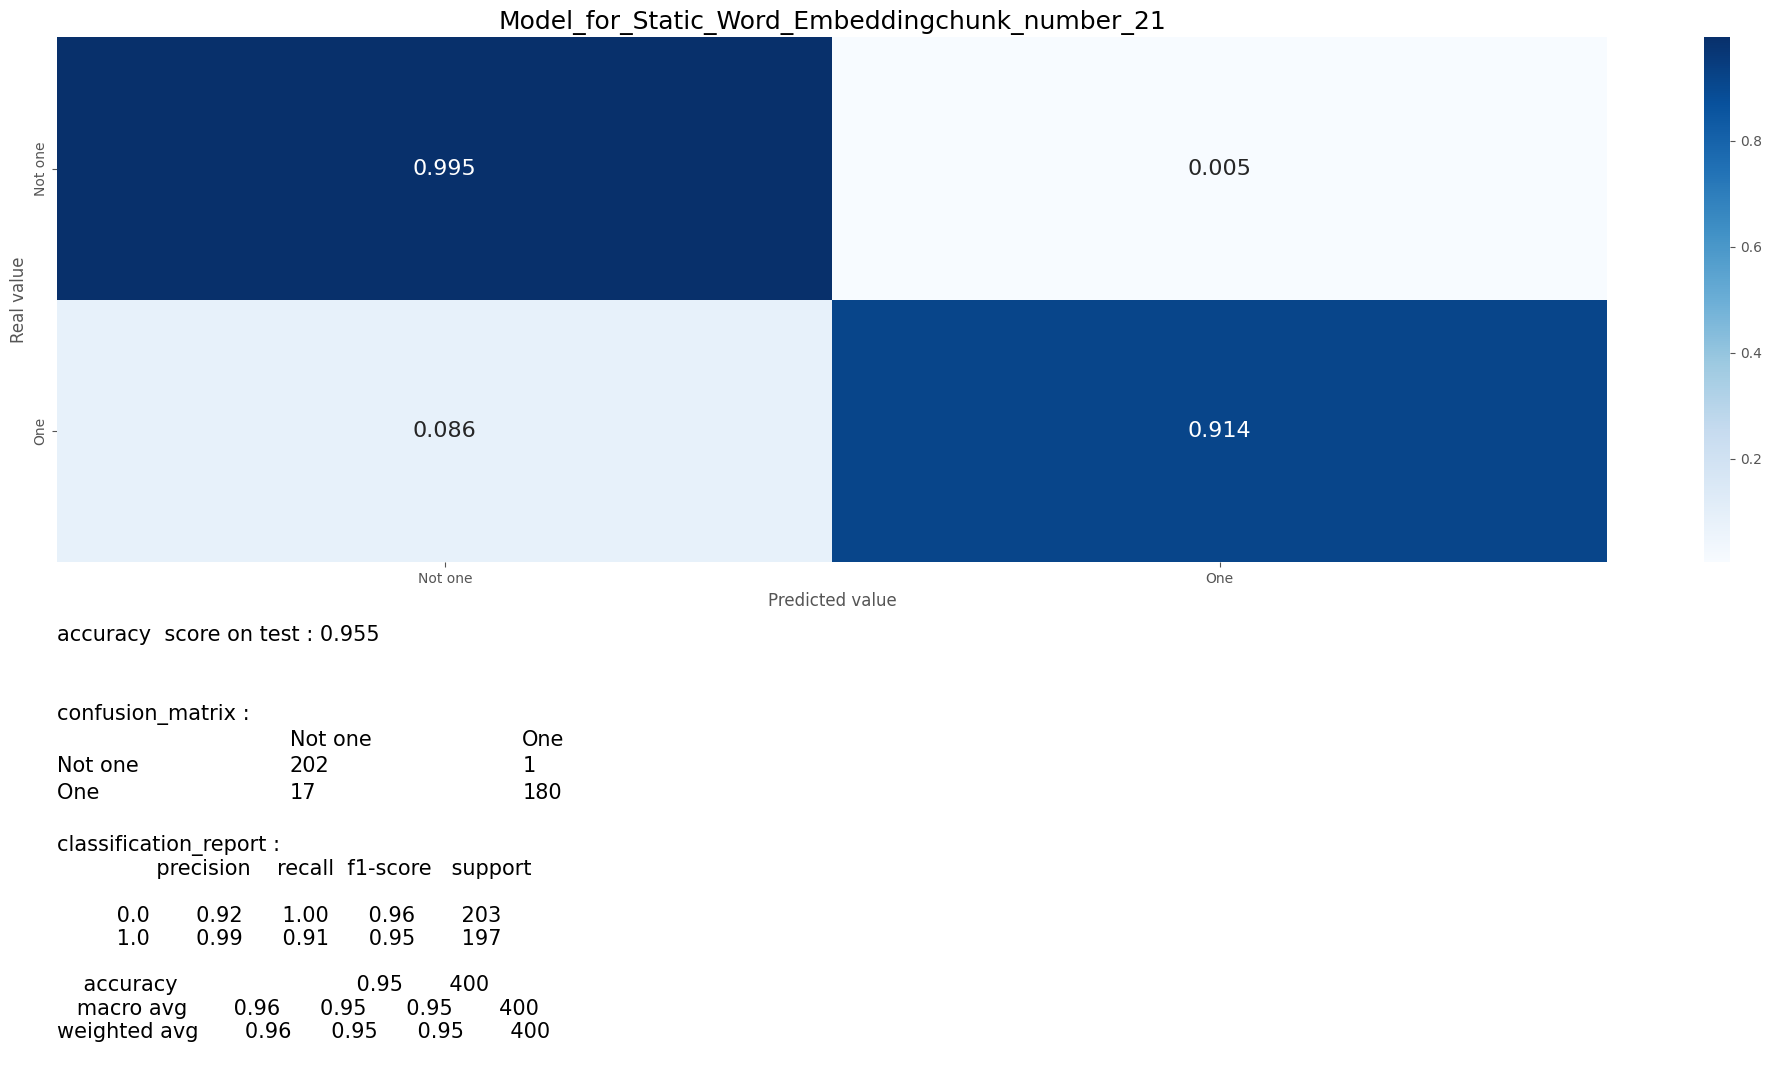

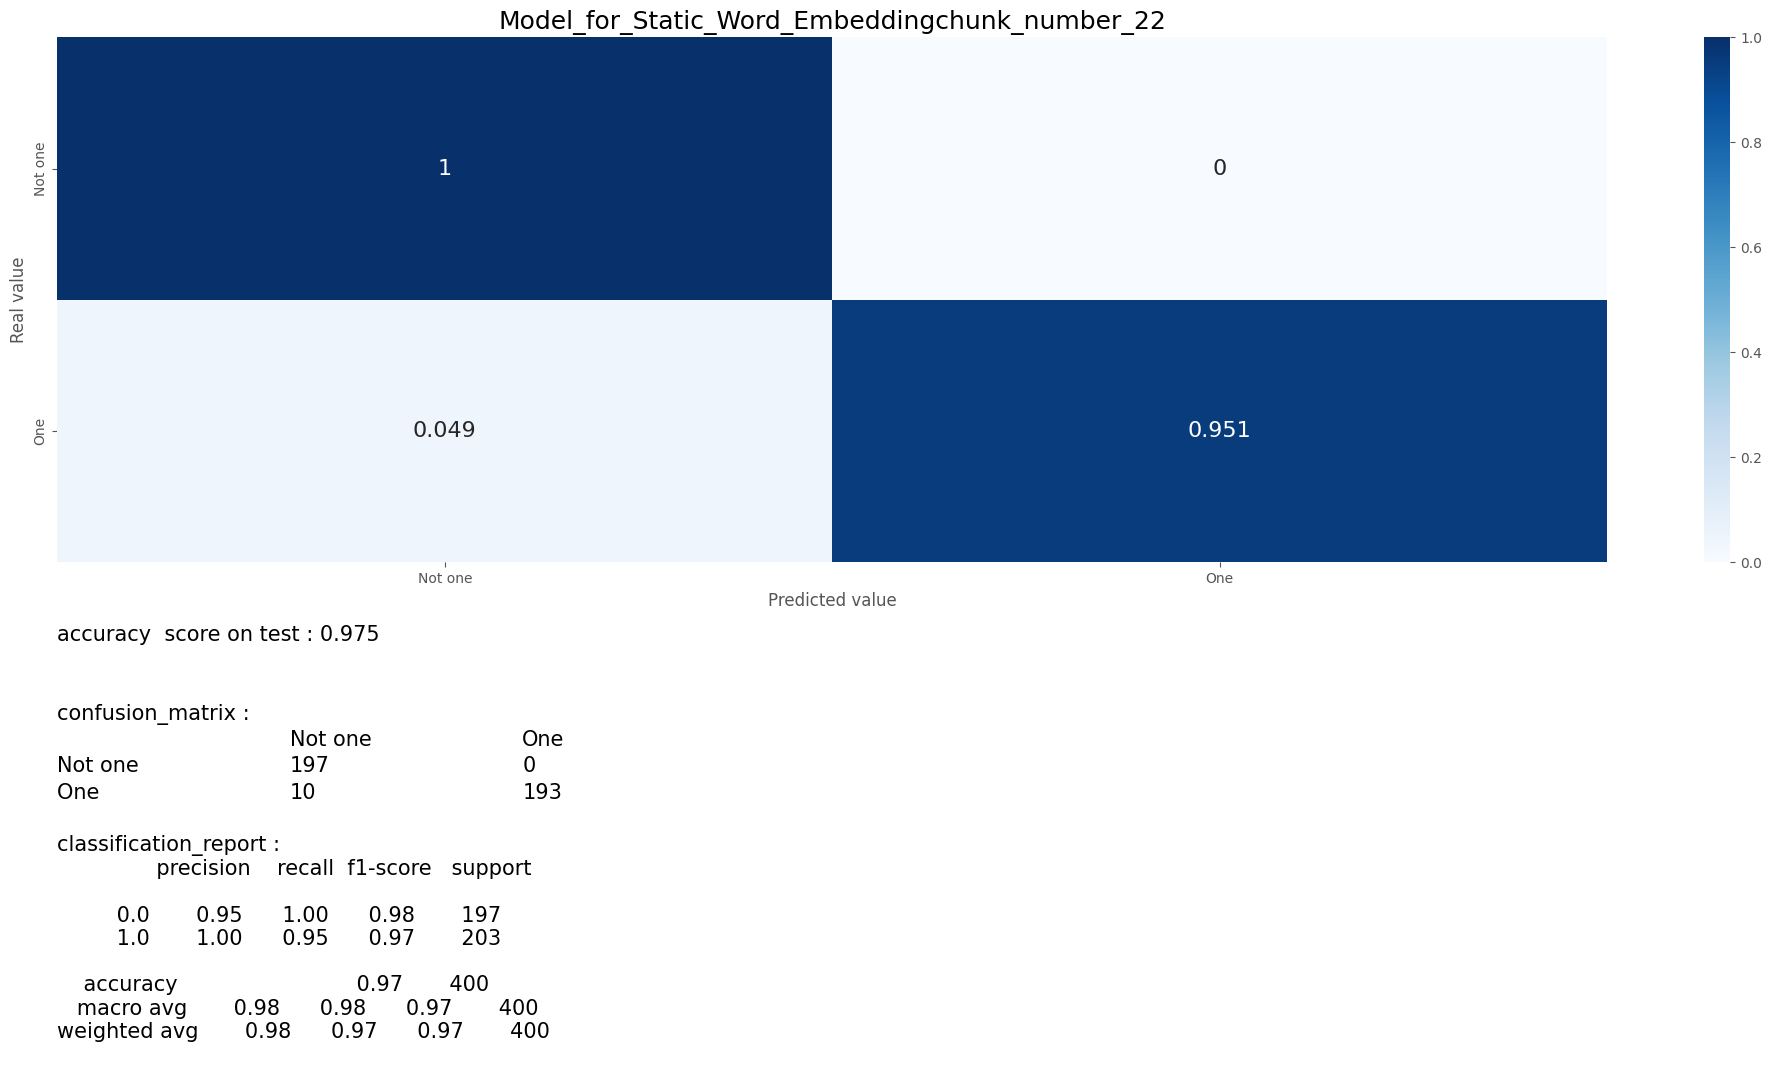

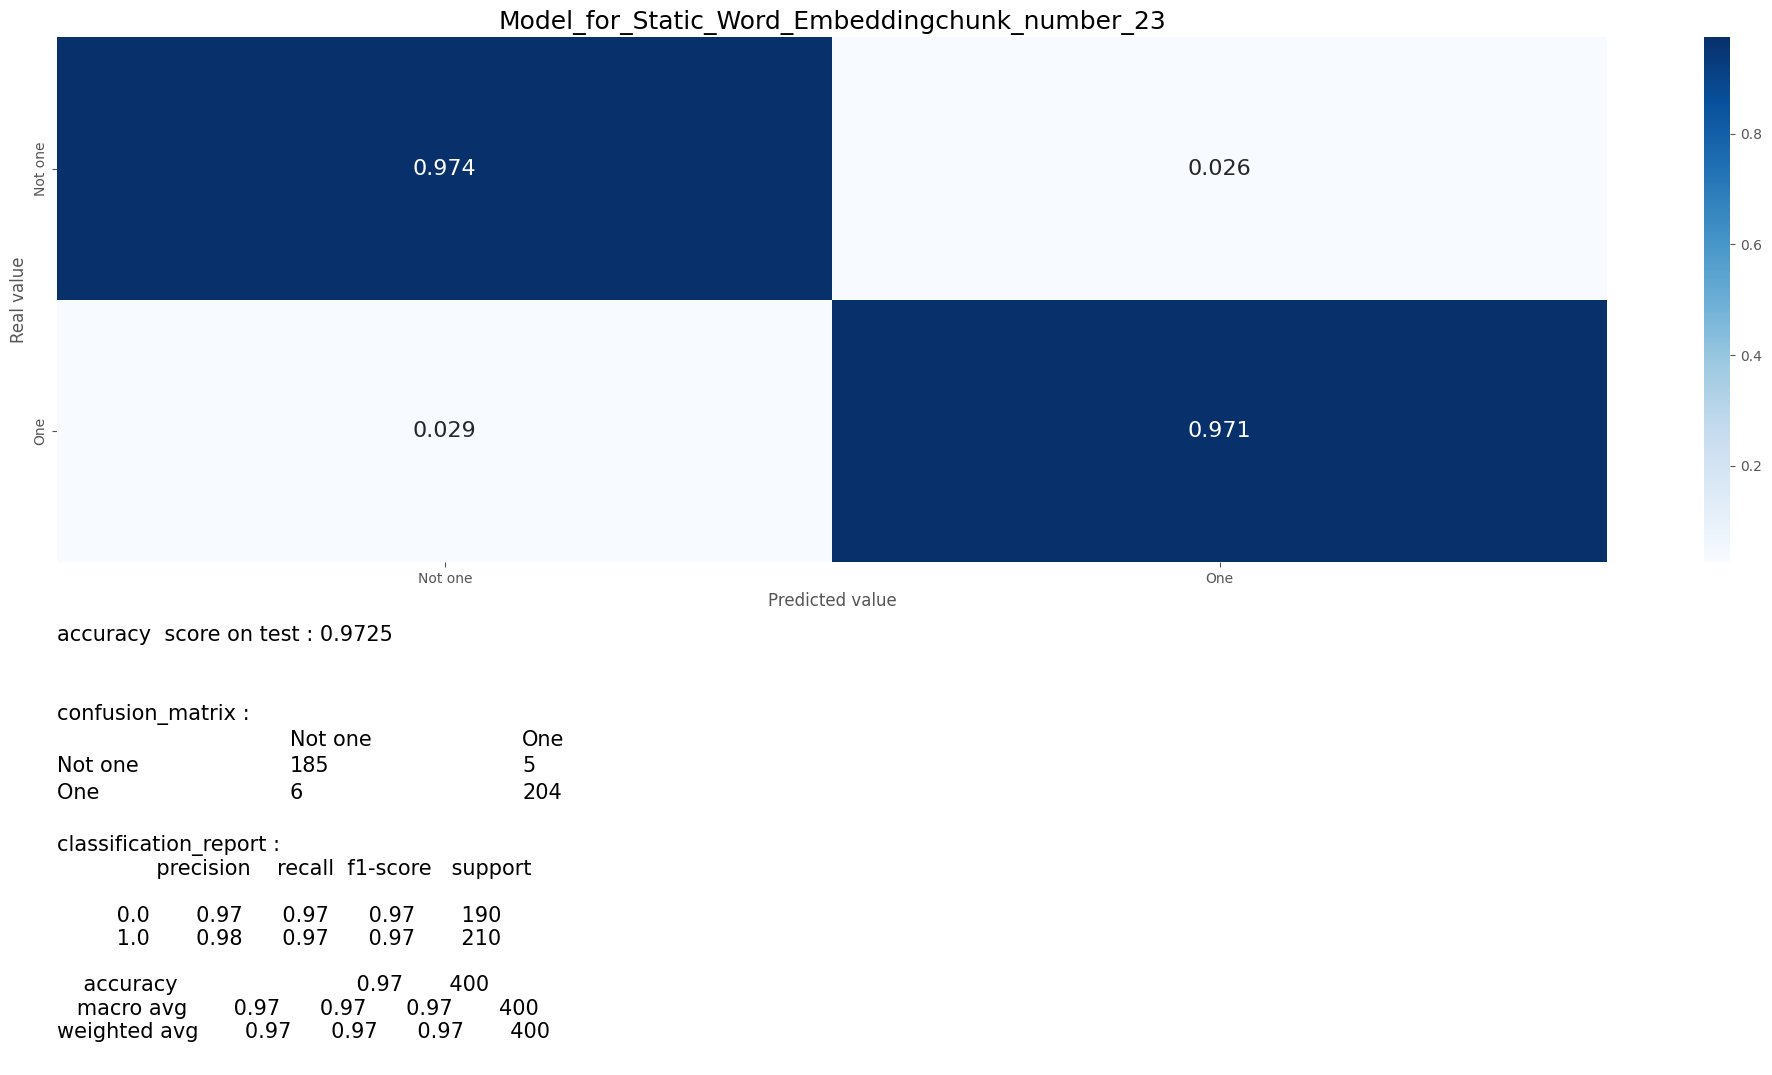

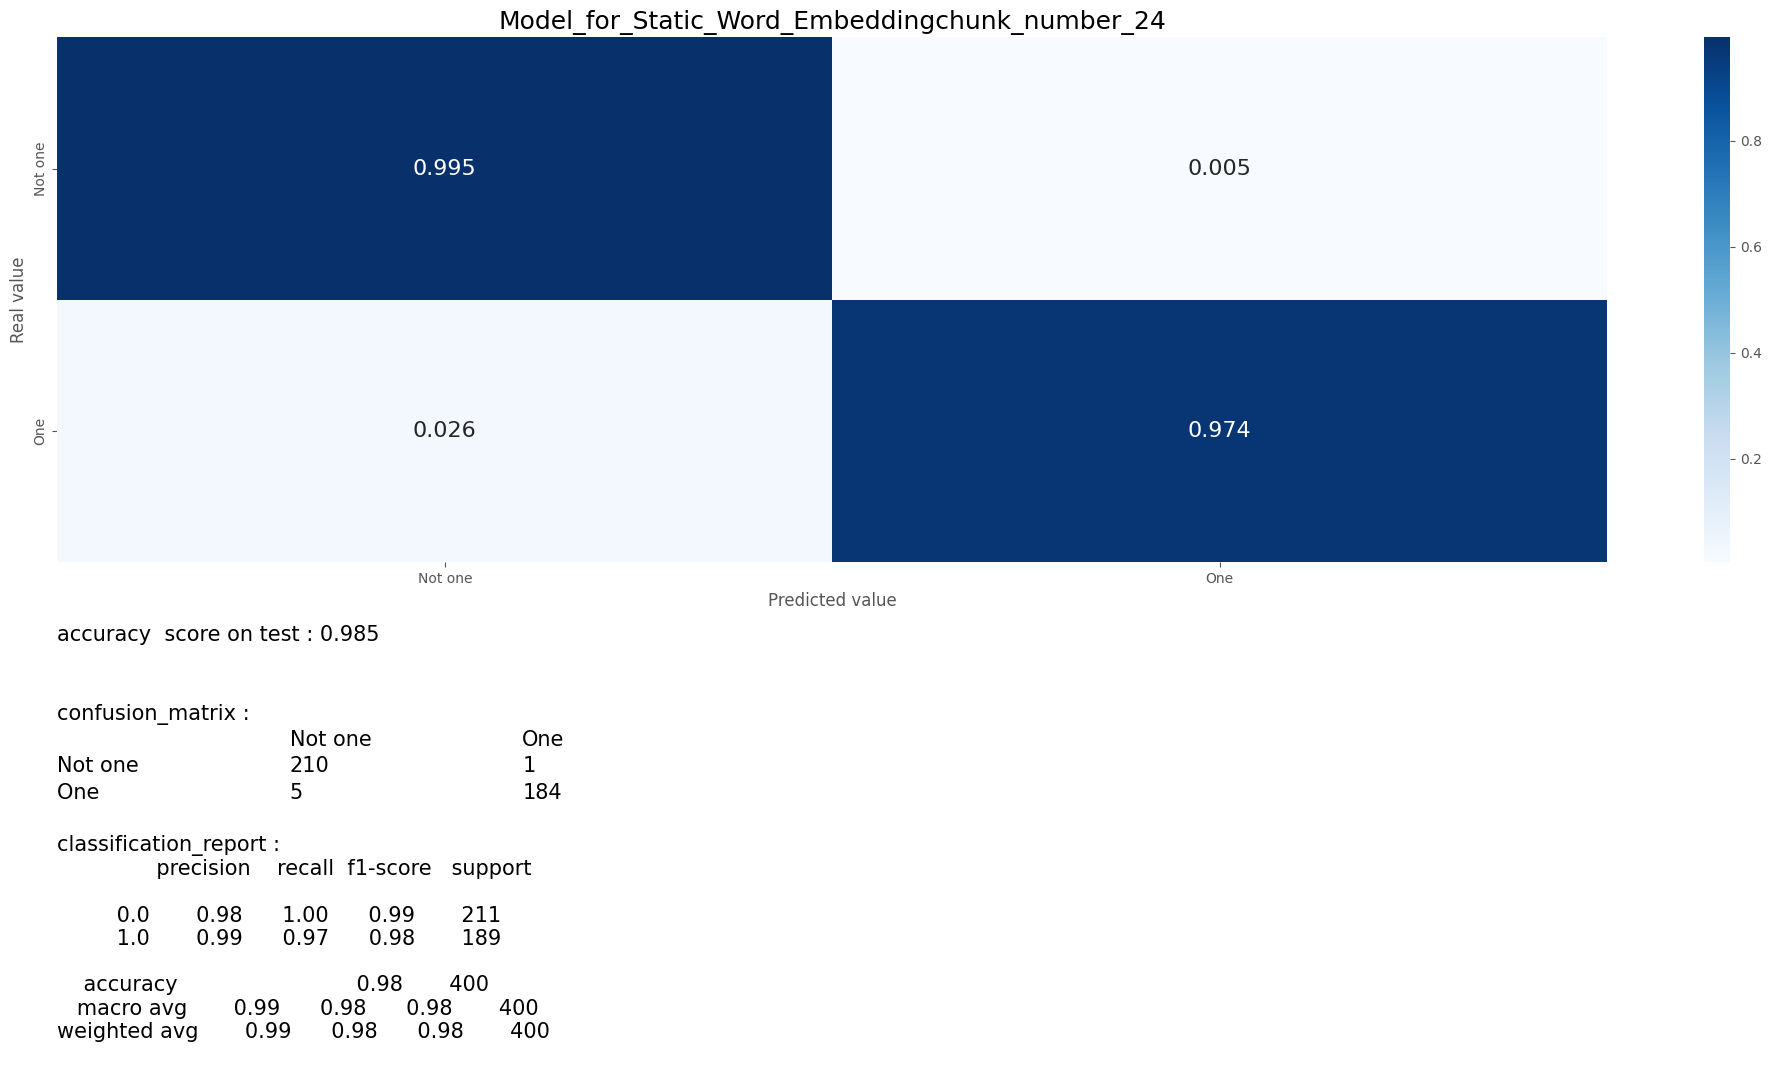

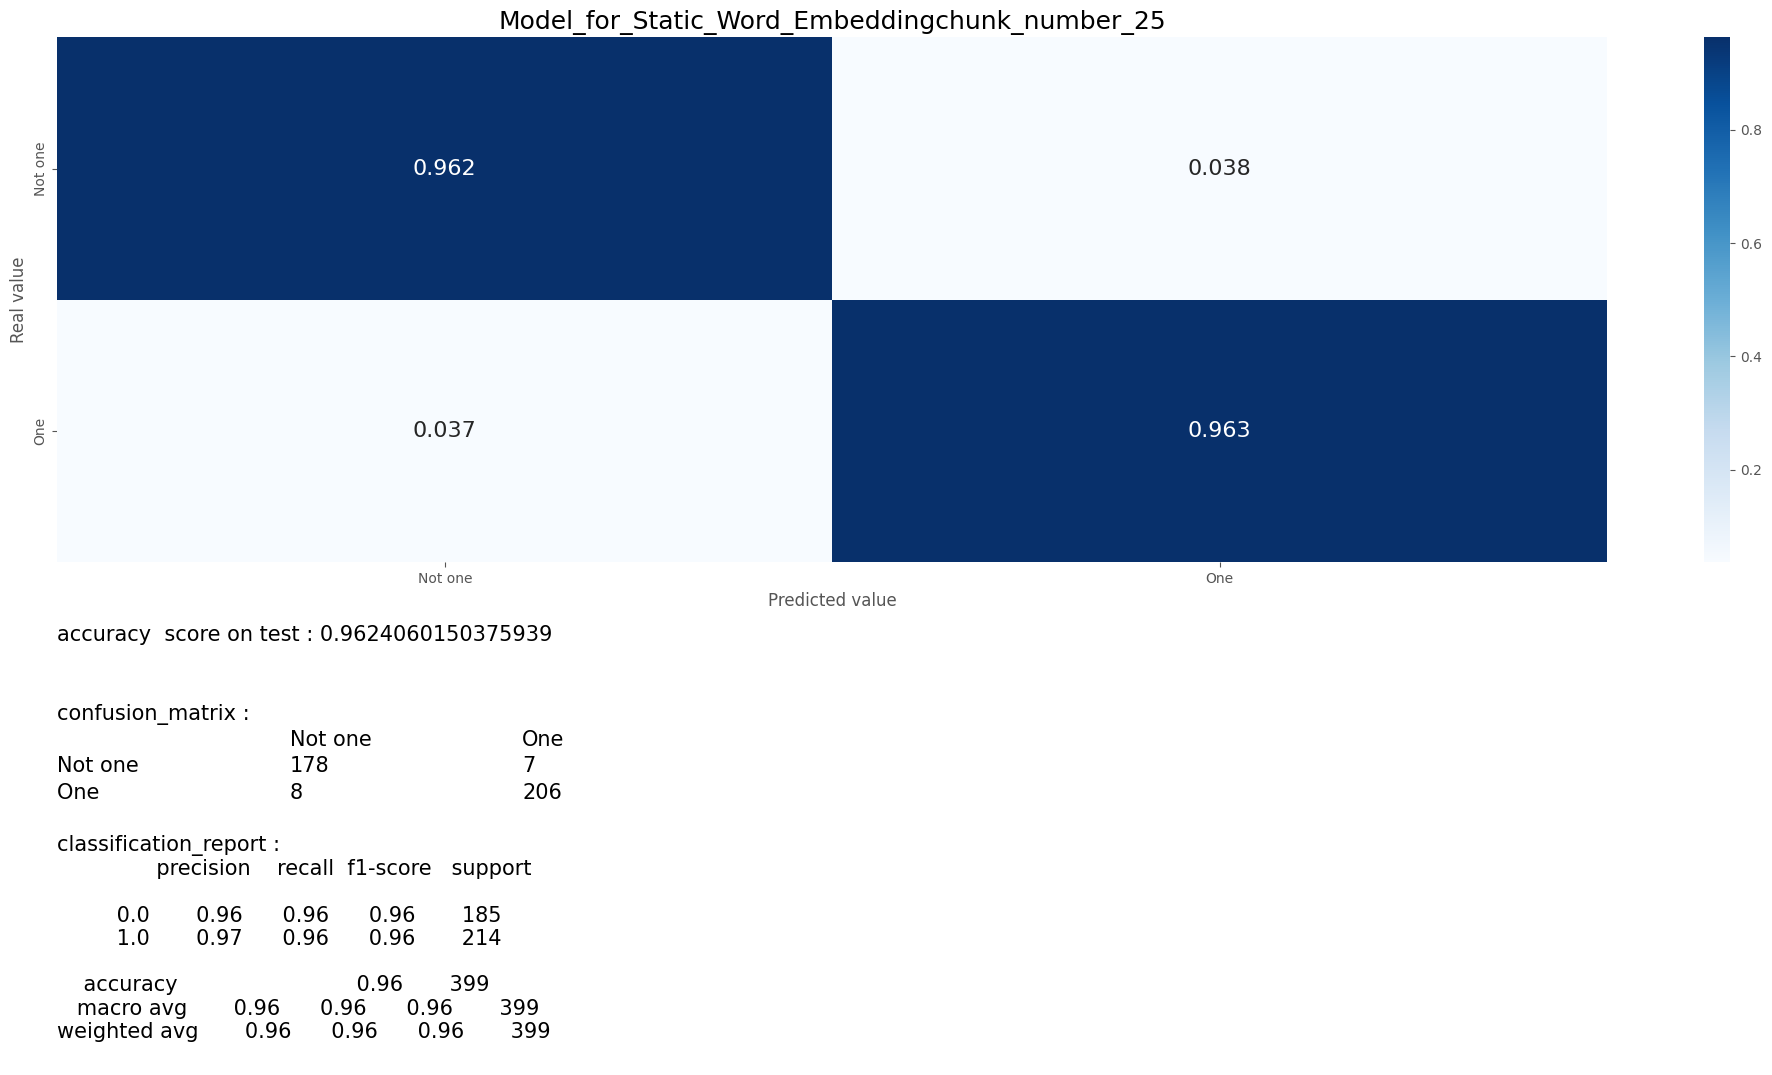

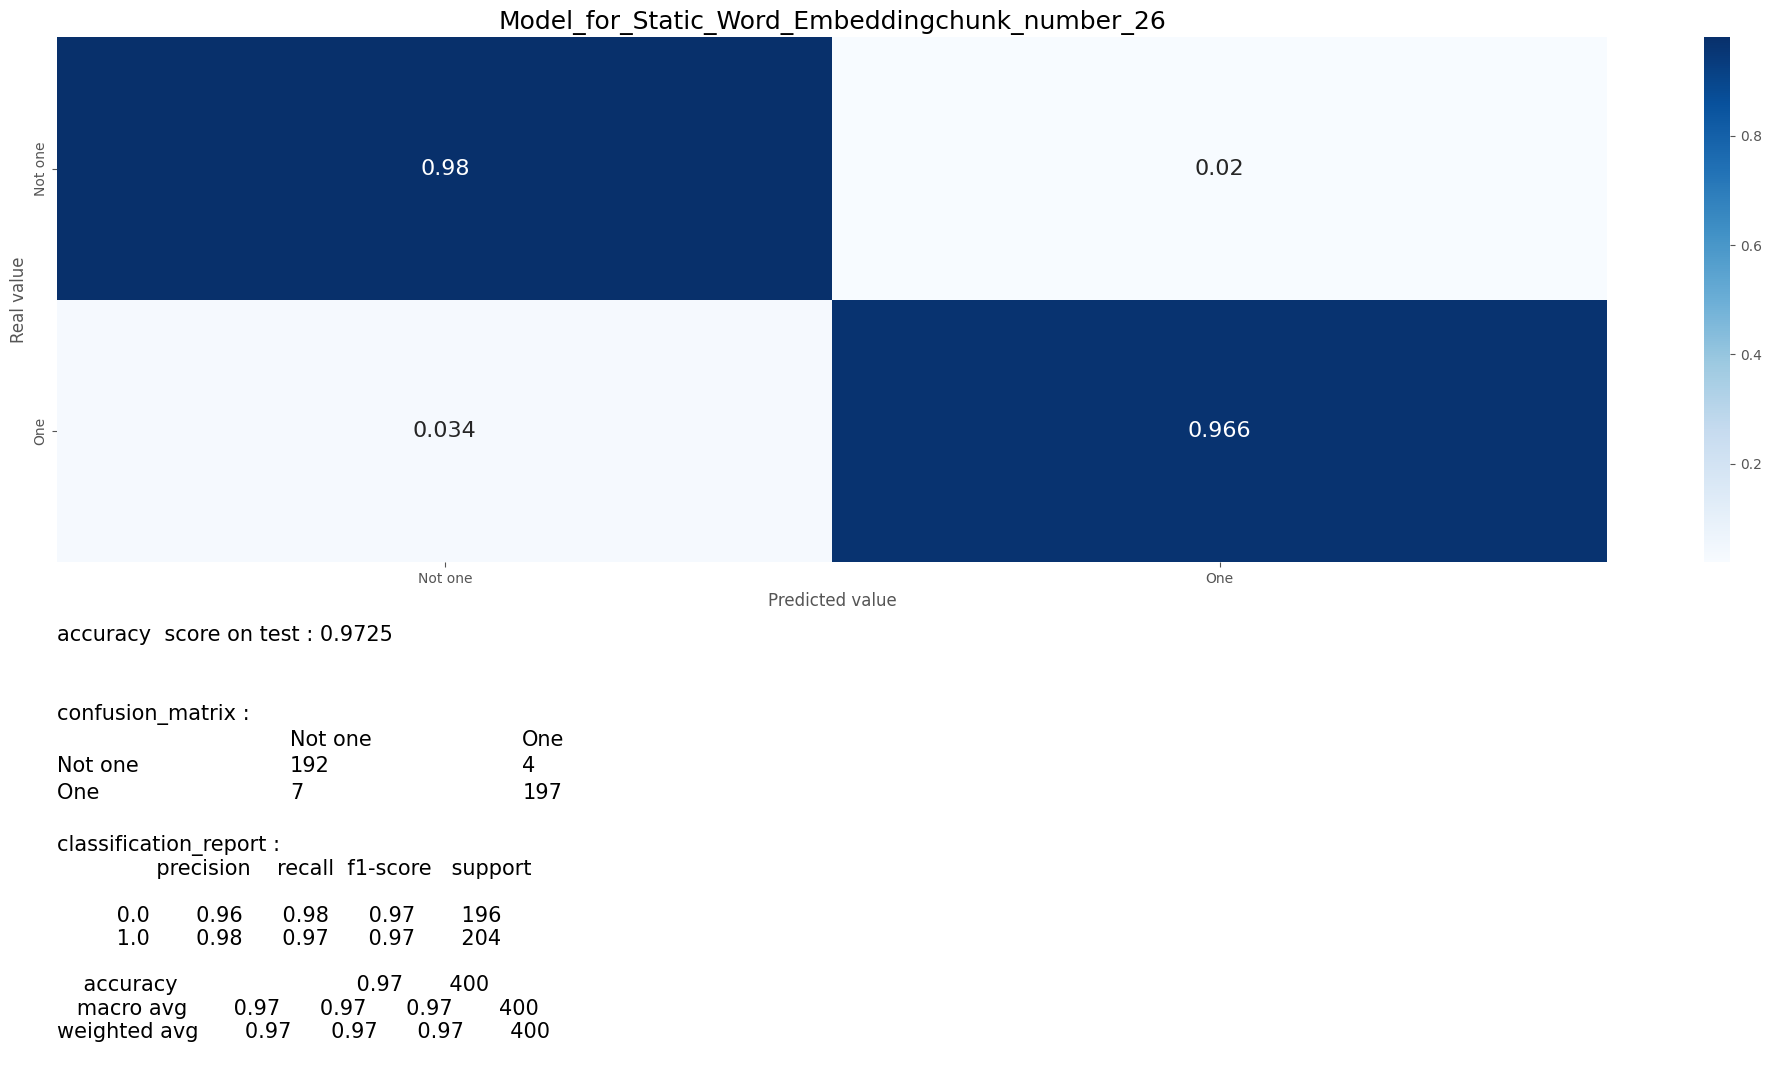

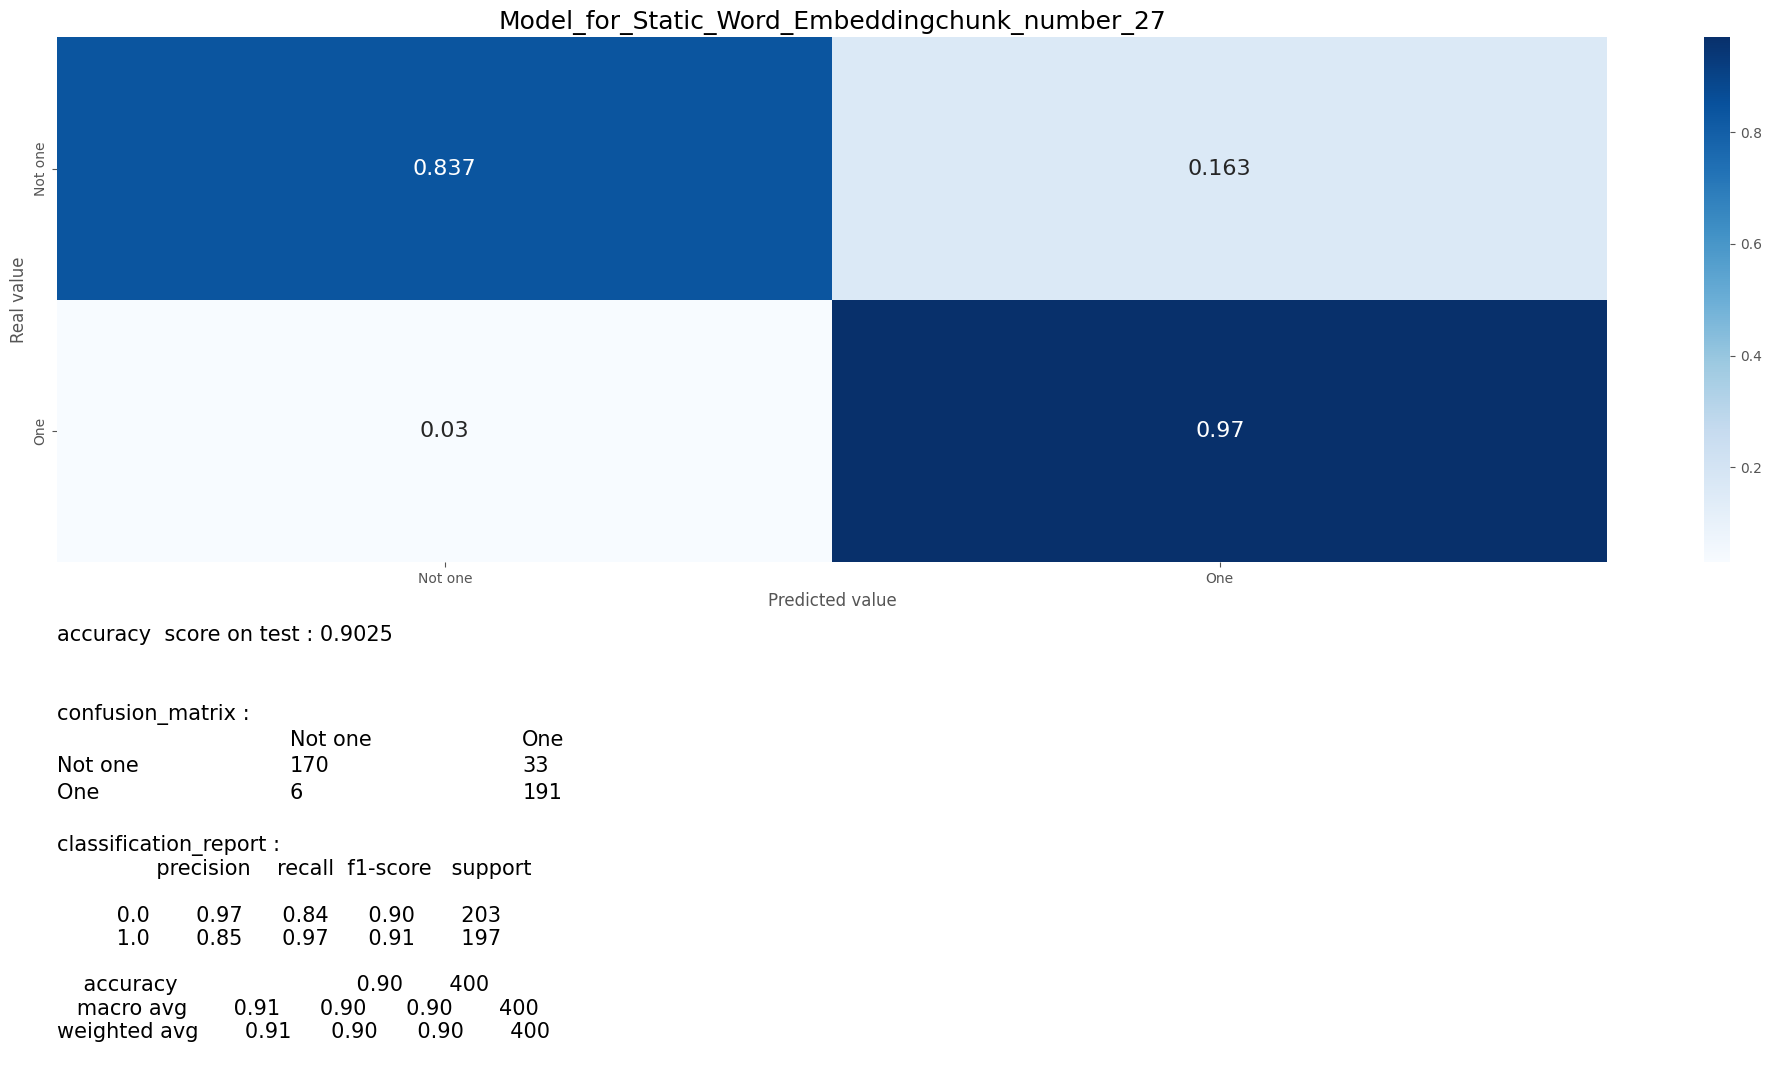

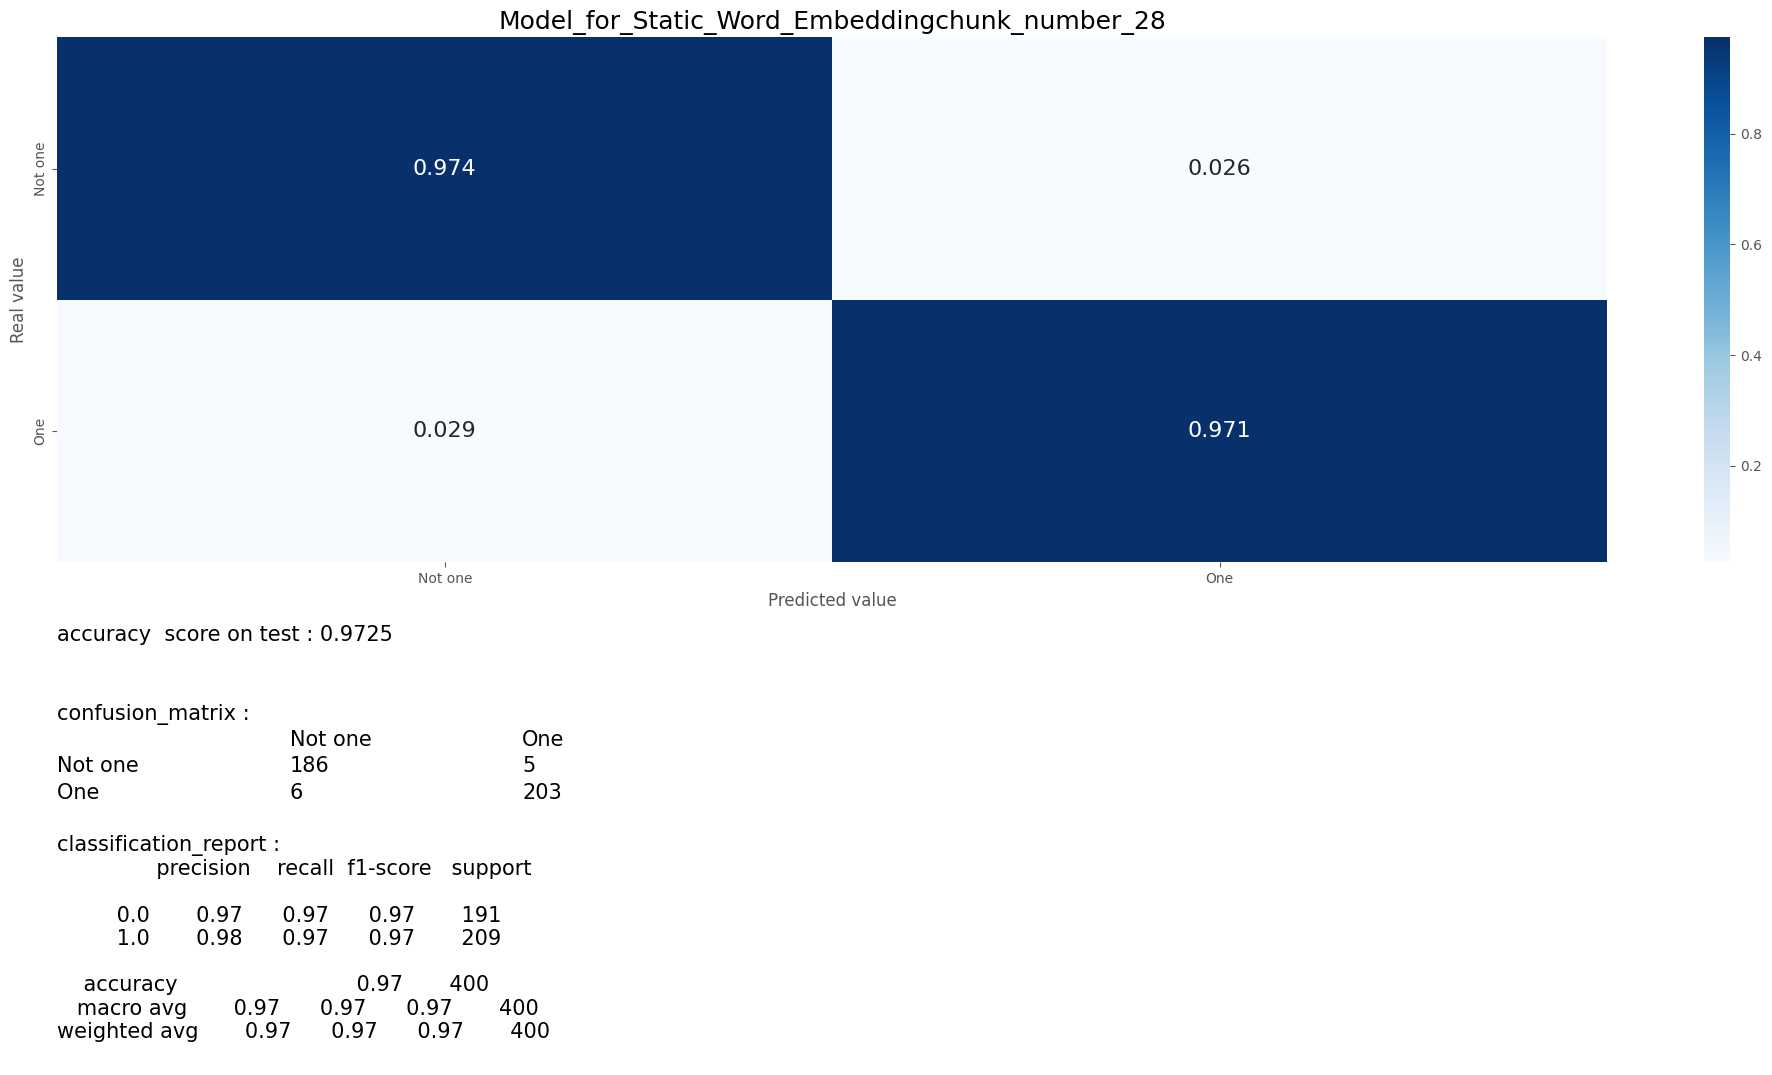

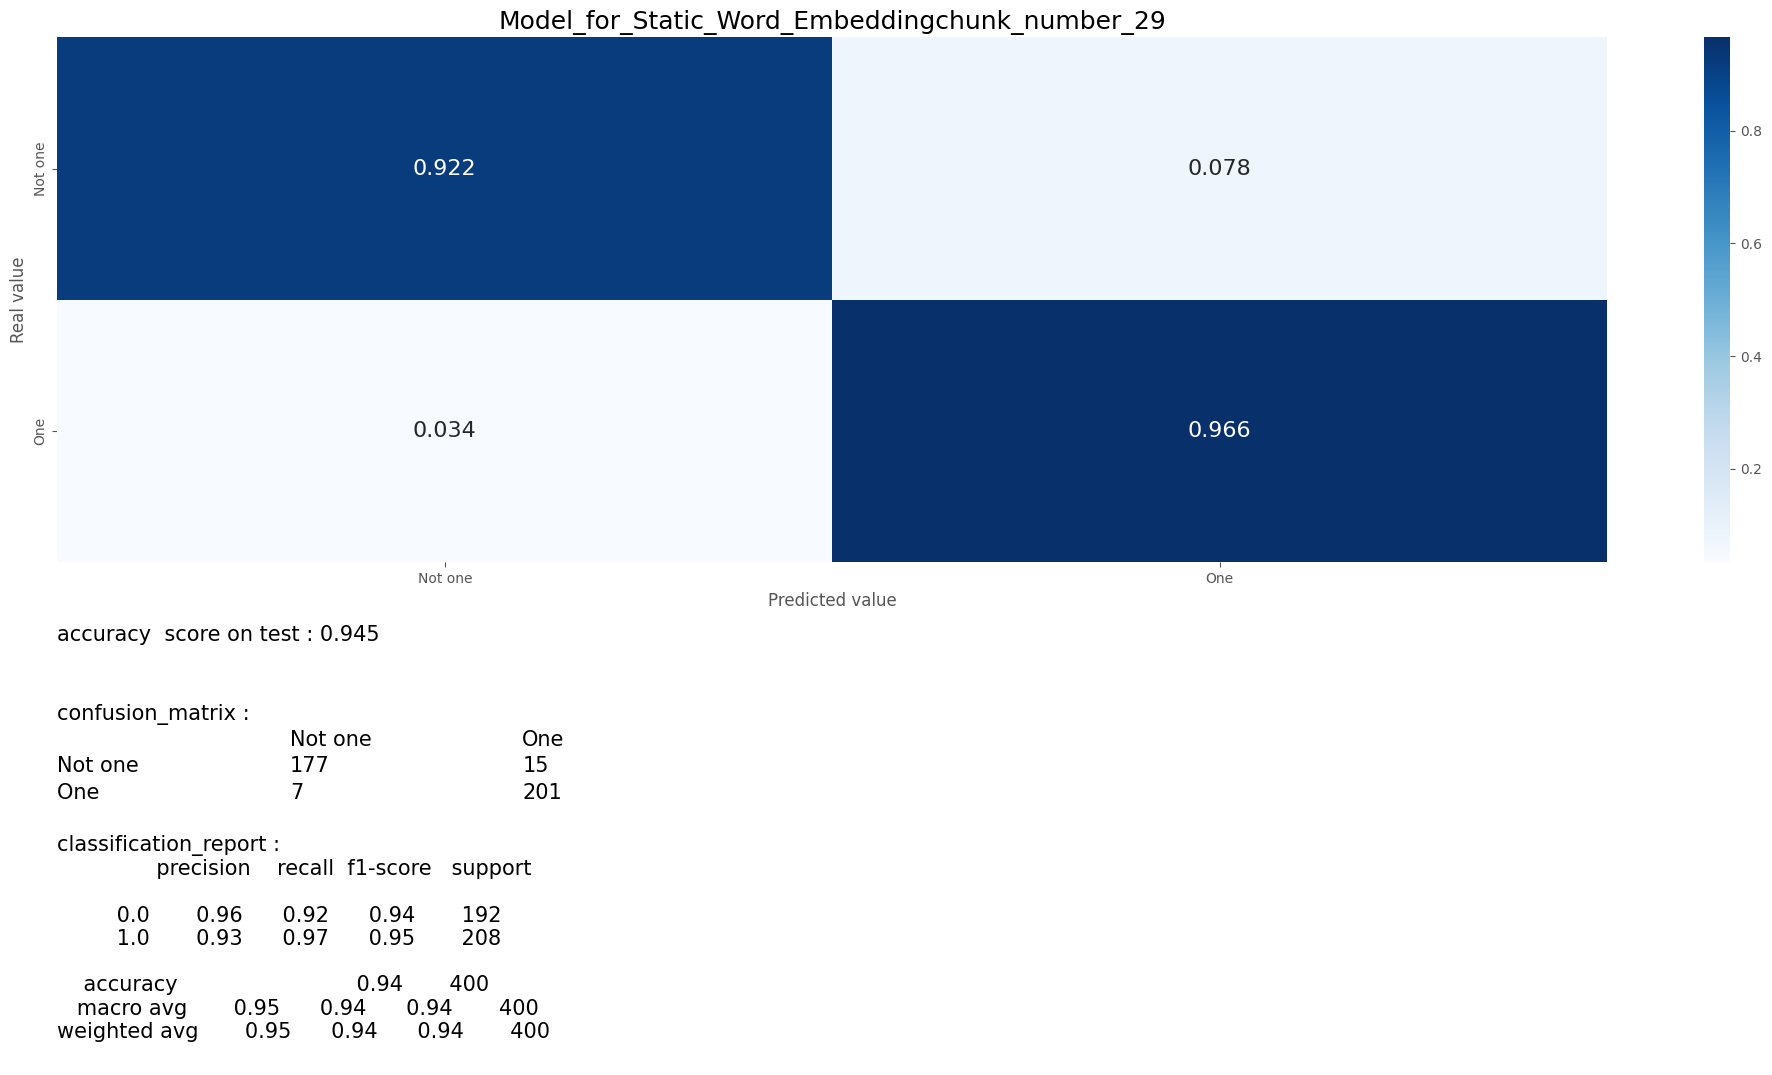

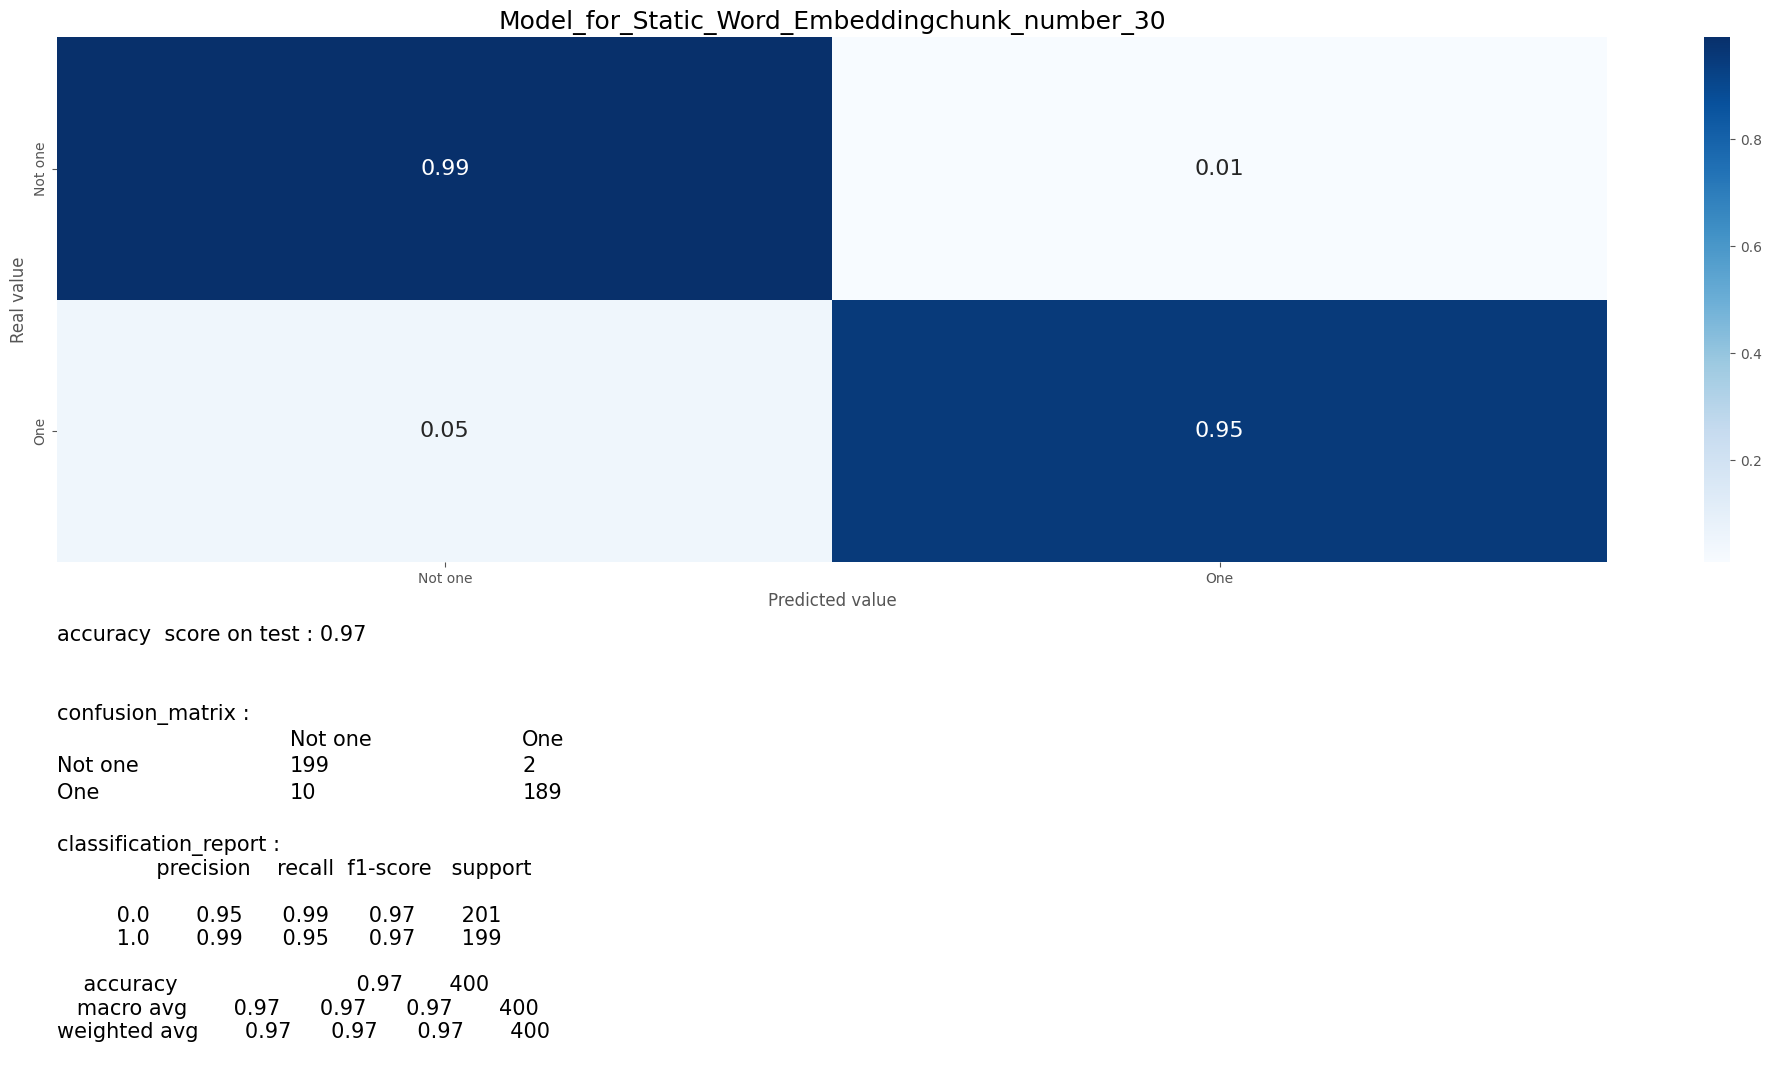

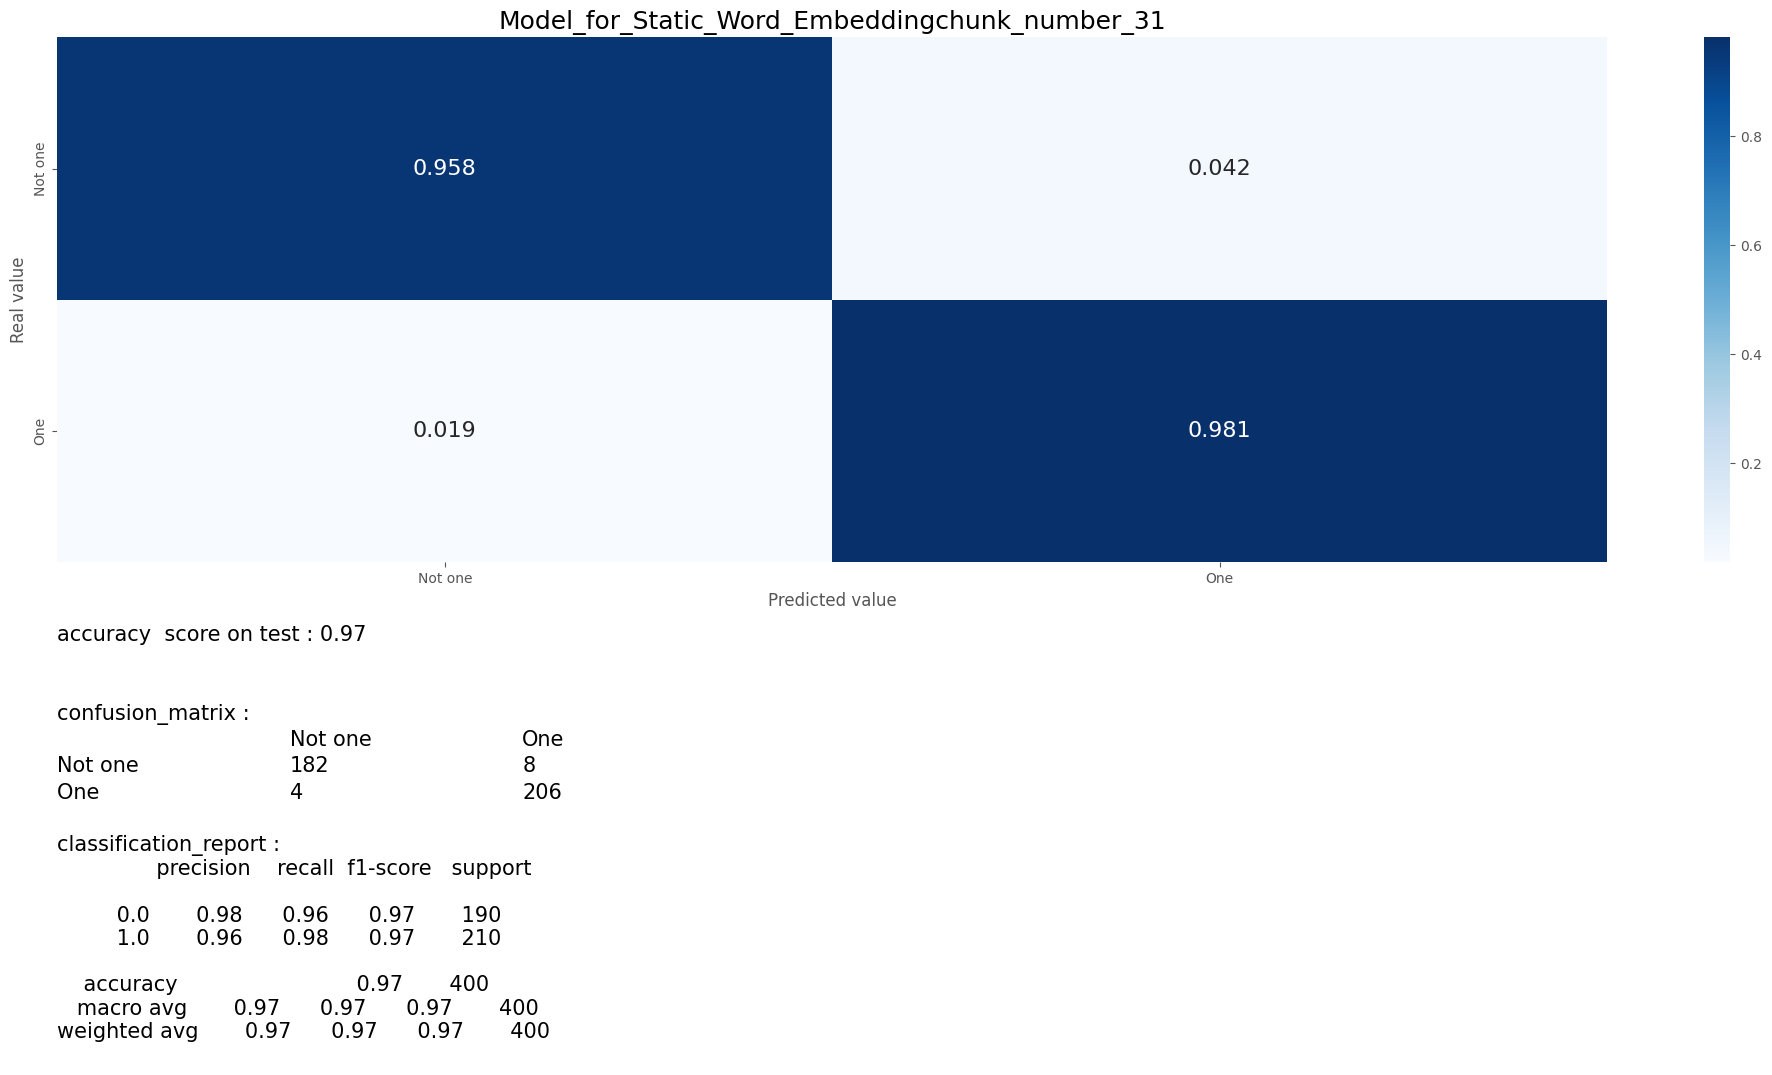

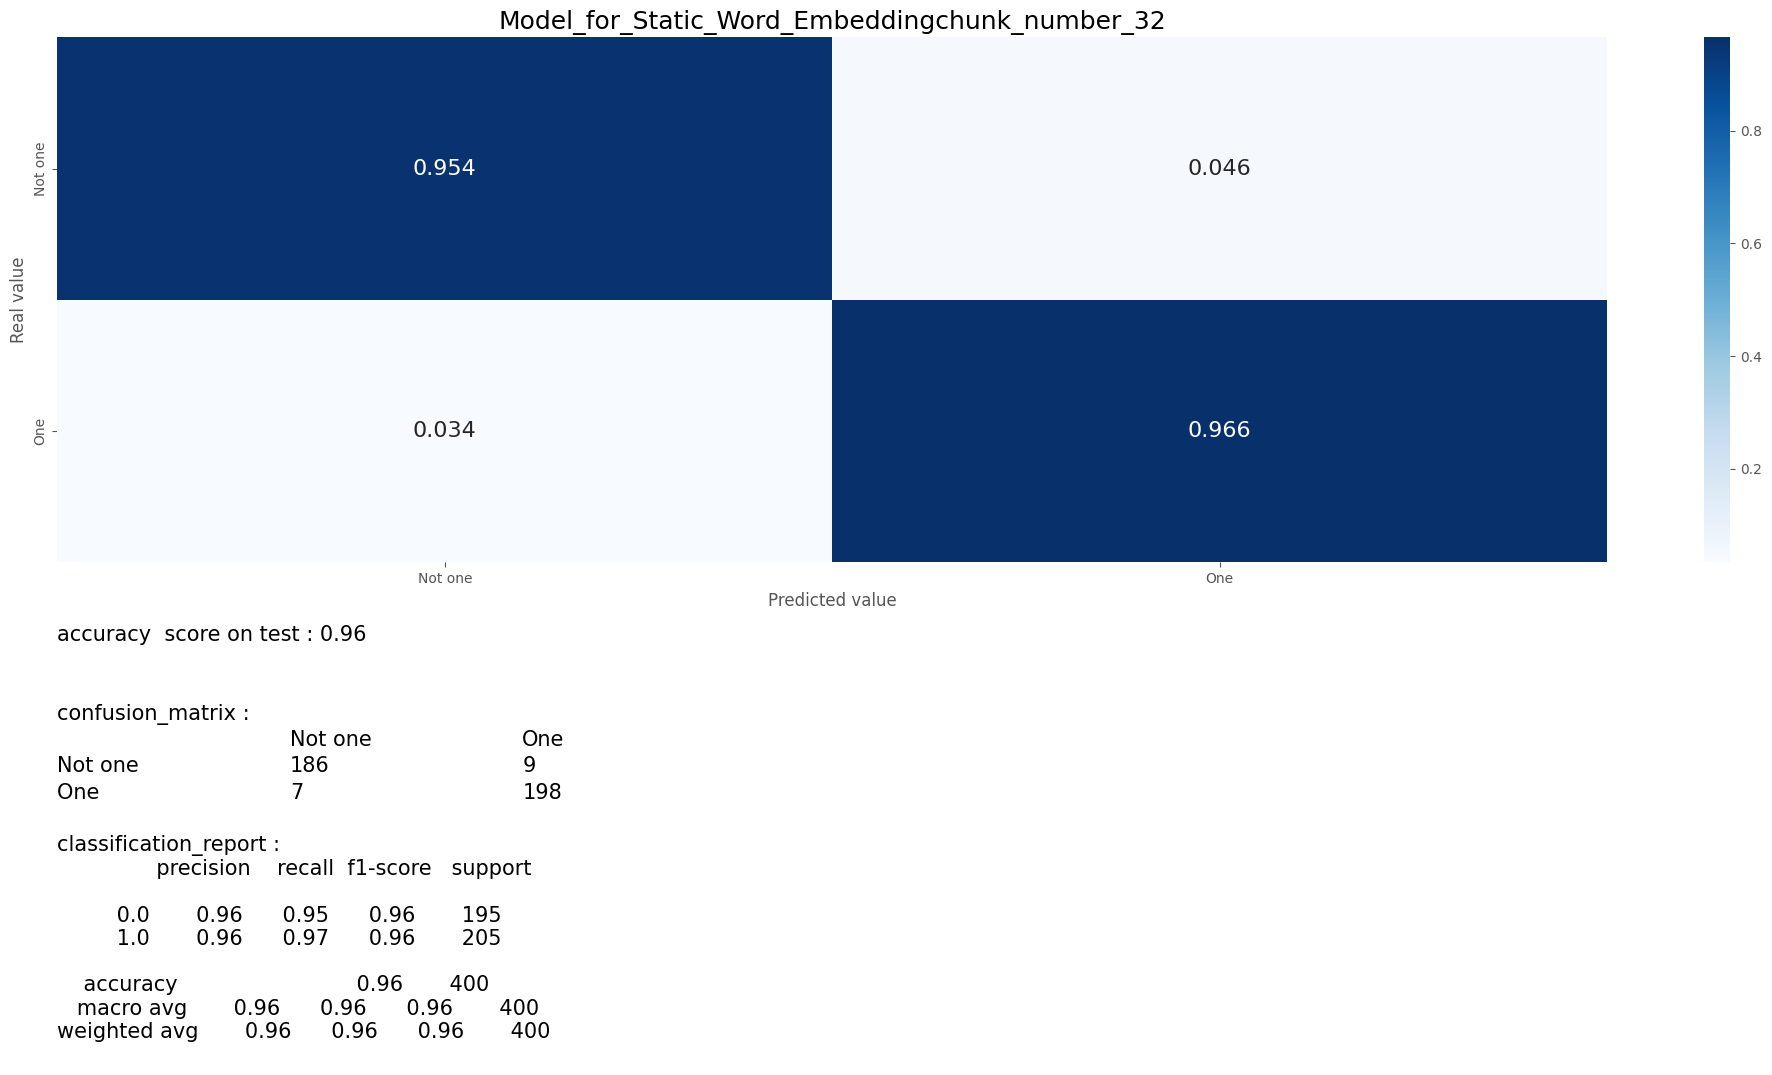

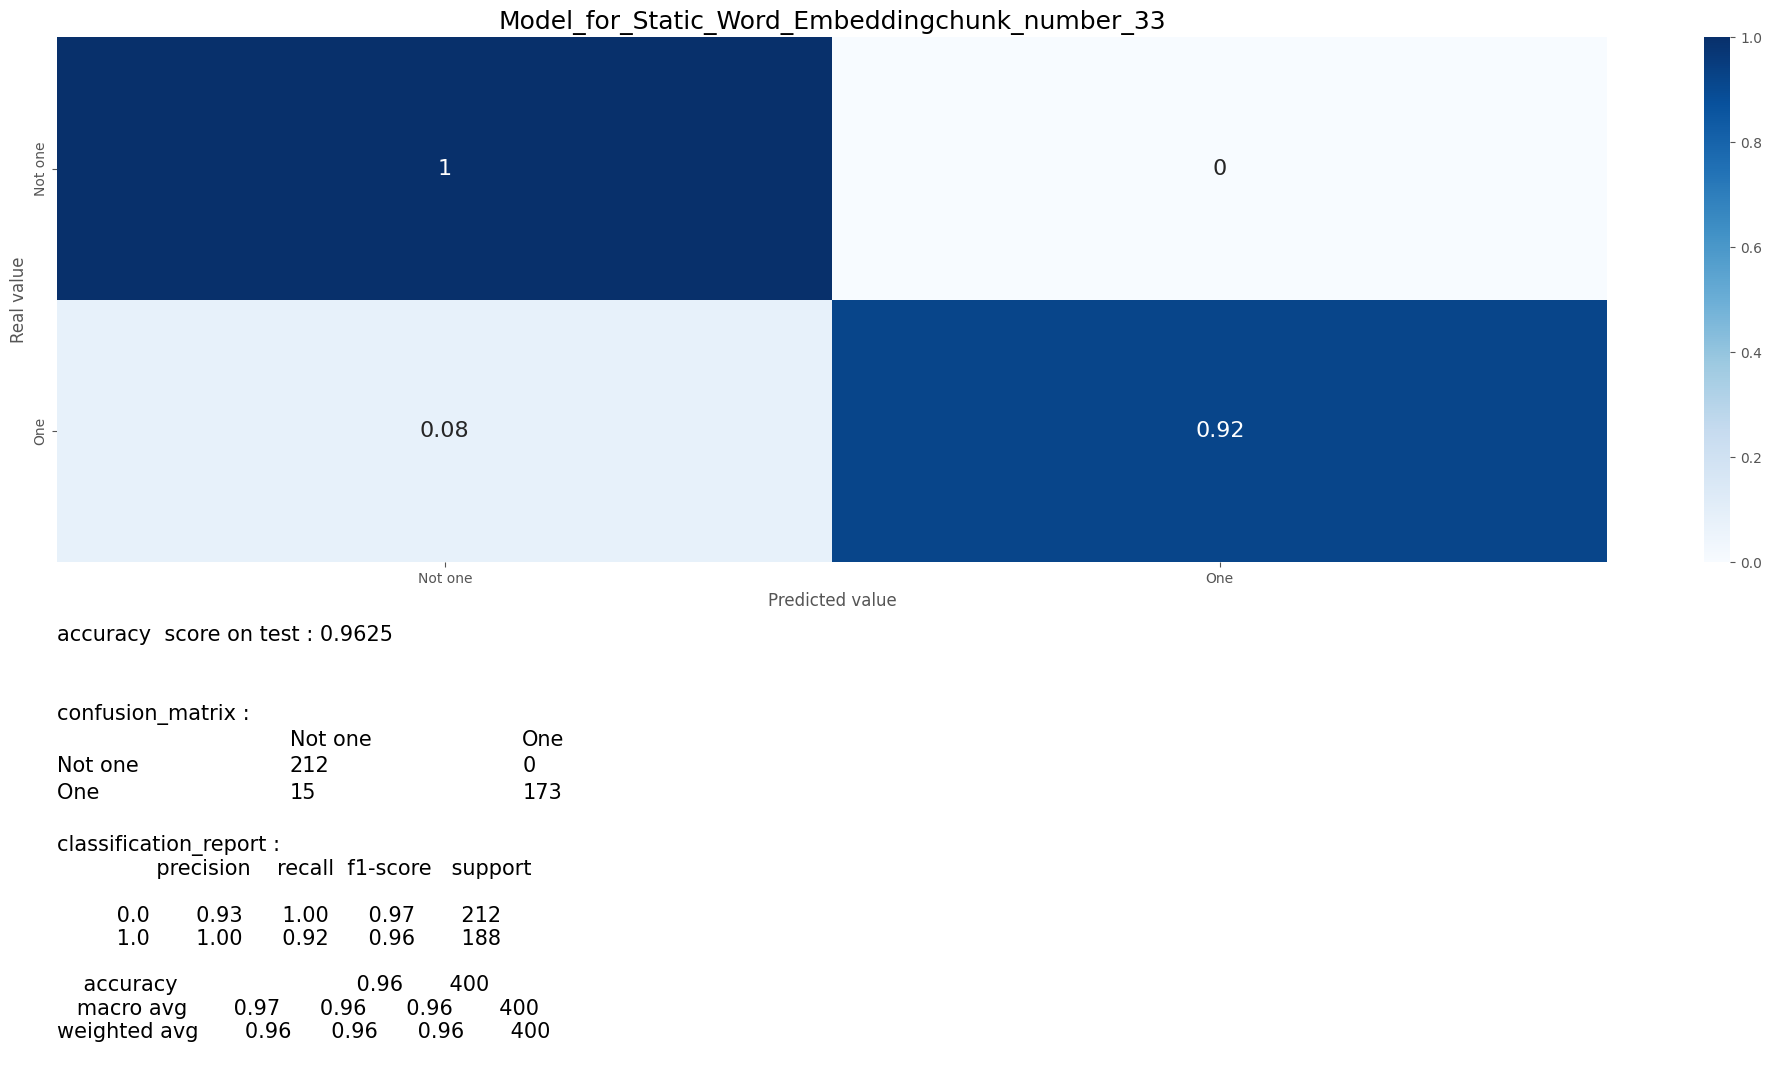

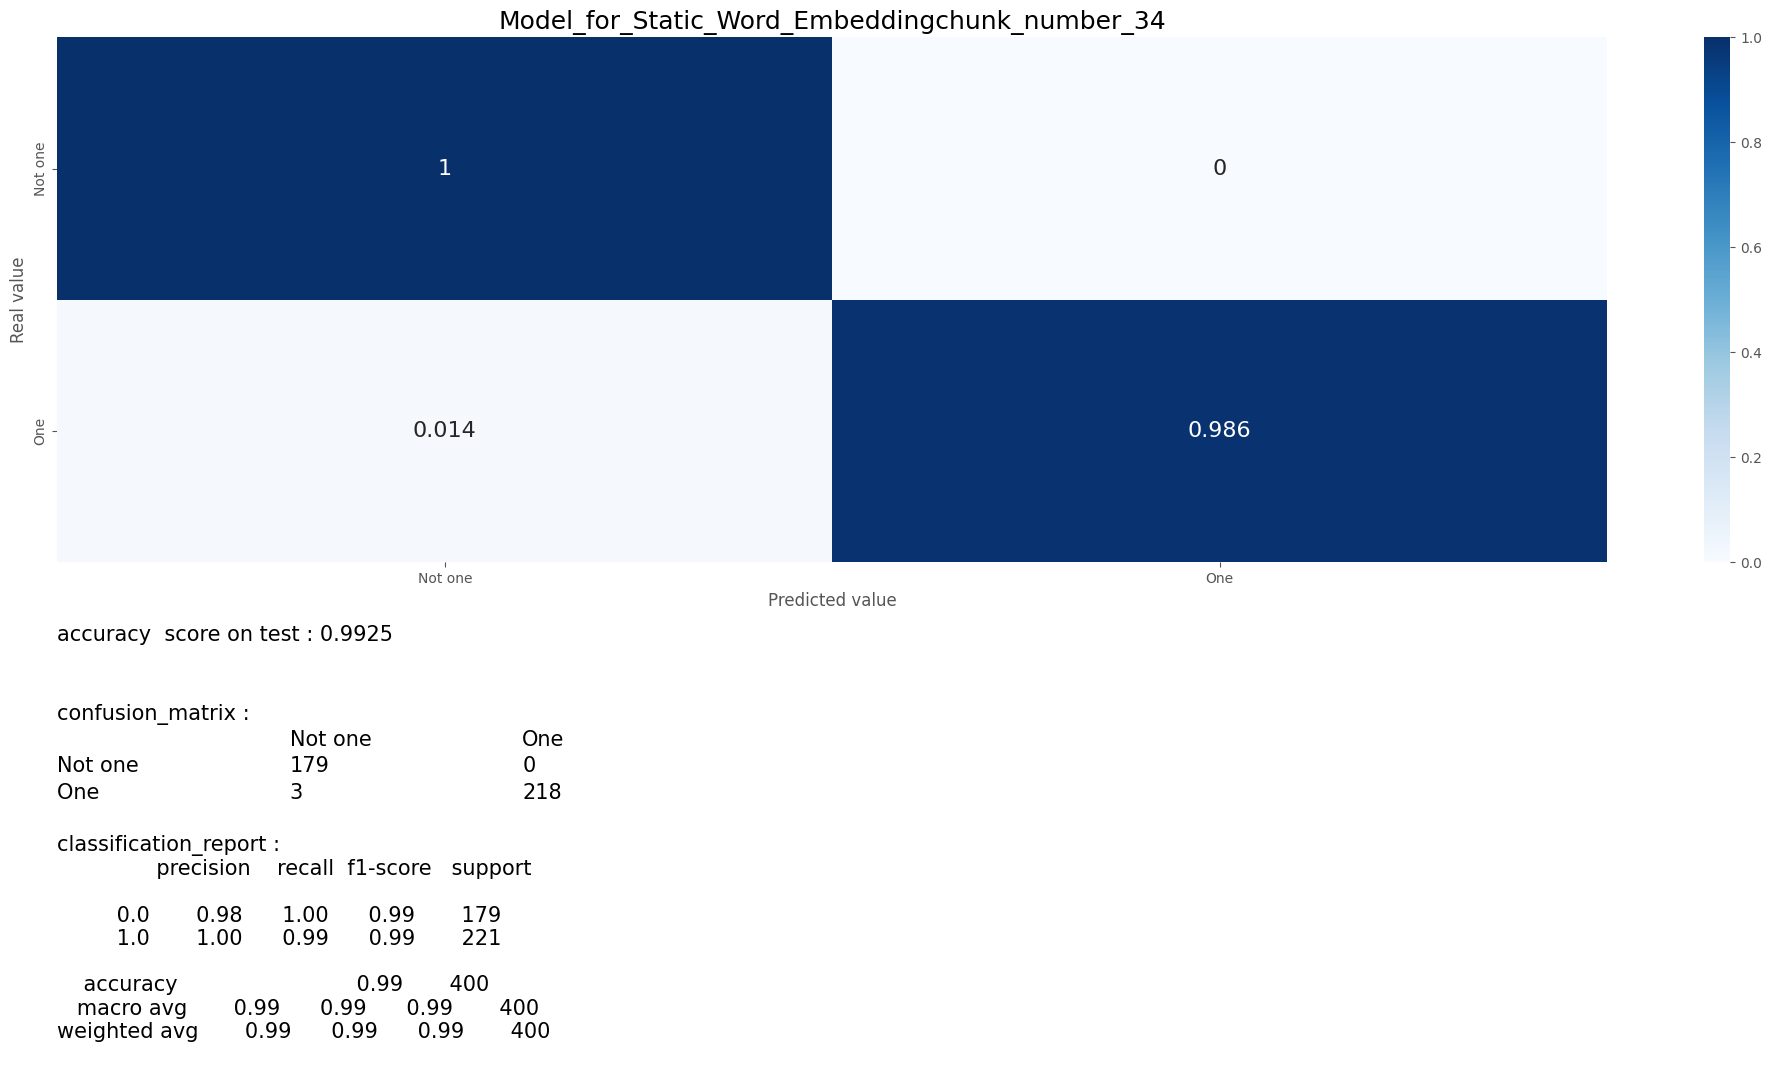

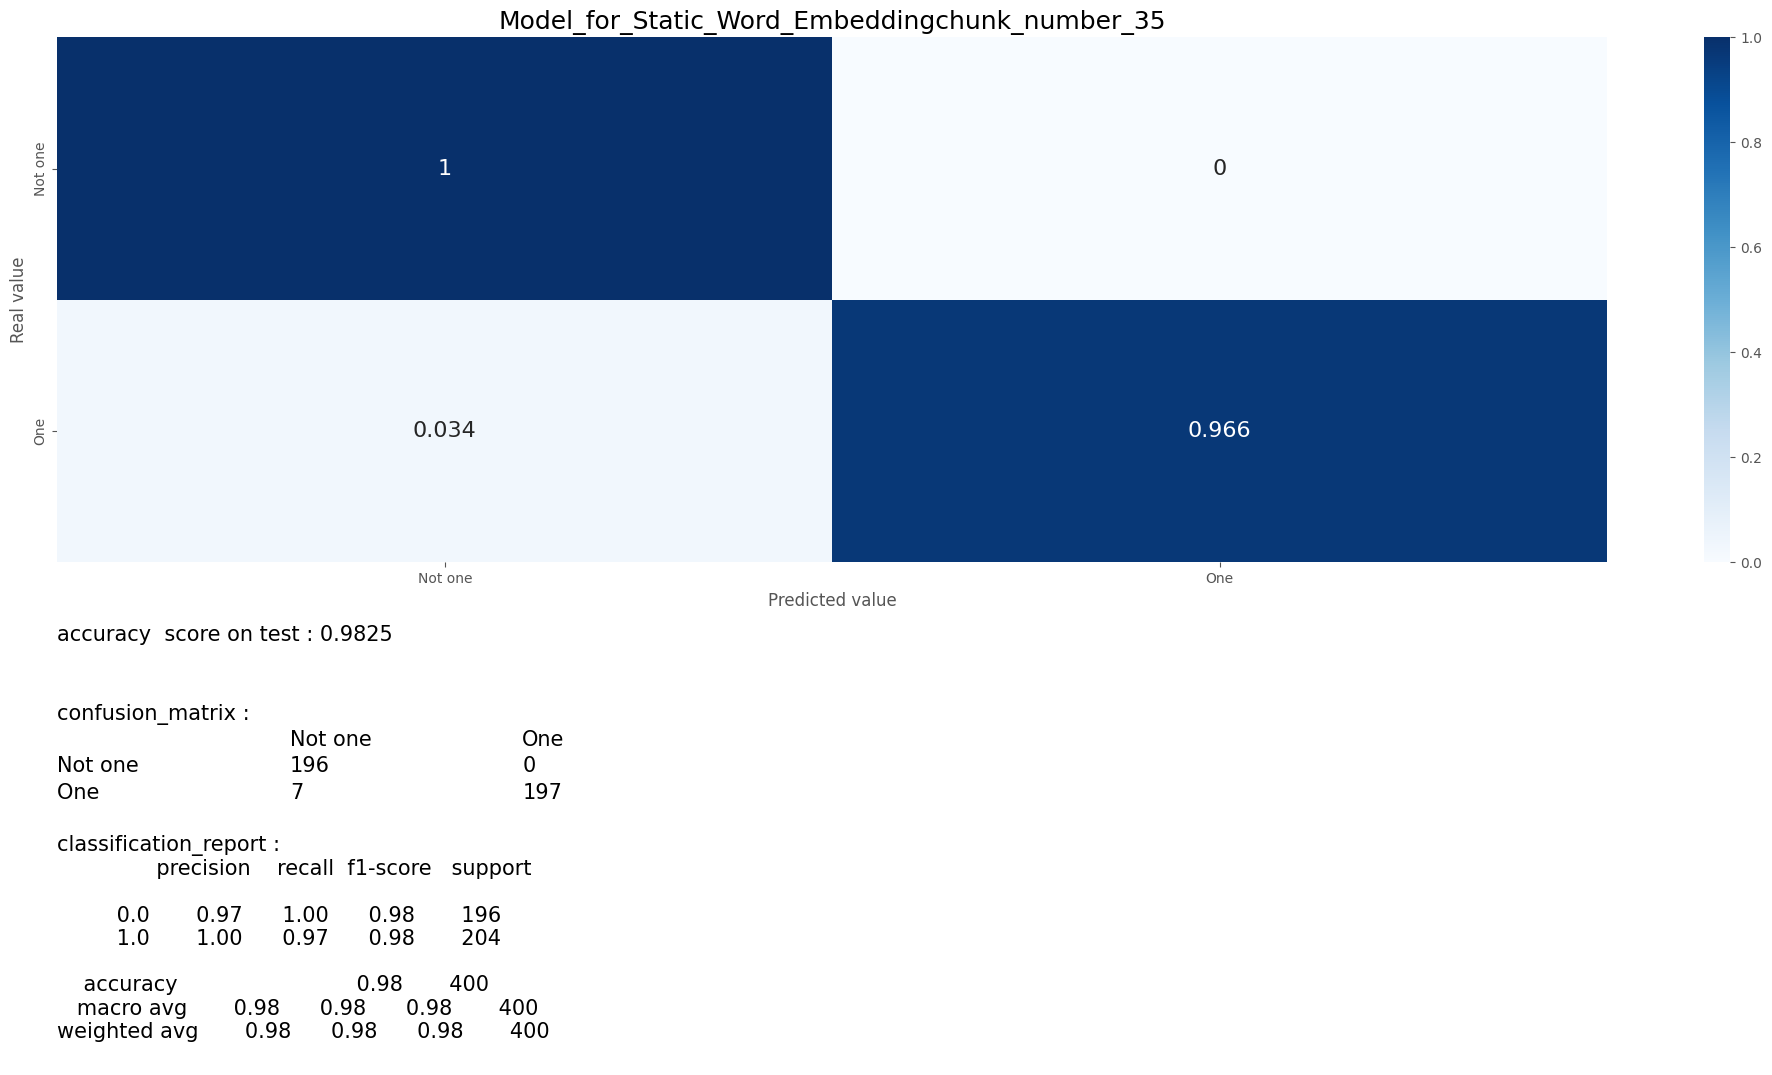

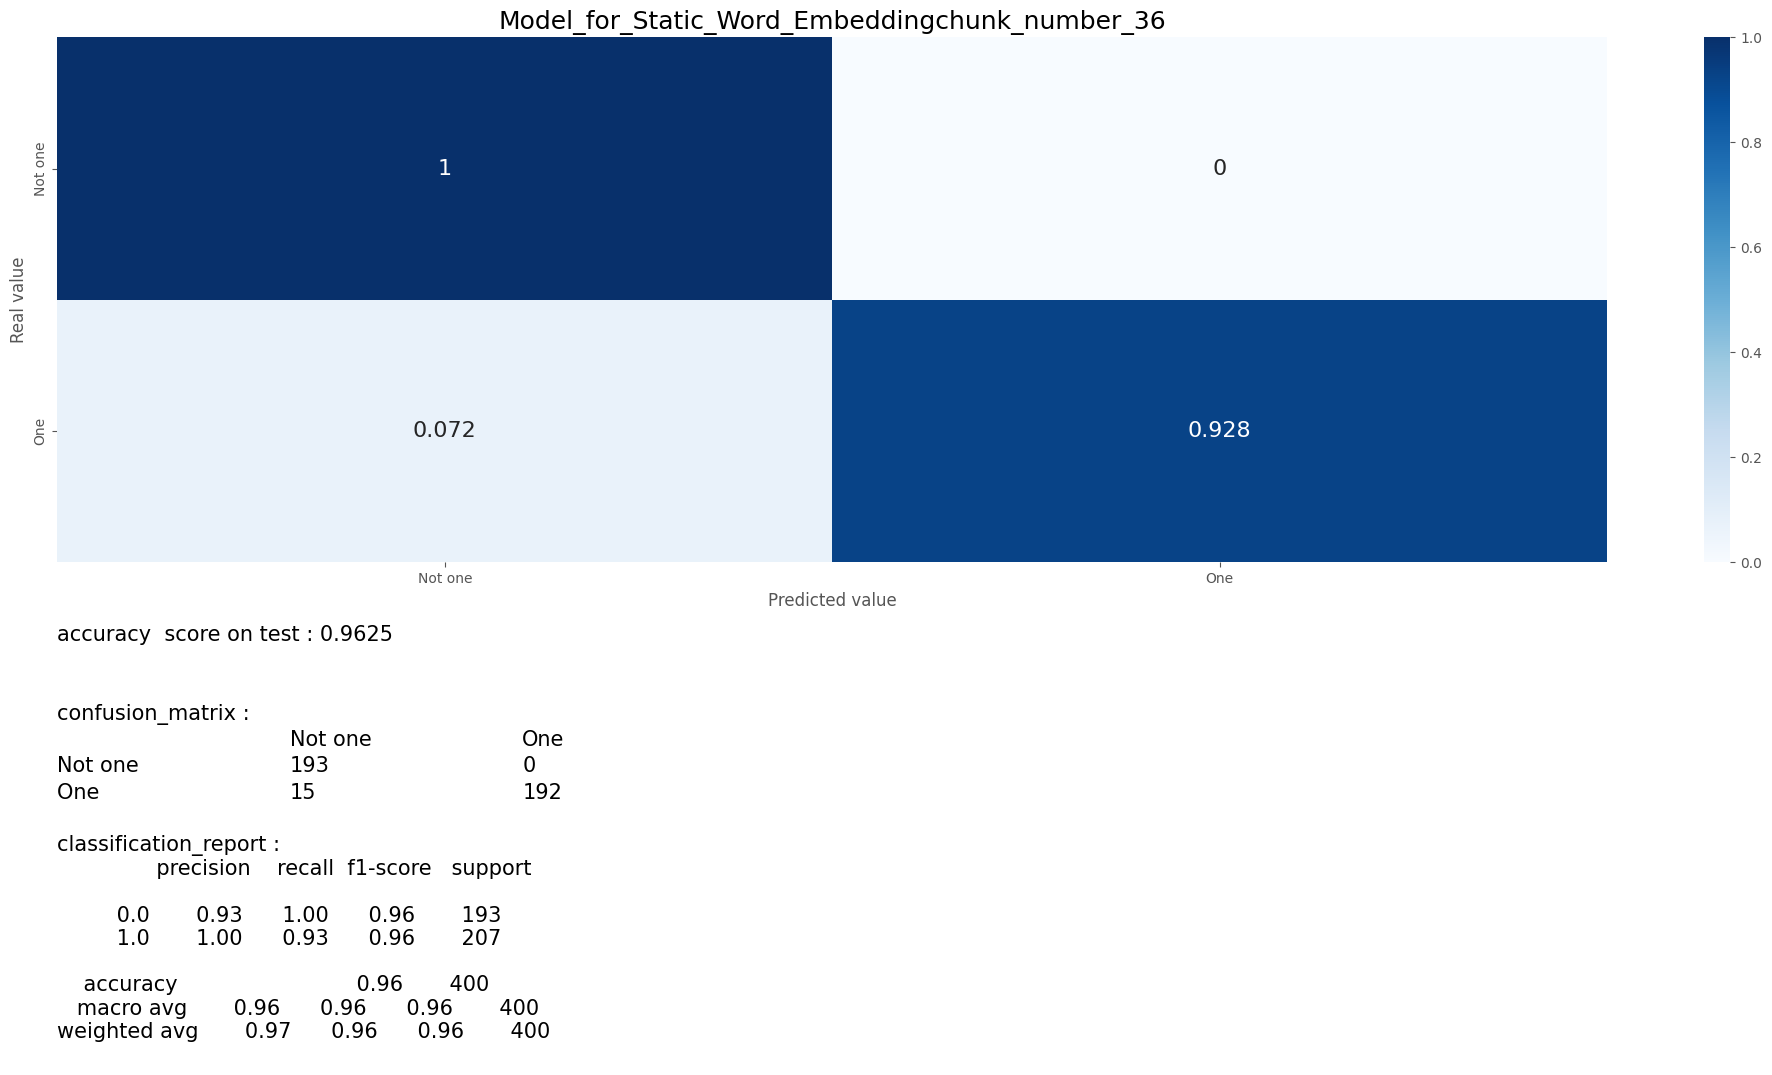

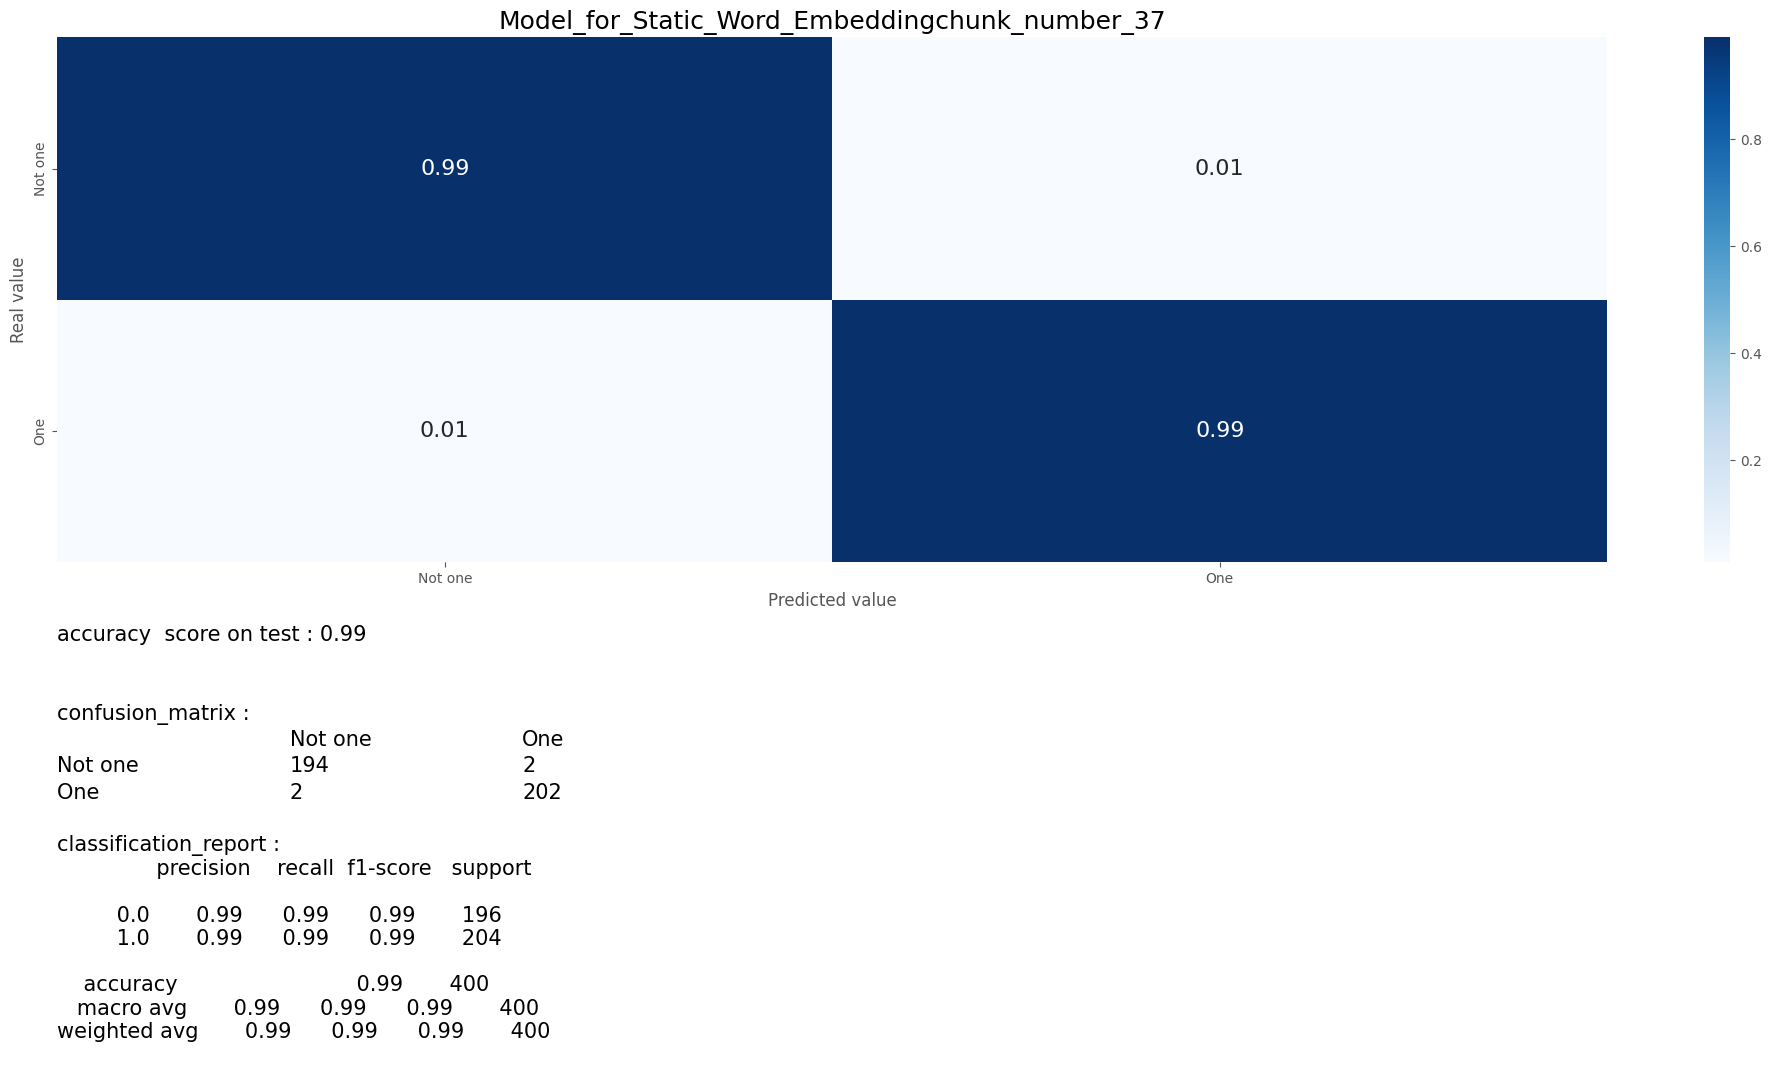

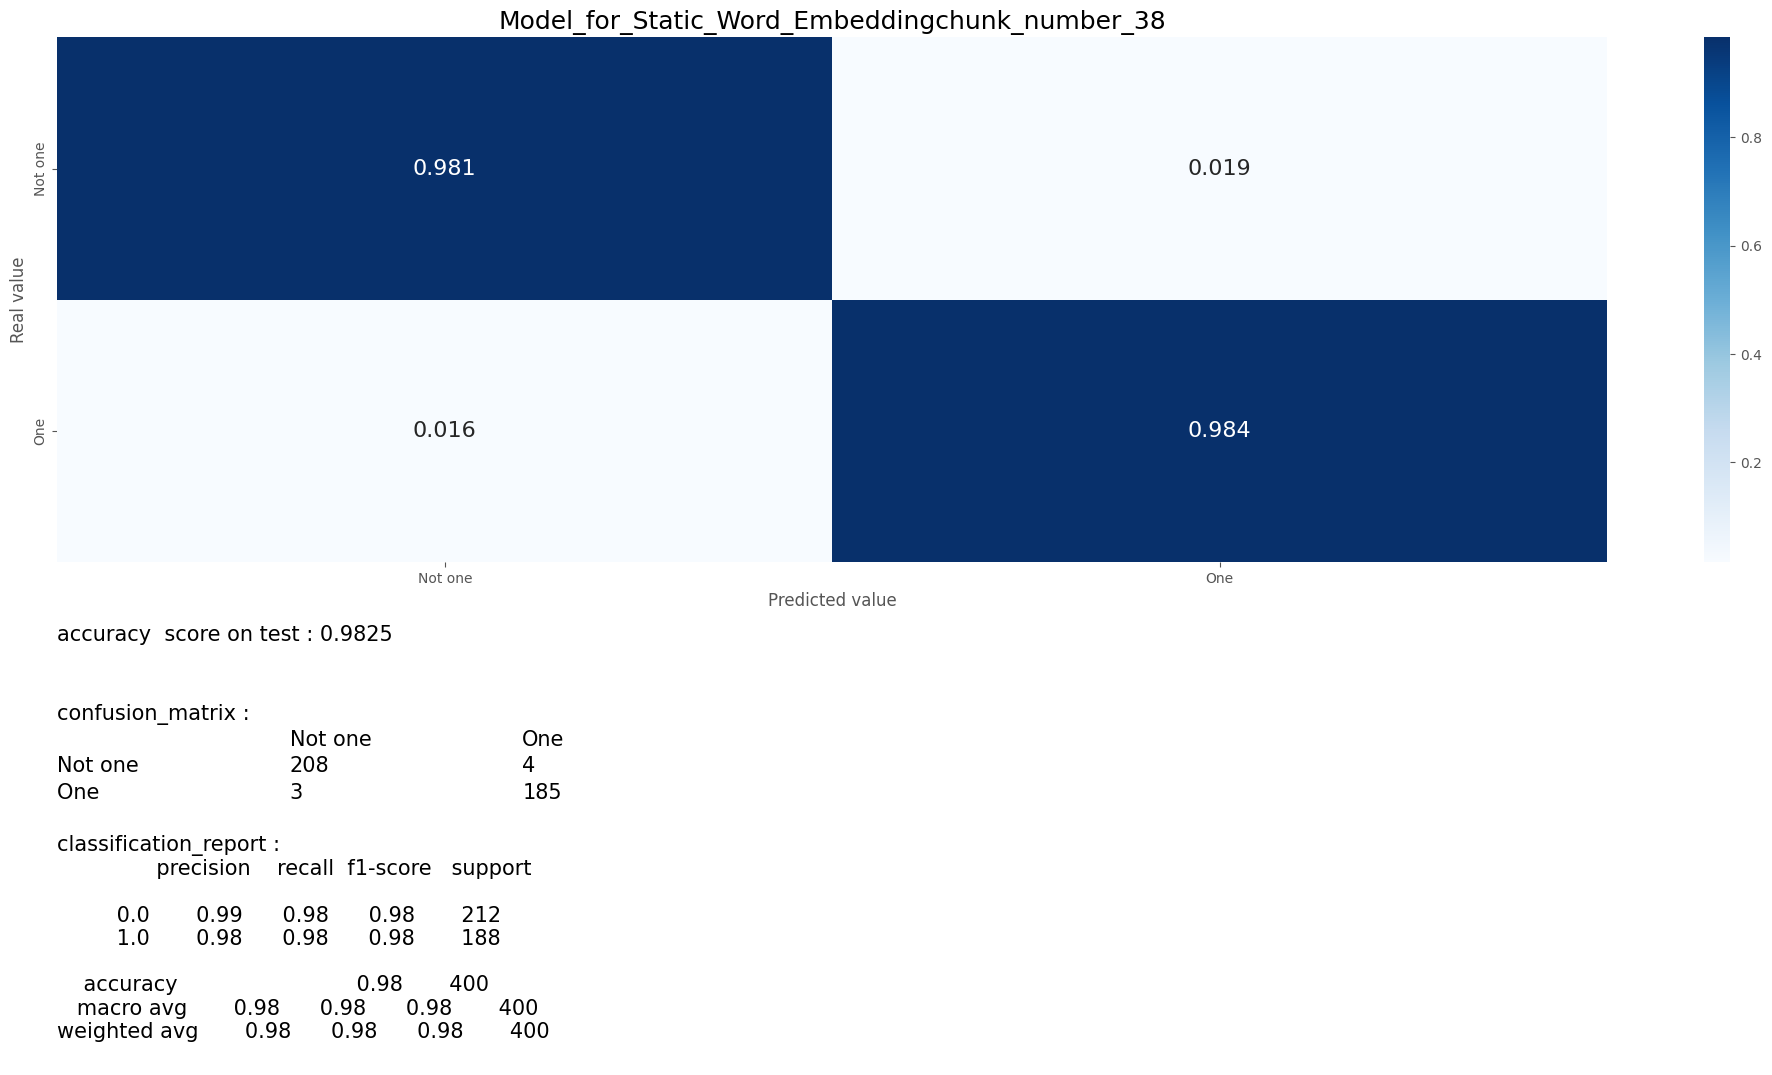

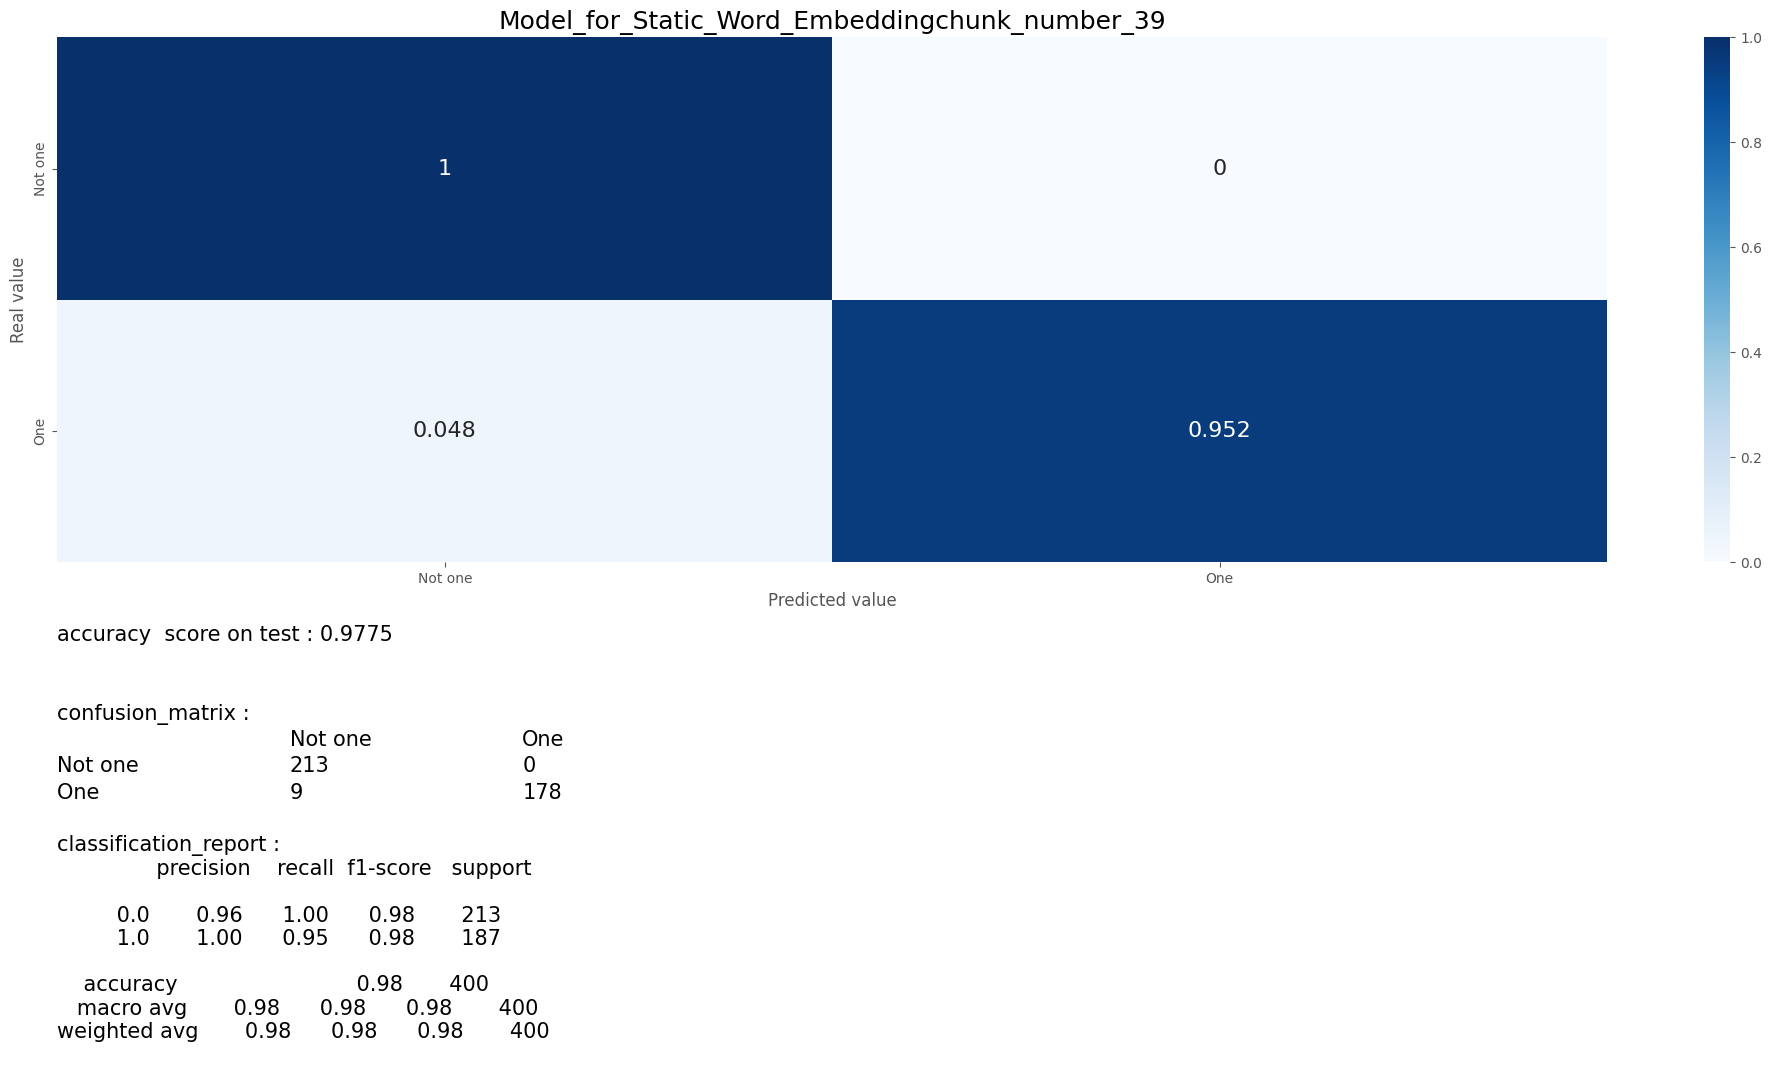

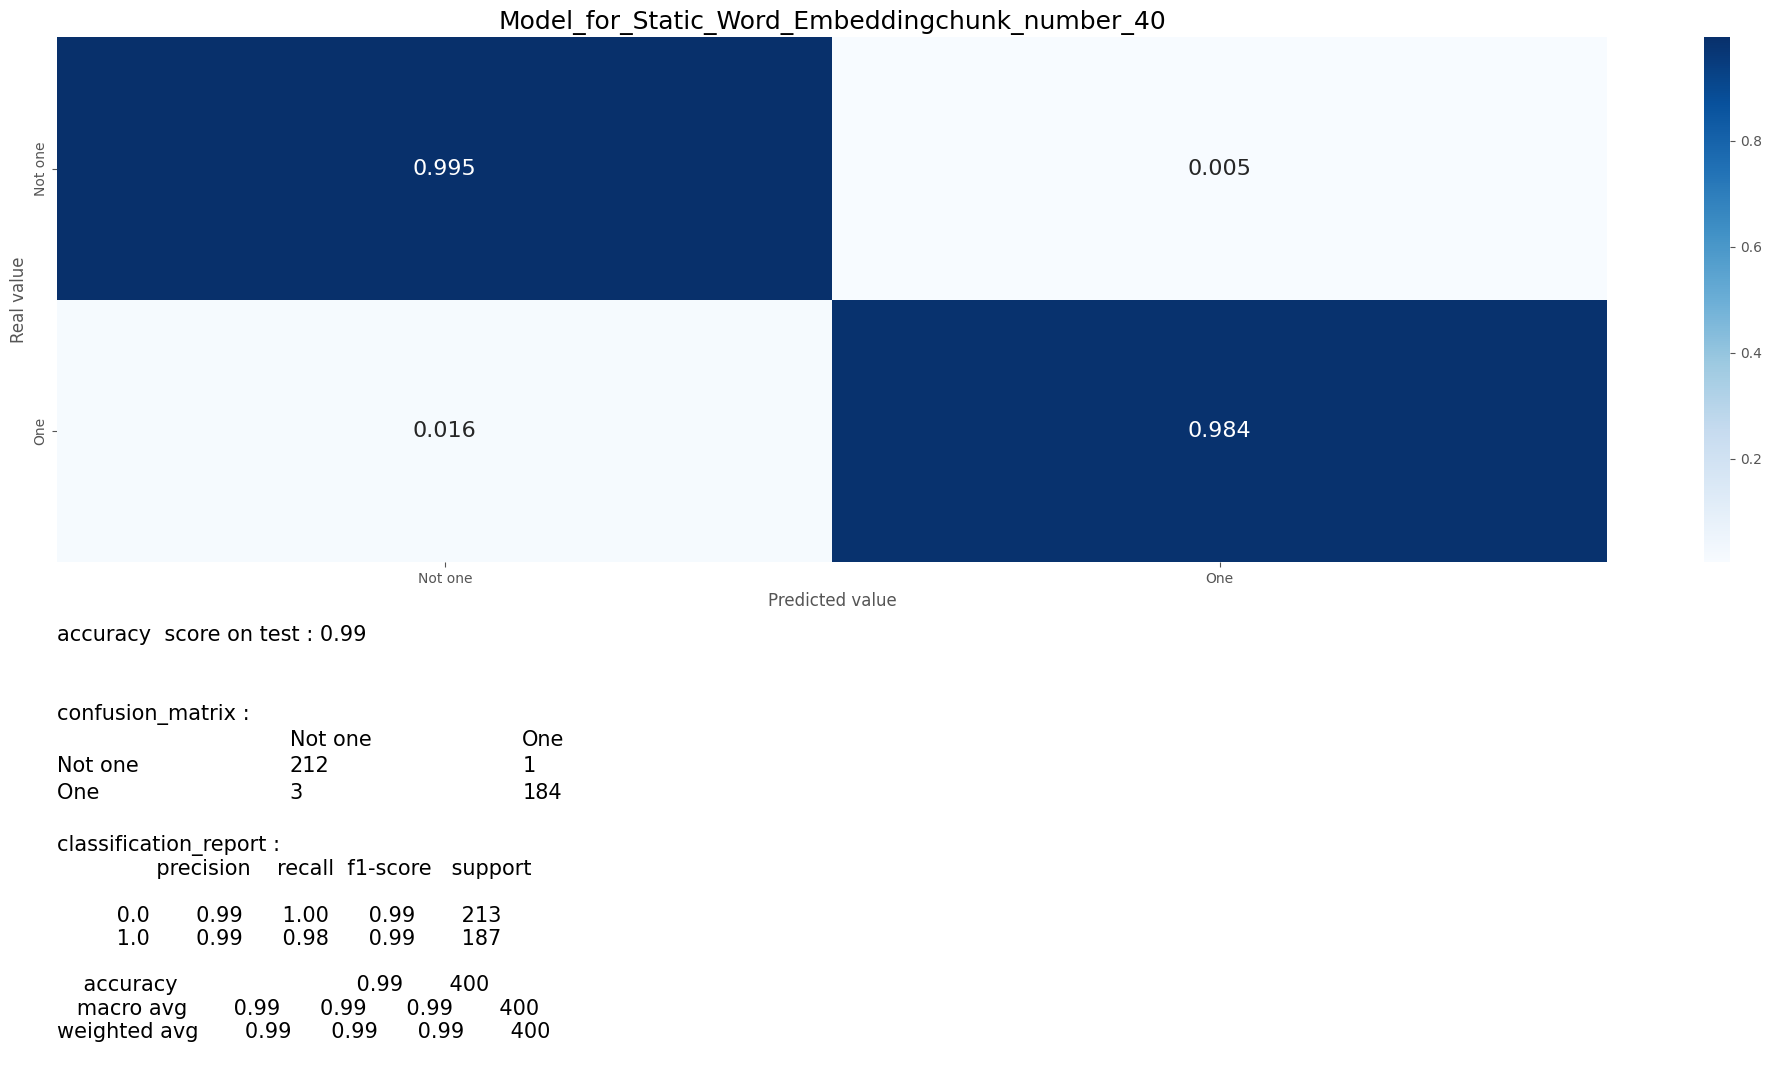

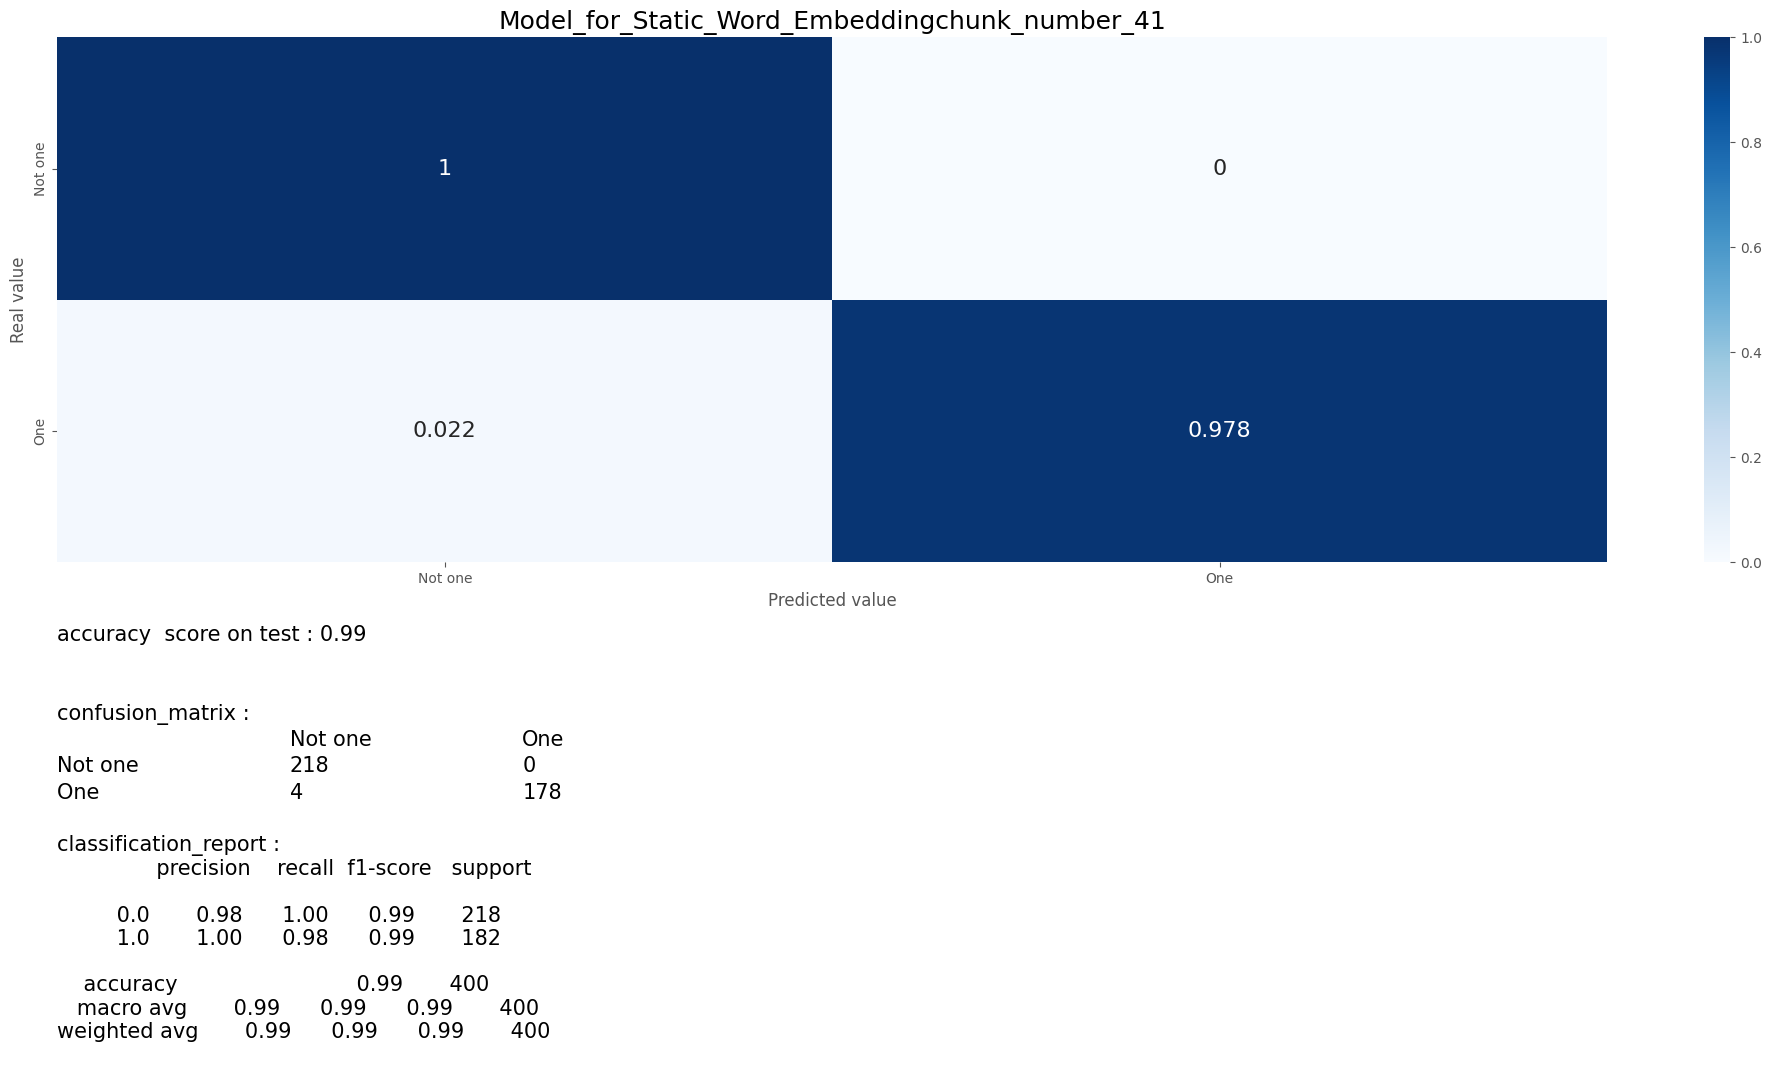

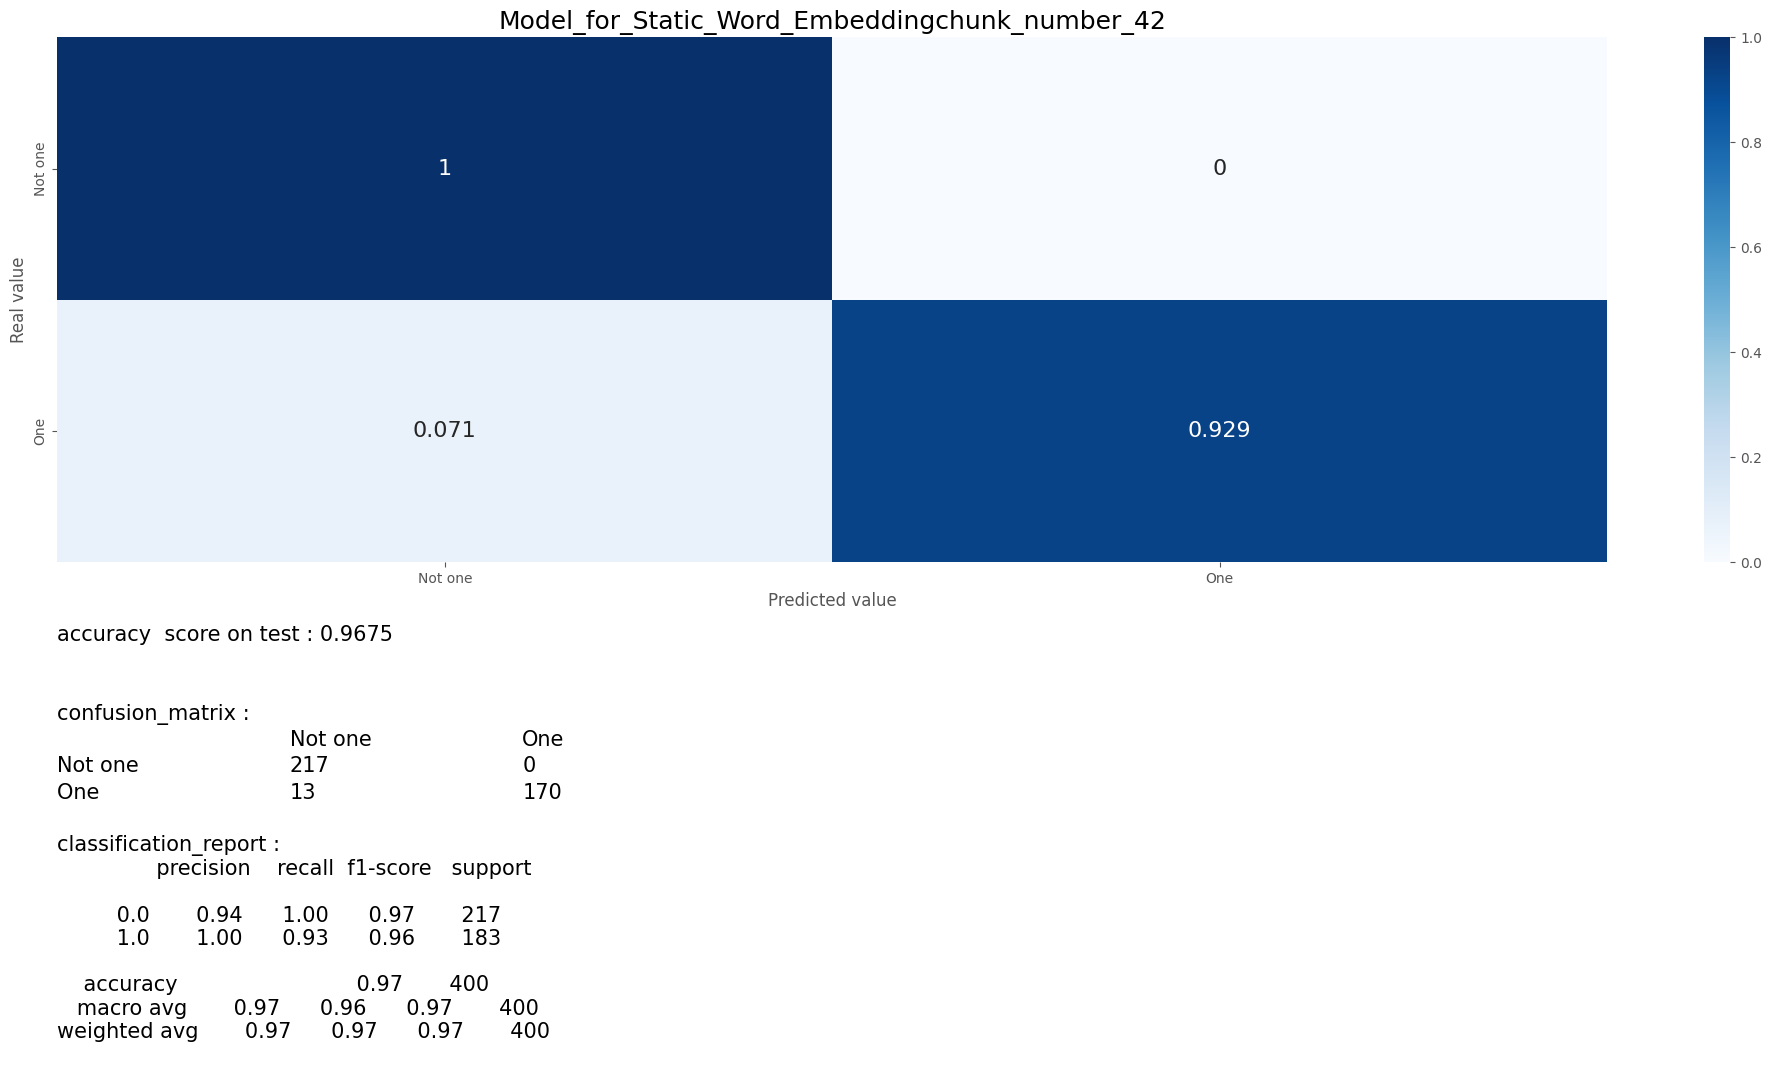

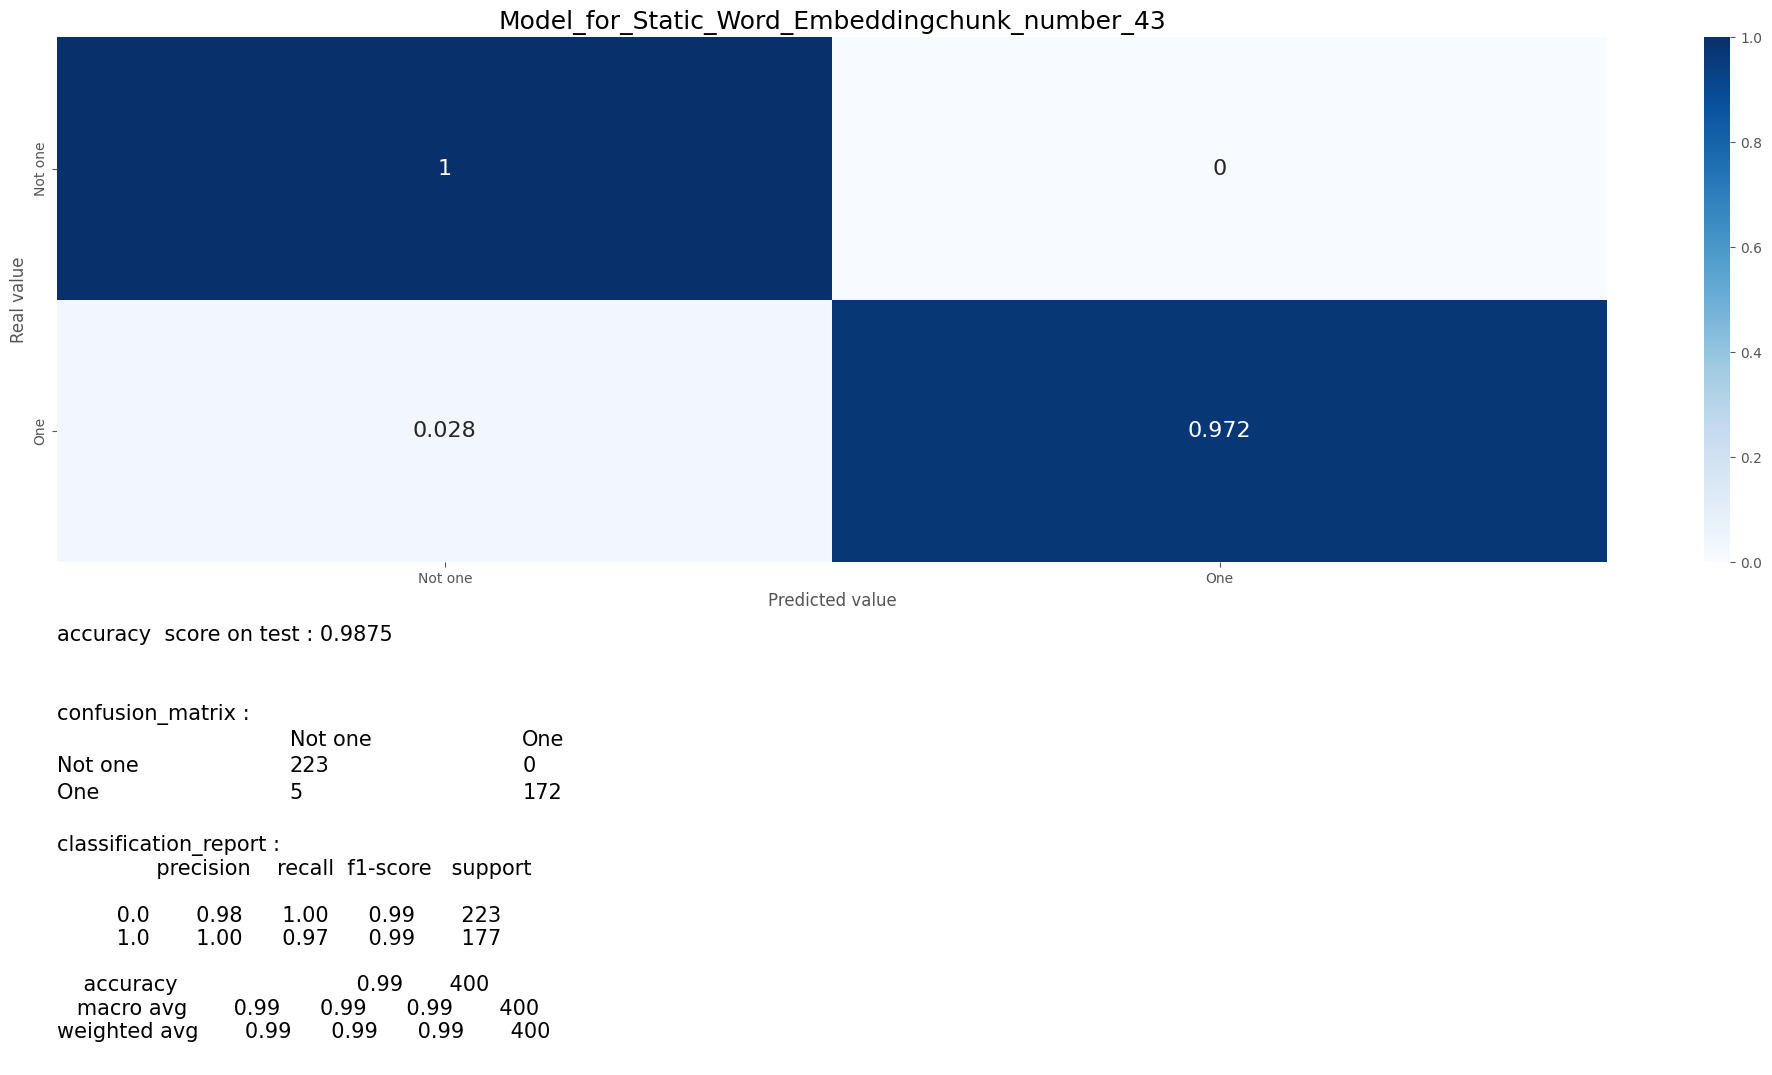

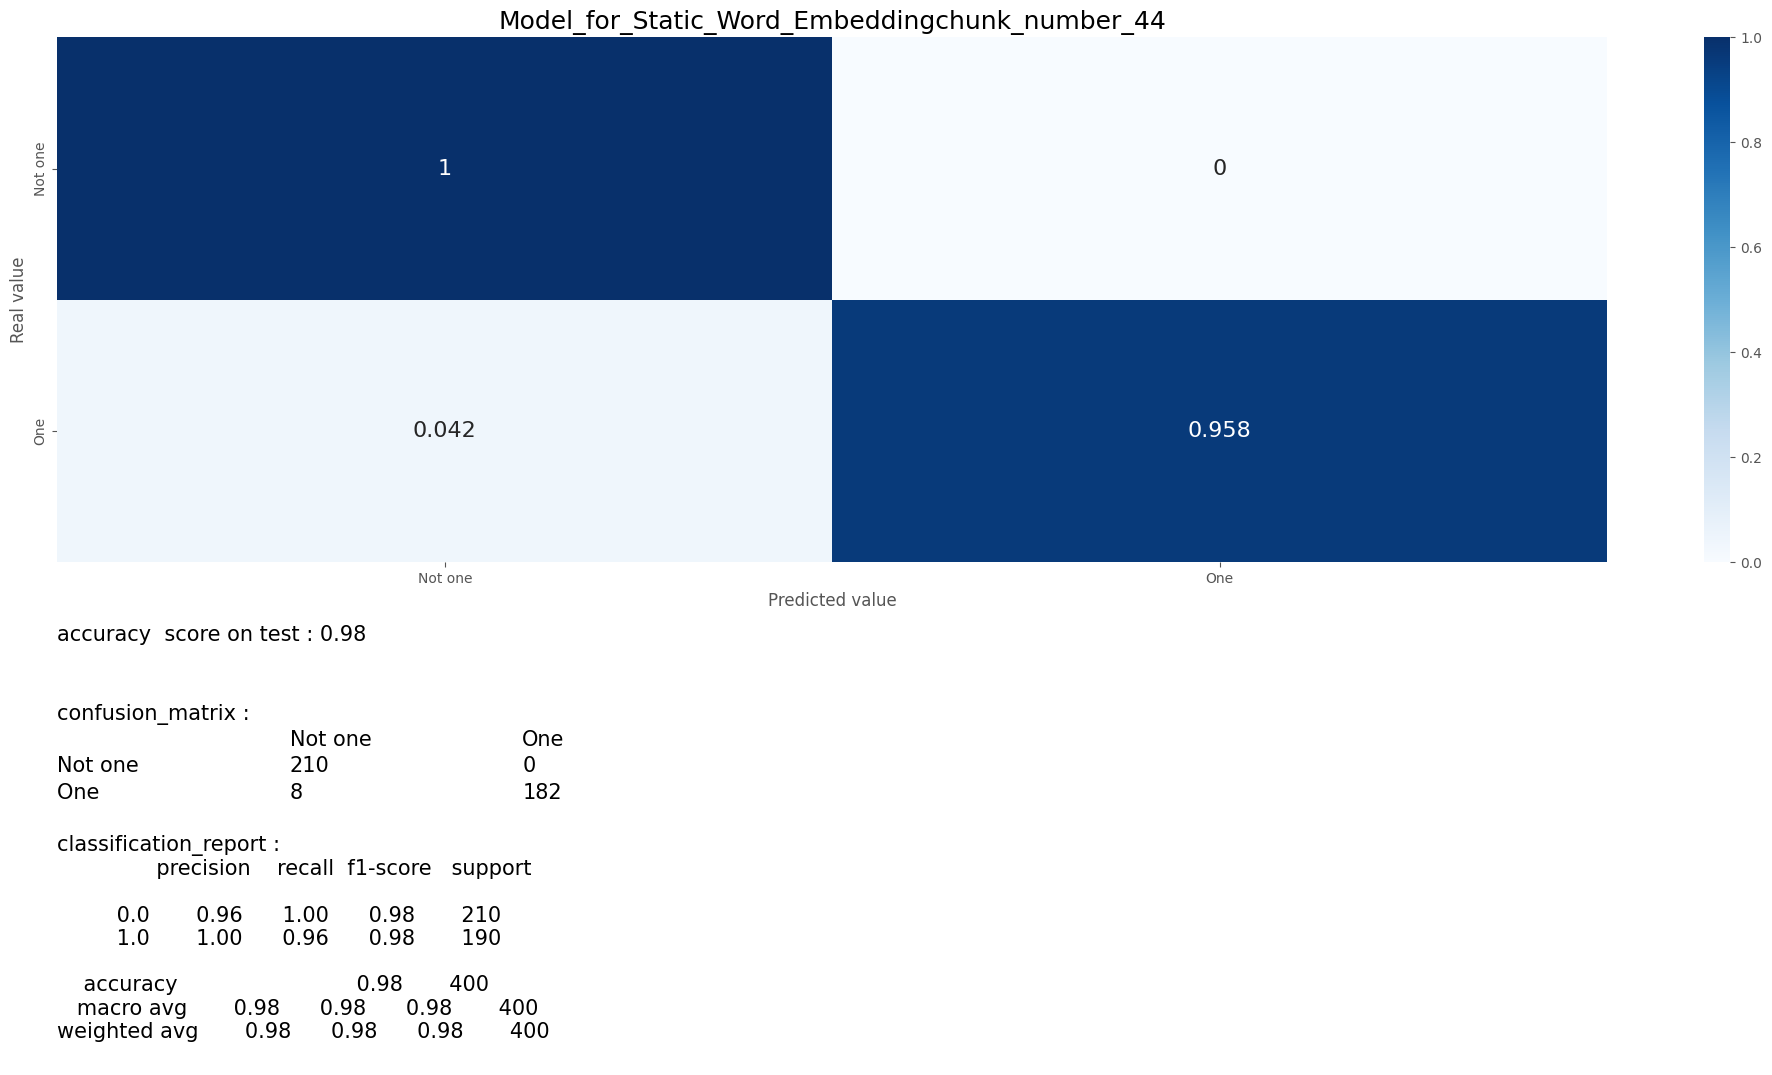

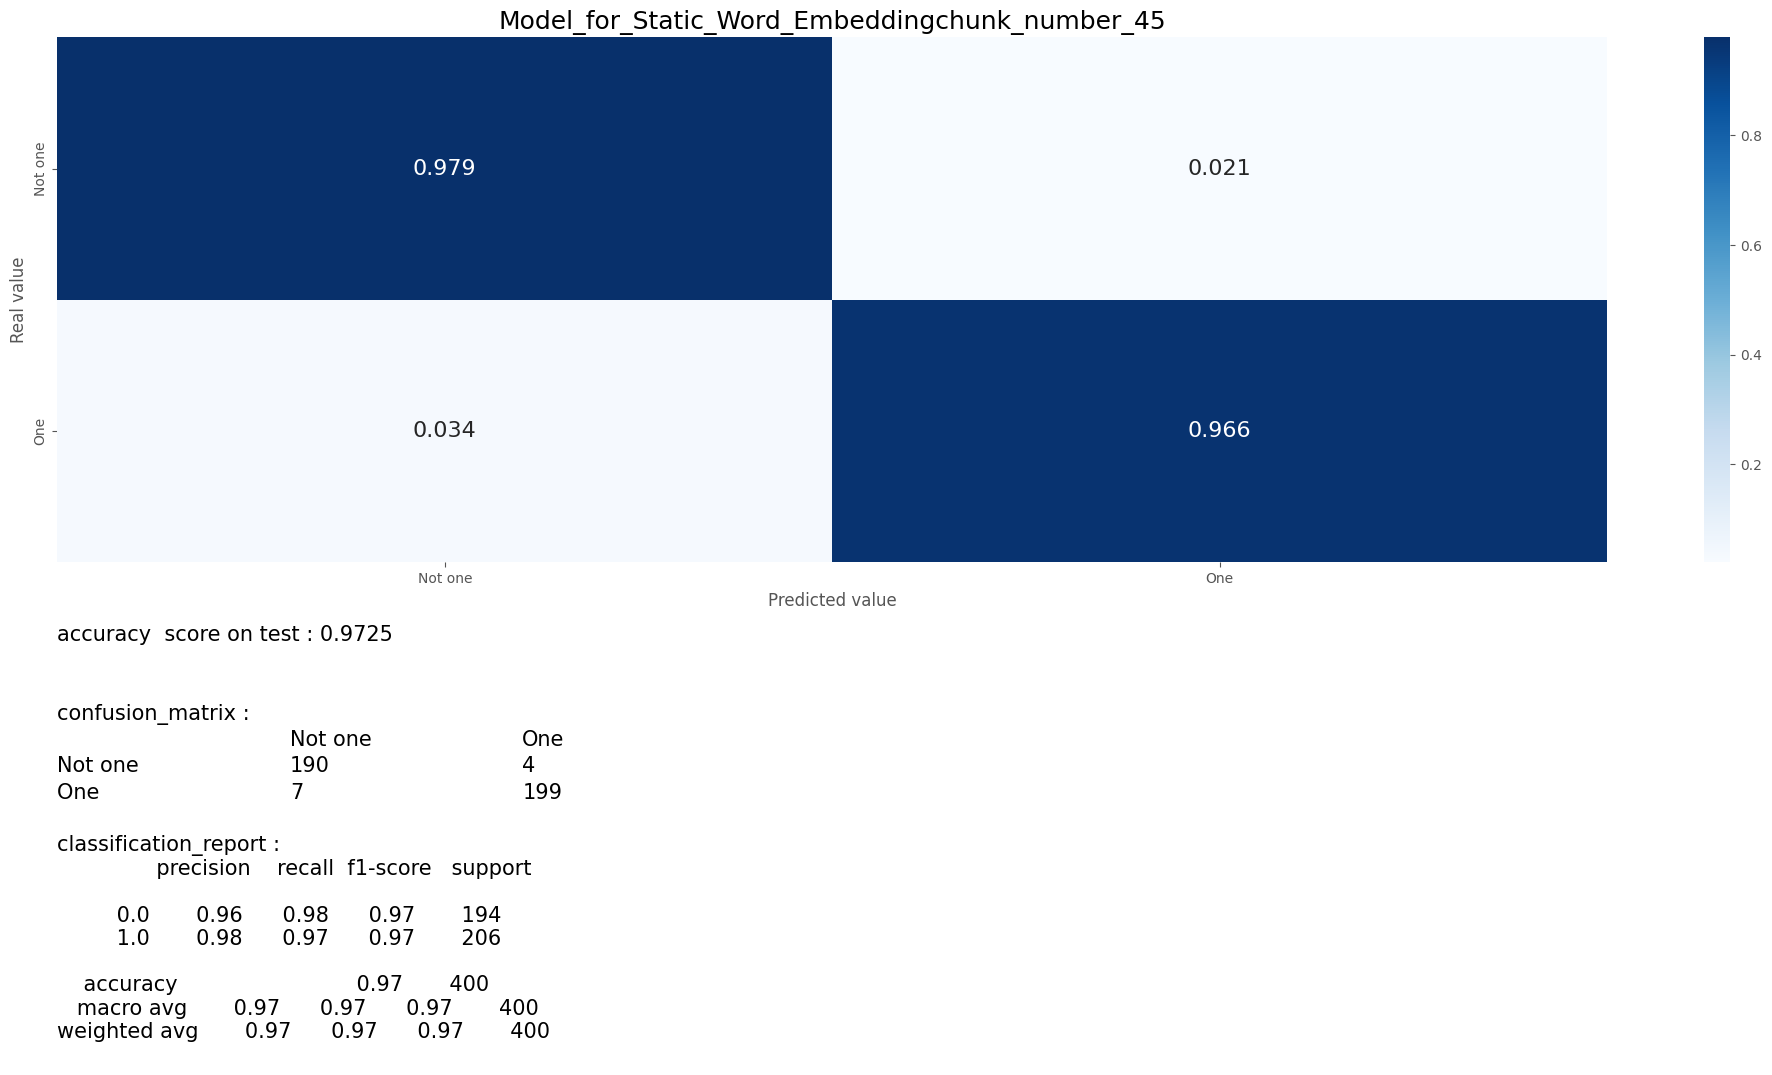

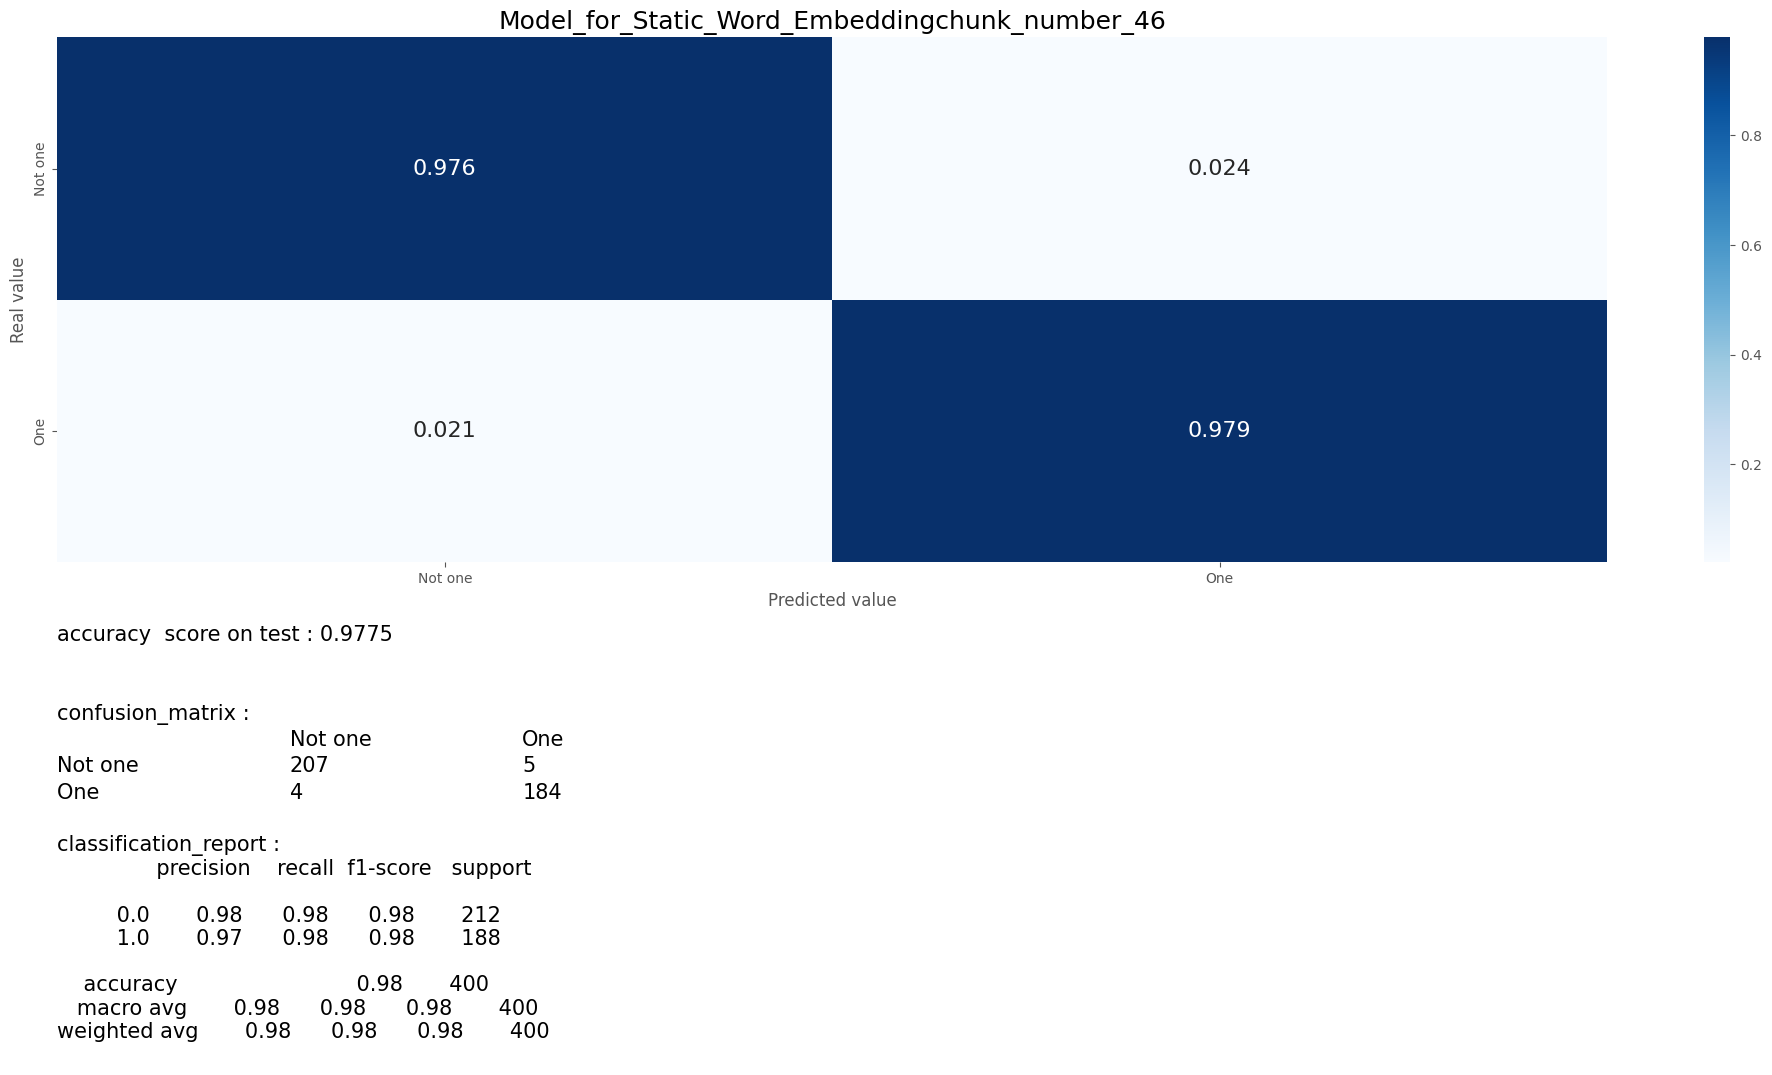

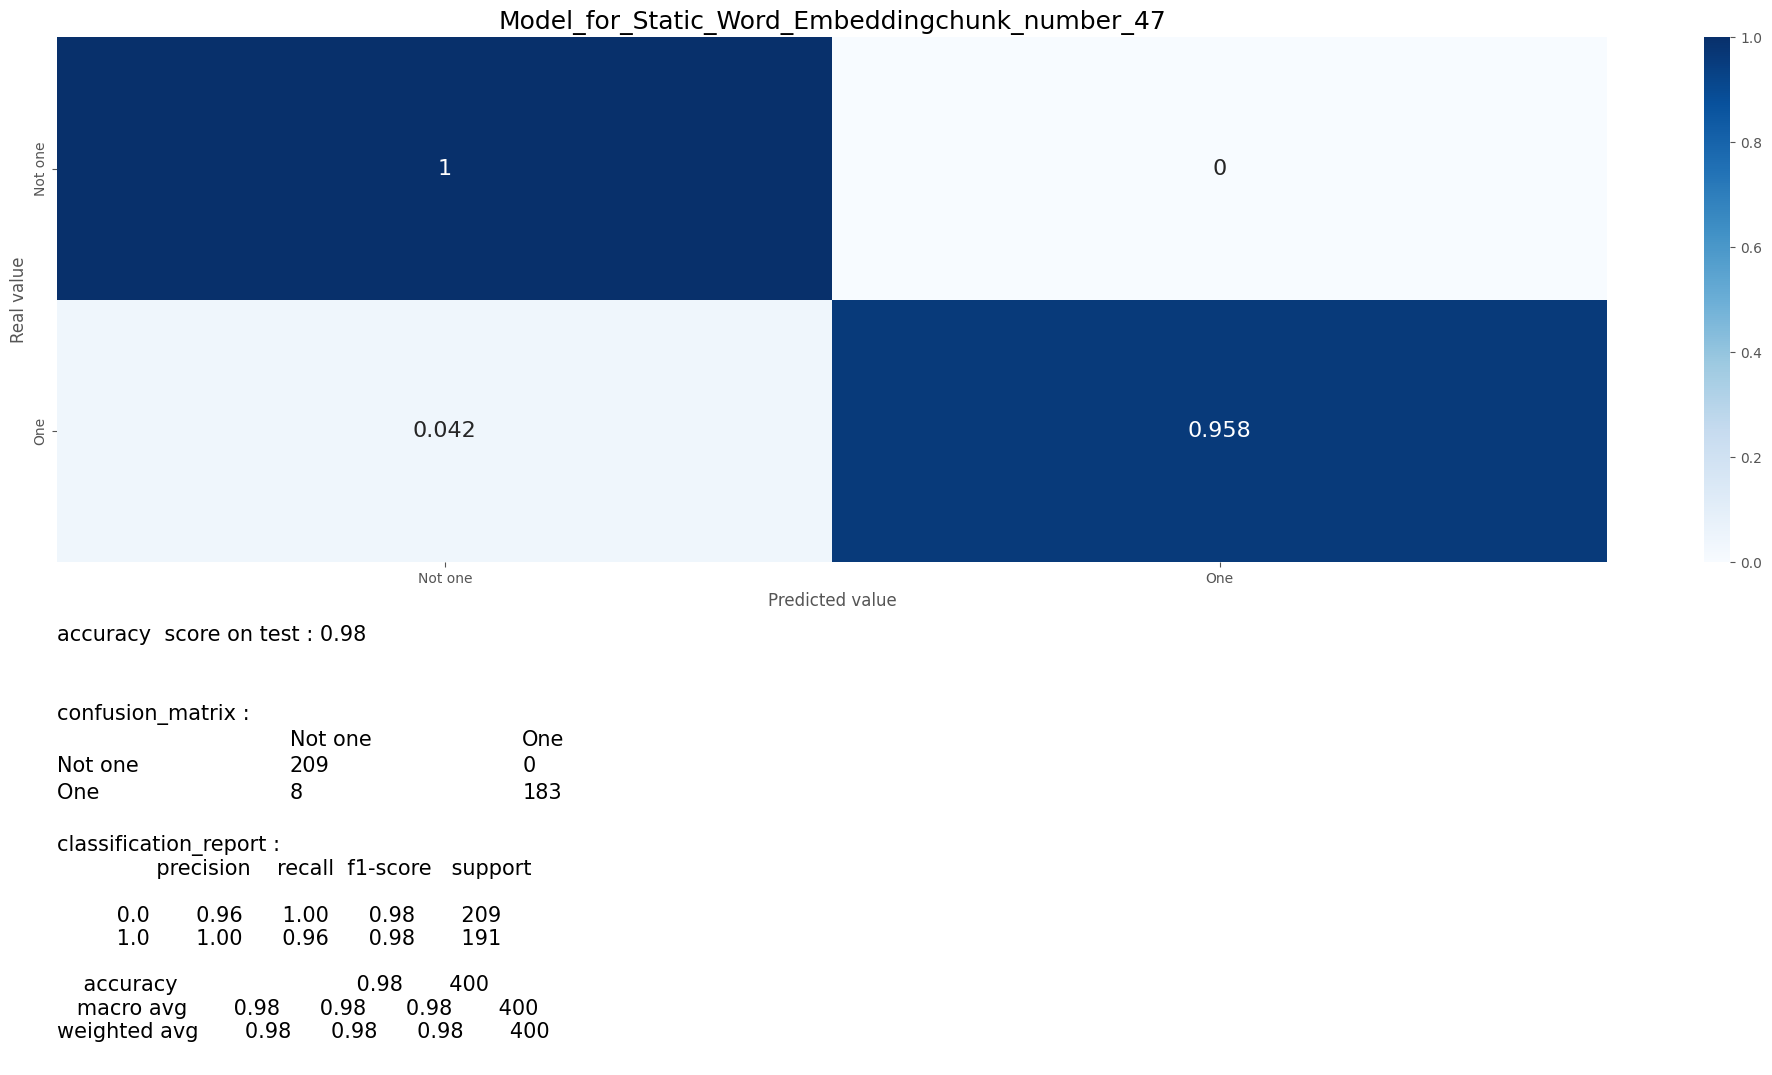

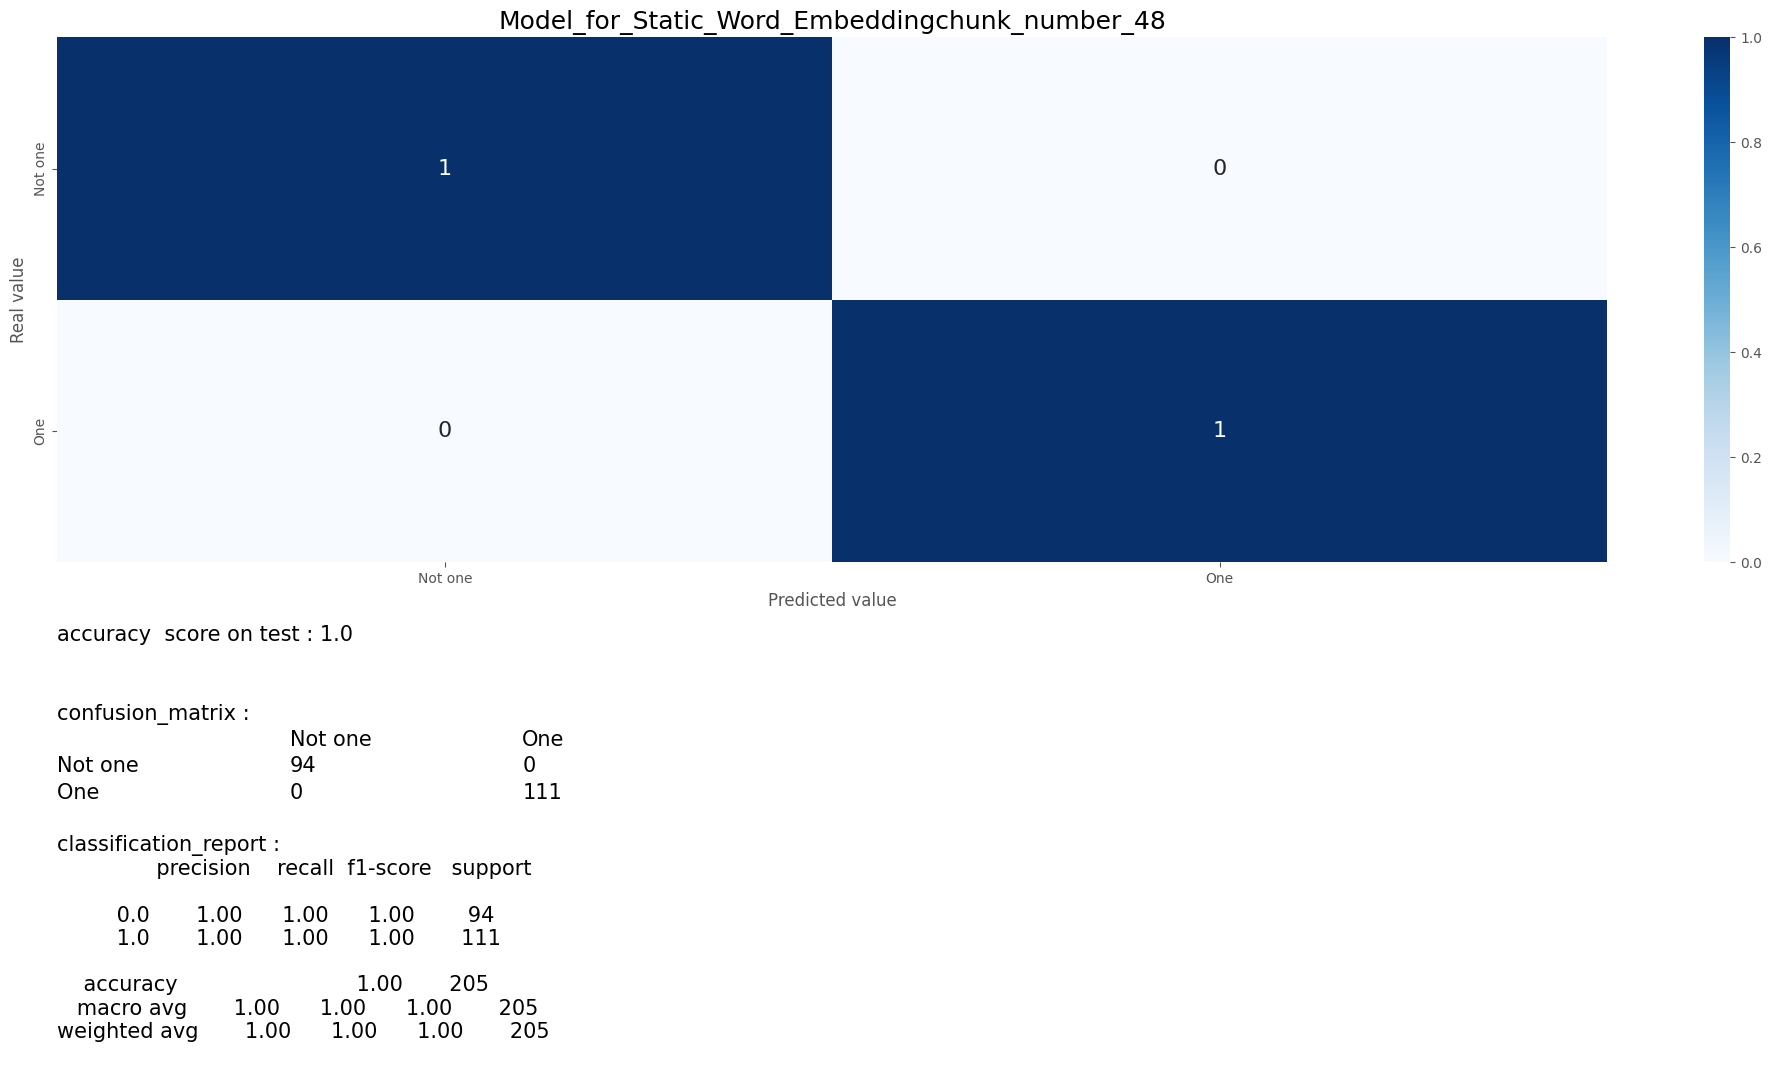

In [ ]:
for i,df_iterator in tqdm(enumerate(pd.read_csv(os.path.join(data_path,"XSS_dataset_payload.csv"),chunksize=2000))):
  df_iterator = df_iterator.mask(df_iterator.eq(np.nan)).dropna()
  X_train , y_train , X_test , y_test  = chunking_data(df_iterator)
  X_train = Pad_Sequences(X_train,fit = True)
  X_test = Pad_Sequences(X_test,fit=False) # ,creat=False
  history1 = model1.fit(X_train,y_train,epochs=10,batch_size=100,validation_split=0.20,callbacks=callbacks_list_1, verbose=0)
  evaluate_result(model_result_table_1,model1.predict(X_test,verbose=False),y_test,"Model_for_Static_Word_Embedding",i,0)

In [ ]:
print("Save Result ....")
save_object(model_result_table_1, "model_result_table_1",results_path)
model1.save(os.path.join(model_info_path,"model1.h5"))

In [ ]:
print("Save Result ....")
save_object(model_result_table_1, "model_result_table_1",results_path)
model1.save(os.path.join(model_info_path,"model1.h5"))

Save Result ....
